In [1]:
def filter_for_ccps(tracks_to_check,
                    minimum_dnm2_counts=3,
                    sig_pval_cutoff=0.01,
                    minimum_lifetime=20,
                    maximum_lifetime=180,
                    initial_msd_threshold=0.02,
                    pixel_size=0.108):
                    
    """return tracks that are sufficiently DNM2 rich, not too long or not too short, and aren’t too speedy"""
    tracks_kept = [] # the CCPs we’re keeping
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        track_lifetime = return_track_attributes.return_track_lifetime(tracks_to_check, i)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][1]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        max_1s = 0
        for itm in repeated_indices:
            if itm[0] == 1:
                if itm[1]>max_1s:
                    max_1s=itm[1]
        max_dnm2_repeats = max_1s
        initial_msd = tracks_to_check[i][index_dictionary['index_MotionAnalysis']][0][0][1][0][0]
        initial_msd = pixel_size**2 * initial_msd
       
        if track_lifetime >= minimum_lifetime and \
           track_lifetime <= maximum_lifetime and \
           max_dnm2_repeats >= minimum_dnm2_counts and \
           initial_msd <= initial_msd_threshold:
            tracks_kept.append(tracks_to_check[i])
    return tracks_kept

In [2]:
def filter_for_ccps_with_nef(tracks_to_check,
                    minimum_nef_counts=4,
                    sig_pval_cutoff=0.01):
    
    """return tracks that are sufficiently nef rich, not too long or not too short, and aren’t too speedy"""
    tracks_kept = [] # the CCPs we’re keeping
    tracks_discarded = []
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][2]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        max_1s = 0
        for itm in repeated_indices:
            if itm[0] == 1:
                if itm[1]>max_1s:
                    max_1s=itm[1]
        max_nef_repeats = max_1s
    
       
        if max_nef_repeats >= minimum_nef_counts:
            tracks_kept.append(tracks_to_check[i])
        else:
            tracks_discarded.append(tracks_to_check[i])
#     print(len(tracks_kept), len(tracks_discarded))
    return tracks_kept, tracks_discarded

In [3]:
# Function for detecting frame positions for the longest statistically significant consecutive detection of a non-coat channel.
# Returns these frame positions as a list with same index as tracks. 
def channel_consecutive_coloc_frametimes(tracks_to_check,
                                         channel_id,
                                         sig_pval_cutoff=0.01):
    frame_starts = []
    frame_ends = []
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][channel_id]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        #print(repeated_indices)
    
        #code for detecting which tuple has highest # of consecutive detections. 
        #If there are multiple tuples with the highest number, the tuple that appears latest on the list is selected
        coloc_frame = max([x for x, y in enumerate(repeated_indices) if
                         (repeated_indices[x][1] == max(repeated_indices)[1] and
                          repeated_indices[x][0] == 1)])
        
        start = 0
        end = 0
        for k in range(coloc_frame):
            start += repeated_indices[k][1]

        end = start + repeated_indices[coloc_frame][1]
        
        frame_starts.append(start)
        frame_ends.append(end)
        
    return frame_starts, frame_ends

In [4]:
# Function for detecting frame positions for the longest statistically significant consecutive detection of Nef.
# Returns these frame positions as a list with same index as tracks. 
def nef_consecutive_coloc_frametimes(tracks_to_check, 
                                     sig_pval_cutoff=0.01):
    frame_starts = []
    frame_ends = []
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][2]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        #print(repeated_indices)
    
        #code for detecting which tuple has highest # of consecutive detections. 
        #If there are multiple tuples with the highest number, the tuple that appears latest on the list is selected
        nef_frame = max([x for x, y in enumerate(repeated_indices) if
                         (repeated_indices[x][1] == max(repeated_indices)[1] and
                          repeated_indices[x][0] == 1)])
        
        start = 0
        end = 0
        for k in range(nef_frame):
            start += repeated_indices[k][1]

        end = start + repeated_indices[nef_frame][1]
        
        frame_starts.append(start)
        frame_ends.append(end)
        
    return frame_starts, frame_ends

In [5]:
#function to calculate the mean displacement of each channel within the indicated frame bounds. Displacement is calculated by comparing the postion at t and t-1. Use the function 
#channel_consecutive_coloc_frametimes to obtain a list that indicates when the frame starts and a list that indicates when the frame ends for each track
def mean_distance_difference_filter(tracks_to_check,
                             channel_0,
                             channel_1,
                             frame_starts,
                             frame_ends,
                             mean_distance_threshold):
    
    tracks_kept = [] # the CCPs we’re keeping
    tracks_discarded = [] # the CCPs we're discarding
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        xpos_c0 = tracks_to_check[i][index_dictionary['index_x_pos']][channel_0]
        ypos_c0 = tracks_to_check[i][index_dictionary['index_y_pos']][channel_0]
        
        xpos_c1 = tracks_to_check[i][index_dictionary['index_x_pos']][channel_1]
        ypos_c1 = tracks_to_check[i][index_dictionary['index_y_pos']][channel_1]
        
        distance_difference = []

        for j in range(frame_starts[i], frame_ends[i]):
            distance_difference.append(np.sqrt((xpos_c0[j]-xpos_c1[j])**2 + (ypos_c0[j]-ypos_c1[j])**2))
        
        mean_distance_difference = np.sum(distance_difference)/len(distance_difference)
        
        if mean_distance_difference < mean_distance_threshold:
            tracks_kept.append(tracks_to_check[i])
        else:
            tracks_discarded.append(tracks_to_check[i])
            
    return tracks_kept, tracks_discarded

In [6]:
# Function form of max_consecutive calculation with tolerance. This should calculate lifetimes with gap lengths just like for the coat channel. 
def max_consecutive_with_gap (tracks_to_check, 
                              sig_pval_cutoff=0.01,
                              channel = 1,
                              gap = 2,
                              framerate = 2):
    
    gap_tolerated_lifetime = []
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][channel]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        #print(repeated_indices)
        
        gap_tolerated_repeated_indices = []
        
        for ii in range(len((repeated_indices))):
            if ((ii != 0) & (repeated_indices[ii][0] == 0) & (repeated_indices[ii][1] <= gap) & (ii != (len(repeated_indices)) - 1)):
                gap_tolerated_repeated_indices.append((1, repeated_indices[ii][1]))
            else:
                gap_tolerated_repeated_indices.append(repeated_indices[ii])
        
        gap_tolerated_max_consecutive = 0
        temp_consecutive = 0
        
        #print(repeated_indices)
        #print(gap_tolerated_repeated_indices)
        
        for ii in range(len((gap_tolerated_repeated_indices))):
            if (gap_tolerated_repeated_indices[ii][0] == 0):
                temp_consecutive = 0
            else:
                temp_consecutive += gap_tolerated_repeated_indices[ii][1]

            gap_tolerated_max_consecutive = max(temp_consecutive, gap_tolerated_max_consecutive)
            #print('index')
            #print(ii)
            #print('detection')
            #print(gap_tolerated_repeated_indices[ii][0])
            #print('value')
            #print(gap_tolerated_repeated_indices[ii][1])
        gap_tolerated_lifetime.append(gap_tolerated_max_consecutive * framerate)
        
    return gap_tolerated_lifetime

In [7]:
# Function to obtain info on first detection of a protein within a track
def first_detection_time (tracks_to_check, 
                           sig_pval_cutoff=0.01,
                           channel = 1,
                           framerate = 2):
    
    first_detection_list = []
    
    for i in tqdm(range(len(tracks_to_check))):
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][channel]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        
        if (sum(significant_pval_indices) > 0):
            first_detection = significant_pval_indices.index(1) * framerate
        else:
            first_detection = float("NaN")
        
        first_detection_list.append(first_detection)
    
    return first_detection_list
    

In [8]:
test = [0,0,0,0,0, 1]
sum(test)

1

# import all necessary Python modules

In [9]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
import itertools
import scipy.interpolate as interpolate
import re
import seaborn as sns
import random
import scipy.stats as stats

#sys.path.append(unique_user_path_notebook+'/cmeAnalysisPostProcessingPythonScripts') # add custom Python scripts to the local path
import display_tracks
import merge_tools
import feature_extraction_with_buffer
import generate_index_dictionary
import return_track_attributes

# batch load nef tracks

Loading 1st replicate

In [12]:
tracks_path_1 = 'I:/Analysis/NA7NefCme/AP2DNM2NA7Nef_ringTIRF_segment_good/20211015'
track_directories_1 = os.listdir(tracks_path_1)

exp_date_1 = 20211015

In [13]:
movie_number_1 = []
cell_number_1 = []
cell_condition_1 = []
all_tracks_1 = []

condition_map_1 = {'1':-1,
                 '2':-1,
                 '3':-1,
                 '4':24,
                 '5':0,
                 '6':0,
                 '7':0,
                 '8':2,
                 '9':2,
                 '10':2,
                 '11':4,
                 '12':4,
                 '13':4,
                 '14':6,
                 '15':6,
                 '16':6,
                 '17':24,
                 '18':24,
                 '19':24}

for cell in track_directories_1:
    split = re.split('-|_',cell)
    movie_number_1.append(split[0][4:])
    cell_number_1.append(split[1])
    cell_condition_1.append(condition_map_1[movie_number_1[-1]])
    all_tracks_1.append(display_tracks.load_tracks(tracks_path_1+'/'+cell+'/Ch1/Tracking/ProcessedTracks.mat'))


Loading 2nd replicate

In [14]:
tracks_path_2 = 'I:/Analysis/NA7NefCme/AP2DNM2NA7Nef_ringTIRF_segment_good_2/20211006'
track_directories_2 = os.listdir(tracks_path_2)

exp_date_2 = 20210631

In [15]:
movie_number_2 = []
cell_number_2 = []
cell_condition_2 = []
all_tracks_2 = []

condition_map_2 = {'1':-1,
                 '2':-1,
                 '3':-1,
                 '4':0,
                 '5':0,
                 '6':0,
                 '7':2,
                 '8':2,
                 '9':2,
                 '10':4,
                 '11':4,
                 '12':4,
                 '13':4,
                 '14':6,
                 '15':6,
                 '16':6,
                 '17':24,
                 '18':24,
                 '19':24}

for cell in track_directories_2:
    split = re.split('-|_',cell)
    movie_number_2.append(split[0][4:])
    cell_number_2.append(split[1])
    cell_condition_2.append(condition_map_2[movie_number_2[-1]])
    all_tracks_2.append(display_tracks.load_tracks(tracks_path_2+'/'+cell+'/Ch1/Tracking/ProcessedTracks.mat'))


Loading 3rd replicate

In [16]:
tracks_path_3 = 'I:/Analysis/NA7NefCme/AP2DNM2NA7Nef_ringTIRF_segment_good_3/20211007'
track_directories_3 = os.listdir(tracks_path_3)

exp_date_3 = 20211007

In [17]:
movie_number_3 = []
cell_number_3 = []
cell_condition_3 = []
all_tracks_3 = []

condition_map_3 = {'1':-1,
                 '2':-1,
                 '3':-1,
                 '4':0,
                 '5':0,
                 '6':0,
                 '7':2,
                 '8':2,
                 '9':2,
                 '10':4,
                 '11':4,
                 '12':4,
                 '13':6,
                 '14':6,
                 '15':6,
                 '16':24,
                 '17':24,
                 '18':24}

for cell in track_directories_3:
    split = re.split('-|_',cell)
    movie_number_3.append(split[0][4:])
    cell_number_3.append(split[1])
    cell_condition_3.append(condition_map_3[movie_number_3[-1]])
    all_tracks_3.append(display_tracks.load_tracks(tracks_path_3+'/'+cell+'/Ch1/Tracking/ProcessedTracks.mat'))


In [18]:
index_dictionary = generate_index_dictionary.return_index_dictionary()


# Filtering Nef tracks

Filtering Nef tracks for 1st replicate

In [19]:
valid_tracks_1 = []

for tracks in all_tracks_1:
    
    valid_tracks_1.append(display_tracks.remove_tracks_by_criteria(tracks, track_category=[1]))

The number of tracks returned: 355

The number of tracks returned: 269

The number of tracks returned: 185

The number of tracks returned: 79

The number of tracks returned: 171

The number of tracks returned: 187

The number of tracks returned: 109

The number of tracks returned: 438

The number of tracks returned: 97

The number of tracks returned: 104

The number of tracks returned: 377

The number of tracks returned: 166

The number of tracks returned: 106

The number of tracks returned: 127

The number of tracks returned: 34

The number of tracks returned: 230

The number of tracks returned: 182

The number of tracks returned: 139

The number of tracks returned: 158

The number of tracks returned: 161

The number of tracks returned: 94

The number of tracks returned: 264

The number of tracks returned: 101

The number of tracks returned: 152

The number of tracks returned: 102

The number of tracks returned: 46

The number of tracks returned: 68

The number of tracks returned: 112

In [20]:
filtered_valid_tracks_1 = []

for tracks in valid_tracks_1:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=3,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    filtered_valid_tracks_1.append(tempFilteredTracks)


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]

33
41
14


  0%|                                                                                          | 0/438 [00:00<?, ?it/s]

21
20
44
18


  0%|                                                                                          | 0/377 [00:00<?, ?it/s]

103
26
18


  0%|                                                                                          | 0/127 [00:00<?, ?it/s]

106
54
36


  0%|                                                                                          | 0/182 [00:00<?, ?it/s]

23
5
44


  0%|                                                                                          | 0/161 [00:00<?, ?it/s]

64
27
19


100%|██████████████████████████████████████████████████████████████████████████████| 264/264 [00:00<00:00, 2744.46it/s]


32
10


100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 2089.98it/s]


41
14
38
16


  0%|                                                                                           | 0/88 [00:00<?, ?it/s]

9
11
19
19


  0%|                                                                                          | 0/121 [00:00<?, ?it/s]

15
8
16


  0%|                                                                                          | 0/242 [00:00<?, ?it/s]

39
4
22


  0%|                                                                                          | 0/111 [00:00<?, ?it/s]

41
29
17


100%|██████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 3027.44it/s]


23
32
18


  0%|                                                                                          | 0/125 [00:00<?, ?it/s]

24
14
23
13
13


100%|████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 1637.09it/s]

28
18
11
24



100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2568.89it/s]

32
30



  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

29
28
9


  0%|                                                                                          | 0/162 [00:00<?, ?it/s]

36
15
23


100%|██████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 2073.26it/s]

24
6
31
35


100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 3123.50it/s]


25
13



  0%|                                                                                          | 0/104 [00:00<?, ?it/s]

19
15
1
14
24


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

19
13
10
15
9


  0%|                                                                                          | 0/189 [00:00<?, ?it/s]

20
9
8
23


100%|██████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 3034.81it/s]

45
2
9
18



  0%|                                                                                          | 0/119 [00:00<?, ?it/s]

18
27
9


  0%|                                                                                          | 0/132 [00:00<?, ?it/s]

16
24
23


100%|████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 3053.70it/s]

22
5
19
10



  0%|                                                                                          | 0/382 [00:00<?, ?it/s]

10
10
23
29


100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 2388.34it/s]

47
8
14
23
19



  0%|                                                                                           | 0/91 [00:00<?, ?it/s]

20
32
28
13


  0%|                                                                                          | 0/280 [00:00<?, ?it/s]

18
31
20
9


  0%|                                                                                          | 0/206 [00:00<?, ?it/s]

36
13
13
12


100%|██████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 2998.62it/s]

39
7
32



  0%|                                                                                           | 0/73 [00:00<?, ?it/s]

33
11
22
26


100%|████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 2385.37it/s]


16
14
17
8


100%|██████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 2765.24it/s]

16
16
7
19
10



  0%|                                                                                          | 0/112 [00:00<?, ?it/s]

21
6
16
7
14


  0%|                                                                                           | 0/32 [00:00<?, ?it/s]

17
19
11
10


  0%|                                                                                          | 0/235 [00:00<?, ?it/s]

6
16
34
29


100%|██████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 4342.35it/s]

15
12
24



  0%|                                                                                          | 0/125 [00:00<?, ?it/s]

17
50
28


 56%|███████████████████████████████████████████▉                                  | 315/559 [00:00<00:00, 3148.22it/s]

9
26
11
7


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

109
9
7
16


100%|██████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 3160.62it/s]

13
6
13
14
28



  0%|                                                                                          | 0/223 [00:00<?, ?it/s]

18
17
12
6


  0%|                                                                                          | 0/316 [00:00<?, ?it/s]

28
35


 82%|████████████████████████████████████████████████████████████████▏             | 213/259 [00:00<00:00, 2116.82it/s]

40
31


  0%|                                                                                           | 0/87 [00:00<?, ?it/s]

20
22
42


  0%|                                                                                          | 0/169 [00:00<?, ?it/s]

22
25
37


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 2199.61it/s]


36
20
14


  0%|                                                                                          | 0/235 [00:00<?, ?it/s]

16
51
15


100%|████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 4281.75it/s]

44
78
45
15



100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 2227.63it/s]

37
31
37



100%|██████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 2514.76it/s]

11
40
37



  0%|                                                                                           | 0/70 [00:00<?, ?it/s]

32
23
32


100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 3777.01it/s]

24
38
51
18
13



  0%|                                                                                           | 0/90 [00:00<?, ?it/s]

33
16
27
20
1
37


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

20
29
17
10
9


100%|█████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 12323.13it/s]

15
17
11
16
14
13
30



100%|████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 6249.48it/s]

18
36
83
55
33



100%|█████████████████████████████████████████████████████████████████████████████| 291/291 [00:00<00:00, 19378.30it/s]


28
38
11
24
15
14
68

  0%|                                                                                          | 0/176 [00:00<?, ?it/s]


12
45
16


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

52
37
32


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1592.19it/s]

42
28
25



 14%|███████████                                                                     | 62/448 [00:00<00:00, 619.43it/s]

11


100%|████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 8791.83it/s]

112
37
14
41
18
33



100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 2197.89it/s]


33
13
28
30
19
4


  0%|                                                                                           | 0/98 [00:00<?, ?it/s]

97
35
25
24
43
29


  0%|                                                                                          | 0/111 [00:00<?, ?it/s]

9
21
4
19
37
20
14


100%|███████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 10139.09it/s]

27
24
4
28
52



  0%|                                                                                          | 0/230 [00:00<?, ?it/s]

24
18
1
29
48
69
17


  0%|                                                                                          | 0/129 [00:00<?, ?it/s]

45
34
30
24
36
35


100%|█████████████████████████████████████████████████████████████████████████████| 233/233 [00:00<00:00, 18609.40it/s]

27
21
27
11
34
41



100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 7892.10it/s]

10
39
9
26
2



  0%|                                                                                          | 0/218 [00:00<?, ?it/s]

19
20
22
37
52


  0%|                                                                                           | 0/80 [00:00<?, ?it/s]

34
16
22
34
37
38


  0%|                                                                                           | 0/93 [00:00<?, ?it/s]

14
13
17
9
56
13


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 4595.95it/s]

11
16
17
15
15
6
6



100%|████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 9883.14it/s]

4
26
44
27
12
31
26



100%|██████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 4479.72it/s]


14
27
34


In [19]:
filtered_valid_tracks_nef_positive_1 = []
filtered_valid_tracks_nef_negative_1 = []

for tracks in filtered_valid_tracks_1:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    filtered_valid_tracks_nef_positive_1.append(nef_pos)
    filtered_valid_tracks_nef_negative_1.append(nef_neg)
    #print('fraction nef positive', num_pos/(num_pos + num_neg))

100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 5661.45it/s]


In [20]:
filtered_valid_tracks_nef_positive_frame_start_1 = []
filtered_valid_tracks_nef_positive_frame_end_1 = []

for tracks in filtered_valid_tracks_nef_positive_1:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    filtered_valid_tracks_nef_positive_frame_start_1.append(frame_start)
    filtered_valid_tracks_nef_positive_frame_end_1.append(frame_end)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.11it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1498.50it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1998.72it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 832.53it/s]
0it [00:00, ?i

In [21]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_filtered_valid_tracks_1 = []
fail_nef_positive_filtered_valid_tracks_1 = []

for count, tracks in enumerate(filtered_valid_tracks_nef_positive_1):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     filtered_valid_tracks_nef_positive_frame_start_1[count],
                                                                     filtered_valid_tracks_nef_positive_frame_end_1[count],
                                                                     1.25)
    
    pass_nef_positive_filtered_valid_tracks_1.append(tracks_kept)
    fail_nef_positive_filtered_valid_tracks_1.append(tracks_discarded)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.71it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 599.47it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.14it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 307.24it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 713.63it/s]
0it [00:00, ?i

Filtering Nef tracks for 2nd replicate

In [21]:
valid_tracks_2 = []

for tracks in all_tracks_2:
    
    valid_tracks_2.append(display_tracks.remove_tracks_by_criteria(tracks, track_category=[1]))

The number of tracks returned: 82

The number of tracks returned: 137

The number of tracks returned: 233

The number of tracks returned: 108

The number of tracks returned: 225

The number of tracks returned: 153

The number of tracks returned: 214

The number of tracks returned: 107

The number of tracks returned: 128

The number of tracks returned: 293

The number of tracks returned: 148

The number of tracks returned: 145

The number of tracks returned: 122

The number of tracks returned: 91

The number of tracks returned: 95

The number of tracks returned: 270

The number of tracks returned: 91

The number of tracks returned: 157

The number of tracks returned: 107

The number of tracks returned: 289

The number of tracks returned: 117

The number of tracks returned: 61

The number of tracks returned: 29

The number of tracks returned: 159

The number of tracks returned: 177

The number of tracks returned: 119

The number of tracks returned: 161

The number of tracks returned: 64


In [23]:
filtered_valid_tracks_2 = []

for tracks in valid_tracks_2:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=3,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    filtered_valid_tracks_2.append(tempFilteredTracks)


  0%|                                                                                          | 0/233 [00:00<?, ?it/s]

9
17


100%|█████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 11769.22it/s]

12
25
20
22



  0%|                                                                                          | 0/107 [00:00<?, ?it/s]

28


  0%|                                                                                          | 0/145 [00:00<?, ?it/s]

16
36
47
29


  0%|                                                                                          | 0/122 [00:00<?, ?it/s]

28


  0%|                                                                                          | 0/107 [00:00<?, ?it/s]

13
24
28
30
18
22


  0%|                                                                                          | 0/289 [00:00<?, ?it/s]

13


  0%|                                                                                          | 0/177 [00:00<?, ?it/s]

25
24
14
3
25


100%|█████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 11889.52it/s]


21


  0%|                                                                                          | 0/170 [00:00<?, ?it/s]

14
33
11
9
32


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 6427.21it/s]

19



  0%|                                                                                          | 0/291 [00:00<?, ?it/s]

26
30
12
28
13


100%|██████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 7565.46it/s]

14



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

21
35
19
8
18


  0%|                                                                                          | 0/338 [00:00<?, ?it/s]

9
39


  0%|                                                                                           | 0/84 [00:00<?, ?it/s]

30
13
45
18
16


100%|█████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 22646.71it/s]

12
15
13
20



  0%|                                                                                          | 0/170 [00:00<?, ?it/s]

21
22
28
15


  0%|                                                                                          | 0/111 [00:00<?, ?it/s]

27
22
23
14


  0%|                                                                                           | 0/59 [00:00<?, ?it/s]

7
33
15
11
15


  0%|                                                                                           | 0/54 [00:00<?, ?it/s]

10
8
12


  0%|                                                                                           | 0/92 [00:00<?, ?it/s]

7
23
7
21
38


100%|███████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 15991.63it/s]


12
20
1
21

  0%|                                                                                          | 0/133 [00:00<?, ?it/s]


28
8
22
23
25


100%|█████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 14113.27it/s]

26
8



  0%|                                                                                          | 0/231 [00:00<?, ?it/s]

23
24
44
31
16


100%|█████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 24309.98it/s]

33
19
19



100%|█████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 27100.31it/s]

22
16
13
23
17



  0%|                                                                                          | 0/201 [00:00<?, ?it/s]

38
15


100%|█████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 14416.36it/s]

23
25
2
51
20
10



100%|█████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 18816.98it/s]

10
17



100%|█████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 22835.46it/s]

8
7
5
26
34
26



100%|█████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 23146.27it/s]


45
24


100%|█████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 68257.19it/s]

24
2
36
16
25
31
18
16



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

14
13


  0%|                                                                                           | 0/88 [00:00<?, ?it/s]

18
34
16
9
5
12
7


100%|████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 5904.66it/s]

8
23



  0%|                                                                                           | 0/78 [00:00<?, ?it/s]

9
12
22
25
13
22


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 6993.56it/s]


10
10


  0%|                                                                                          | 0/189 [00:00<?, ?it/s]

6
16
23
7
28
24
18


100%|███████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 19647.79it/s]

29
18
15



100%|█████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 14700.83it/s]

14
15
14
22
27



  0%|                                                                                          | 0/223 [00:00<?, ?it/s]

31
24
10


  0%|                                                                                           | 0/99 [00:00<?, ?it/s]

41
31
16
31
17
75
12
9


100%|█████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 29751.56it/s]

23
53
51



  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

39
11
23
16
7
13


100%|███████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 13820.61it/s]

53
11



100%|█████████████████████████████████████████████████████████████████████████████| 114/114 [00:00<00:00, 16271.93it/s]

25
39
37
15
8
25



100%|███████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 10656.85it/s]


22
30
16

100%|███████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 13987.12it/s]


9
17
28
8
15
11



  0%|                                                                                          | 0/112 [00:00<?, ?it/s]

15
14


  0%|                                                                                           | 0/59 [00:00<?, ?it/s]

15
22
49
14
10
23


100%|███████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 44976.45it/s]

13
10



  0%|                                                                                          | 0/240 [00:00<?, ?it/s]

16
32
49
24
19
17
37


100%|████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 9705.07it/s]


31
20


  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

9
24
12
23
31
21
35


  0%|                                                                                          | 0/135 [00:00<?, ?it/s]

13
17


100%|█████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 27100.31it/s]

35
17
46
27
9
24
31



100%|█████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 22910.51it/s]


11
28


100%|███████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 13415.84it/s]


26
21
37
9
19
23
20


100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 8491.84it/s]


19
2


100%|███████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 13386.27it/s]


18
28
28
4
45
18


100%|█████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 16684.90it/s]

12
21



100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 8492.18it/s]


33
13
16
35
2


In [24]:
filtered_valid_tracks_nef_positive_2 = []
filtered_valid_tracks_nef_negative_2= []

for tracks in filtered_valid_tracks_2:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    filtered_valid_tracks_nef_positive_2.append(nef_pos)
    filtered_valid_tracks_nef_negative_2.append(nef_neg)
    #print('fraction nef positive', num_pos/(num_pos + num_neg))

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.53it/s]


In [25]:
filtered_valid_tracks_nef_positive_frame_start_2 = []
filtered_valid_tracks_nef_positive_frame_end_2 = []

for tracks in filtered_valid_tracks_nef_positive_2:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    filtered_valid_tracks_nef_positive_frame_start_2.append(frame_start)
    filtered_valid_tracks_nef_positive_frame_end_2.append(frame_end)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.80it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1998.00it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 665.48it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 3496.92it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 7994.86it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1198.89it/s]
0it [00:00, ?it/s]
100%|████████████████████████████

In [26]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_filtered_valid_tracks_2 = []
fail_nef_positive_filtered_valid_tracks_2 = []

for count, tracks in enumerate(filtered_valid_tracks_nef_positive_2):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     filtered_valid_tracks_nef_positive_frame_start_2[count],
                                                                     filtered_valid_tracks_nef_positive_frame_end_2[count],
                                                                     1.25)
    
    pass_nef_positive_filtered_valid_tracks_2.append(tracks_kept)
    fail_nef_positive_filtered_valid_tracks_2.append(tracks_discarded)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.53it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 726.03it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1398.57it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5993.29it/s]
0it [00:00, ?it/s]
100%|████████████████████████████

Filtering Nef tracks for 3rd replicate

In [22]:
valid_tracks_3 = []

for tracks in all_tracks_3:
    
    valid_tracks_3.append(display_tracks.remove_tracks_by_criteria(tracks, track_category=[1]))

The number of tracks returned: 110

The number of tracks returned: 60

The number of tracks returned: 103

The number of tracks returned: 49

The number of tracks returned: 48

The number of tracks returned: 48

The number of tracks returned: 108

The number of tracks returned: 62

The number of tracks returned: 59

The number of tracks returned: 102

The number of tracks returned: 40

The number of tracks returned: 48

The number of tracks returned: 124

The number of tracks returned: 95

The number of tracks returned: 121

The number of tracks returned: 92

The number of tracks returned: 99

The number of tracks returned: 130

The number of tracks returned: 39

The number of tracks returned: 97

The number of tracks returned: 119

The number of tracks returned: 320

The number of tracks returned: 93

The number of tracks returned: 177

The number of tracks returned: 124

The number of tracks returned: 226

The number of tracks returned: 107

The number of tracks returned: 217

The nu

In [28]:
filtered_valid_tracks_3 = []

for tracks in valid_tracks_3:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=3,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    filtered_valid_tracks_3.append(tempFilteredTracks)


100%|███████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 10323.42it/s]


1
16
14
9
13
4
17


100%|███████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 12364.10it/s]

15
18
9
10
11
23
18
27
15



  0%|                                                                                          | 0/177 [00:00<?, ?it/s]

14
9
13
6
9
7
21


  0%|                                                                                          | 0/143 [00:00<?, ?it/s]

19
14
25
19
19
12
4
30
6


100%|███████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 30972.71it/s]


26
20
44
23
28
16
8
53


100%|█████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 23978.05it/s]


17
8
5
30
16
13
9
8


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 8992.08it/s]


10
8
12
15
12
9
8
30
15
7


100%|█████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 19982.39it/s]

14
48
14
6
15
18
15



  0%|                                                                                          | 0/142 [00:00<?, ?it/s]

17
14
16
1
29
17
10
10
17


  0%|                                                                                           | 0/72 [00:00<?, ?it/s]

24
2
10
11
26
24
6
37
13


100%|█████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 20696.05it/s]


6
40
12
9
16
1
20
31
17


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 5495.48it/s]


9
11
10
21
11
34
21
8
0


  0%|                                                                                          | 0/110 [00:00<?, ?it/s]

8
19
9
48
22
8
17


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

19
19
15
26
20
7
14
8
7


  0%|                                                                                           | 0/76 [00:00<?, ?it/s]

12
17
14
28
8
12
17
6


100%|███████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 15033.94it/s]

6
11
14
21
22
8
1



100%|███████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 12656.02it/s]

8
4
5
6
7
10
11
8
10
8
8



  0%|                                                                                           | 0/88 [00:00<?, ?it/s]

32
21
23
5
3
23
3
36


100%|█████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 16108.41it/s]

14
39
6
16
22
31
19
2



100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 8670.40it/s]

24
18
7
5
3
3
10
3



100%|███████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 14656.08it/s]


3
32
1
19
17
6
16
14
9


100%|█████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 27474.15it/s]

20
29
5
23
21
17
23
13
14



100%|█████████████████████████████████████████████████████████████████████████████| 406/406 [00:00<00:00, 36886.18it/s]

5
9
24
10
12
6
17
13



  0%|                                                                                           | 0/74 [00:00<?, ?it/s]

26
16
16
13
18
6
11
21
14
7


  0%|                                                                                           | 0/72 [00:00<?, ?it/s]

5
6
15
7
12
12
11
21
12


100%|█████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 31571.43it/s]

11
13
10
22
28
13
11
20
65



100%|█████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 31749.80it/s]


49
47
36
10
6
14
19
21
74

100%|█████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 19149.03it/s]



22
18
26
33
39
14
4


  0%|                                                                                          | 0/188 [00:00<?, ?it/s]

34
16
10
34
32
12
60
22
25
29


100%|█████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 21201.85it/s]


29
32
30
10
23
21
36
17


100%|█████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 15843.14it/s]


25
14
17
4
7
15
22
31
24


100%|███████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 15983.06it/s]

16
32
25
23
48
26
27
23



100%|█████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 17109.92it/s]

14
12
28
19
23
10
44
32



100%|█████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 19307.88it/s]

26
19
18
2
30
23
9
15



100%|████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 6369.20it/s]


10
6
10
16
12
10
6
4


100%|███████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 17581.99it/s]

22
29
12
3
7
9
6
8
41
2
12



  0%|                                                                                          | 0/167 [00:00<?, ?it/s]

12
15
17
23
27
19
12
27
33


100%|█████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 67948.22it/s]

30
20
13
27
7


In [29]:
filtered_valid_tracks_nef_positive_3 = []
filtered_valid_tracks_nef_negative_3 = []

for tracks in filtered_valid_tracks_3:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    filtered_valid_tracks_nef_positive_3.append(nef_pos)
    filtered_valid_tracks_nef_negative_3.append(nef_neg)
    #print('fraction nef positive', num_pos/(num_pos + num_neg))

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1998.12it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 6990.51it/s]


In [30]:
filtered_valid_tracks_nef_positive_frame_start_3 = []
filtered_valid_tracks_nef_positive_frame_end_3 = []

for tracks in filtered_valid_tracks_nef_positive_3:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    filtered_valid_tracks_nef_positive_frame_start_3.append(frame_start)
    filtered_valid_tracks_nef_positive_frame_end_3.append(frame_end)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.56it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 333.08it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 832.63it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1598.36it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 9986.44it/s]
0

In [31]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_filtered_valid_tracks_3 = []
fail_nef_positive_filtered_valid_tracks_3 = []

for count, tracks in enumerate(filtered_valid_tracks_nef_positive_3):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     filtered_valid_tracks_nef_positive_frame_start_3[count],
                                                                     filtered_valid_tracks_nef_positive_frame_end_3[count],
                                                                     1.25)
    
    pass_nef_positive_filtered_valid_tracks_3.append(tracks_kept)
    fail_nef_positive_filtered_valid_tracks_3.append(tracks_discarded)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.36it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 999.00it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2497.80it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 7992.96it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.00it/s]
0

# Creating master lists

In [32]:
len(filtered_valid_tracks_1)

327

In [33]:
len(filtered_valid_tracks_2)

254

In [34]:
len(filtered_valid_tracks_3)

321

In [35]:
# Master Filtered valid tracks
filtered_valid_tracks_master = []

filtered_valid_tracks_master.extend(filtered_valid_tracks_1)
filtered_valid_tracks_master.extend(filtered_valid_tracks_2)
filtered_valid_tracks_master.extend(filtered_valid_tracks_3)

In [36]:
# Master Filtered valid nef + tracks
filtered_valid_tracks_nef_positive_master = []

filtered_valid_tracks_nef_positive_master.extend(pass_nef_positive_filtered_valid_tracks_1)
filtered_valid_tracks_nef_positive_master.extend(pass_nef_positive_filtered_valid_tracks_2)
filtered_valid_tracks_nef_positive_master.extend(pass_nef_positive_filtered_valid_tracks_3)

In [37]:
# Master Filtered valid nef - tracks (displacement)
filtered_valid_tracks_nef_negative_displacement_master = []

filtered_valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_filtered_valid_tracks_1)
filtered_valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_filtered_valid_tracks_2)
filtered_valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_filtered_valid_tracks_3)

In [38]:
# Master Filtered valid nef - tracks
filtered_valid_tracks_nef_negative_master = []

filtered_valid_tracks_nef_negative_master.extend(filtered_valid_tracks_nef_negative_1)
filtered_valid_tracks_nef_negative_master.extend(filtered_valid_tracks_nef_negative_2)
filtered_valid_tracks_nef_negative_master.extend(filtered_valid_tracks_nef_negative_3)


In [39]:
# Master cell condition list
cell_condition_master = []

cell_condition_master.extend(cell_condition_1)
cell_condition_master.extend(cell_condition_2)
cell_condition_master.extend(cell_condition_3)

In [40]:
# Master experiment date list
exp_date_master = [] 

exp_date_master.extend([exp_date_1] * len(cell_condition_1))
exp_date_master.extend([exp_date_2] * len(cell_condition_2))
exp_date_master.extend([exp_date_3] * len(cell_condition_3))

In [41]:
# Master Nef lifetime list
nef_lifetime_master = []

for tracks in filtered_valid_tracks_nef_positive_master:
    nef_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             2,
                                             2,
                                             2)

    nef_lifetime_master.extend(nef_lifetime_temp)

for tracks in filtered_valid_tracks_nef_negative_displacement_master:
    nef_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             2,
                                             2,
                                             2)

    nef_lifetime_master.extend(nef_lifetime_temp)


for tracks in filtered_valid_tracks_nef_negative_master:
    nef_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             2,
                                             2,
                                             2)

    nef_lifetime_master.extend(nef_lifetime_temp)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1366.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.45it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 333.00it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.20it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]
0

In [42]:
# Master Dnm2 lifetime list
dnm2_lifetime_master = []

for tracks in filtered_valid_tracks_nef_positive_master:
    dnm2_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             1,
                                             2,
                                             2)

    dnm2_lifetime_master.extend(dnm2_lifetime_temp)

for tracks in filtered_valid_tracks_nef_negative_displacement_master:
    dnm2_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             1,
                                             2,
                                             2)

    dnm2_lifetime_master.extend(dnm2_lifetime_temp)


for tracks in filtered_valid_tracks_nef_negative_master:
    dnm2_lifetime_temp = max_consecutive_with_gap (tracks,
                                             0.01,
                                             1,
                                             2,
                                             2)

    dnm2_lifetime_master.extend(dnm2_lifetime_temp)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 499.58it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.82it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.41it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.81it/s]
0

In [43]:
first_detection_nef_master = []

for tracks in filtered_valid_tracks_nef_positive_master:

    first_detection_nef = first_detection_time (tracks, 
                                                sig_pval_cutoff=0.01,
                                                channel = 2,
                                                framerate = 2)
    
    first_detection_nef_master.extend(first_detection_nef)
    
for tracks in filtered_valid_tracks_nef_negative_displacement_master:

    first_detection_nef = first_detection_time (tracks, 
                                                sig_pval_cutoff=0.01,
                                                channel = 2,
                                                framerate = 2)
    
    first_detection_nef_master.extend(first_detection_nef)
    
for tracks in filtered_valid_tracks_nef_negative_master:

    first_detection_nef = first_detection_time (tracks, 
                                                sig_pval_cutoff=0.01,
                                                channel = 2,
                                                framerate = 2)
    
    first_detection_nef_master.extend(first_detection_nef)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 599.39it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.93it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.01it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 177.94it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.80it/s]
0

In [44]:
first_detection_dnm2_master = []

for tracks in filtered_valid_tracks_nef_positive_master:

    first_detection_dnm2 = first_detection_time (tracks, 
                                                sig_pval_cutoff=0.01,
                                                channel = 1,
                                                framerate = 2)
    
    first_detection_dnm2_master.extend(first_detection_dnm2)
    
for tracks in filtered_valid_tracks_nef_negative_displacement_master:

    first_detection_dnm2 = first_detection_time (tracks, 
                                                sig_pval_cutoff=0.01,
                                                channel = 1,
                                                framerate = 2)
    
    first_detection_dnm2_master.extend(first_detection_dnm2)
    
for tracks in filtered_valid_tracks_nef_negative_master:

    first_detection_dnm2 = first_detection_time (tracks, 
                                                sig_pval_cutoff=0.01,
                                                channel = 1,
                                                framerate = 2)
    
    first_detection_dnm2_master.extend(first_detection_dnm2)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 599.50it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 207.89it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 443.58it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.82it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]
0

In [45]:
len(first_detection_dnm2_master)

18724

In [42]:
# Master Cell_ID
cell_ID_1 = []
for i in range(len(movie_number_1)):
    cell_ID_1.append(str(exp_date_1) + "-" + str(movie_number_1[i]) + "-" + str(cell_number_1[i]))
    
cell_ID_2 = []
for i in range(len(movie_number_2)):
    cell_ID_2.append(str(exp_date_2) + "-" + str(movie_number_2[i]) + "-" + str(cell_number_2[i]))
    
cell_ID_3 = []
for i in range(len(movie_number_3)):
    cell_ID_3.append(str(exp_date_3) + "-" + str(movie_number_3[i]) + "-" + str(cell_number_3[i]))
    
cell_ID_master = []

cell_ID_master.extend(cell_ID_1)
cell_ID_master.extend(cell_ID_2)
cell_ID_master.extend(cell_ID_3)

## Creating dataframe with ctrl and nef tracks (Updated with position filter)

In [47]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []
cell_id = []

date = []

for cond, tracks in enumerate(filtered_valid_tracks_nef_positive_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])

for cond, tracks in enumerate(filtered_valid_tracks_nef_negative_displacement_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])    
    
for cond, tracks in enumerate(filtered_valid_tracks_nef_negative_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])

In [48]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [49]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [50]:
array_features_master = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date, dnm2_lifetime_master, nef_lifetime_master, first_detection_dnm2_master, first_detection_nef_master]).T

In [51]:
df_features_master = pd.DataFrame(data=array_features_master, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'dnm2_lifetime', 'nef_lifetime', 'condition', 'nef_status', 'exp_date', 'dnm2_lifetime_gap', 'nef_lifetime_gap', 'dnm2_first_detection', 'nef_first_detection'])

In [52]:
cell_id = [cell_id[i][j] for i in range(len(cell_id)) for j in range(len(cell_id[i]))]

In [53]:
df_features_master['cell_id'] = cell_id

In [54]:
df_features_master

lifetime      max_ap2     max_dnm2  max_int_nef  dnm2_lifetime  \
0         104.0   264.077387   405.994130   166.288485            6.0   
1          90.0   749.675962   893.462150   406.238766           14.0   
2          22.0  1322.500385  1192.920485   178.081910           22.0   
3          84.0  1335.155542  2957.402631   192.028062            8.0   
4          44.0   691.256183  1848.007759   459.218838           20.0   
...         ...          ...          ...          ...            ...   
18719      68.0  1050.187713   503.652594   109.443259           16.0   
18720      68.0   210.496013   622.561280    37.771978           18.0   
18721      66.0   242.158327   282.750125   120.720935            8.0   
18722      50.0   209.579371   555.838110   100.694946           30.0   
18723      42.0   149.082672   939.413431    68.851367            8.0   

       nef_lifetime  condition  nef_status    exp_date  dnm2_lifetime_gap  \
0              50.0        2.0         1.0  20211015.0               40.0   
1              26.0        2.0         1.0  20211015.0               46.0   
2              40.0        2.0         1.0  20211015.0               22.0   
3               8.0        2.0         1.0  20211015.0               12.0   
4              20.0        2.0         1.0  20211015.0               36.0   
...             ...        ...         ...         ...                ...   
18719           2.0        2.0         0.0  20211007.0               26.0   
18720           0.0        2.0         0.0  20211007.0               38.0   
18721           4.0        2.0         0.0  20211007.0                8.0   
18722           8.0        2.0         0.0  20211007.0               26.0   
18723           2.0        2.0         0.0  20211007.0               20.0   

       nef_lifetime_gap  dnm2_first_detection  nef_first_detection  \
0                  46.0                   0.0                 20.0   
1                  28.0                  44.0                  0.0   
2                  22.0                   0.0                  0.0   
3                  14.0                   6.0                  8.0   
4                  10.0                   4.0                 34.0   
...                 ...                   ...                  ...   
18719               6.0                   2.0                 44.0   
18720               0.0                  30.0                  NaN   
18721              10.0                   8.0                  2.0   
18722               2.0                   2.0                 10.0   
18723               2.0                   2.0                  4.0   

              cell_id  
0      20211015-10-13  
1      20211015-10-14  
2      20211015-10-14  
3      20211015-10-15  
4      20211015-10-16  
...               ...  
18719    20211007-9-9  
18720    20211007-9-9  
18721    20211007-9-9  
18722    20211007-9-9  
18723    20211007-9-9  

[18724 rows x 14 columns]

## Filtering and creating dataframe without dnm2 filter

In [55]:
nodnm2_filtered_valid_tracks_1 = []

for tracks in valid_tracks_1:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=0,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    nodnm2_filtered_valid_tracks_1.append(tempFilteredTracks)


100%|█████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 15557.19it/s]

42
60
27
25
29
49



  0%|                                                                                          | 0/127 [00:00<?, ?it/s]

21
110
32
25
124
57
42


100%|█████████████████████████████████████████████████████████████████████████████| 264/264 [00:00<00:00, 26374.87it/s]


32
11
57
83
38
28
37
18


100%|███████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 14653.75it/s]

53
26
46
20
13
13
25
26
22



  0%|                                                                                          | 0/111 [00:00<?, ?it/s]

14
23
50
12
39
52
42
29


  0%|                                                                                          | 0/125 [00:00<?, ?it/s]

34
41
25
29
22
31
18
22


  0%|                                                                                           | 0/82 [00:00<?, ?it/s]

40
23
15
27
48
36
35
34
14


  0%|                                                                                           | 0/95 [00:00<?, ?it/s]

37
21
37
35
10
35
38
41


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 6494.02it/s]


15
22
22
3
15
39
27
16


  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

11
25
10
22
11
14
36
63


100%|█████████████████████████████████████████████████████████████████████████████| 118/118 [00:00<00:00, 14736.14it/s]

3
14
24
22
32
16
20
30
35


100%|███████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 11769.41it/s]


37
11
29
21
19
18
33



  0%|                                                                                          | 0/154 [00:00<?, ?it/s]

39
64
12
19
35
32
30
40


100%|███████████████████████████████████████████████████████████████████████████████| 67/67 [00:00<00:00, 11156.84it/s]


40
13
22
38
25
18
63
32
16


  0%|                                                                                           | 0/53 [00:00<?, ?it/s]

21
48
16
36
47
17
26
44
24


100%|█████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 11434.67it/s]


17
21
19
28
18
9
26
13
36

100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 16985.03it/s]


8
21
9
21
23
27
18



  0%|                                                                                          | 0/181 [00:00<?, ?it/s]

13
9
20
40
43
22
24
37


100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 7160.64it/s]


25
60
33
18
30
19
17
136
11


  0%|                                                                                           | 0/69 [00:00<?, ?it/s]

9
19
20
17
21
19
36
22
23


  0%|                                                                                          | 0/137 [00:00<?, ?it/s]

24
11
41
44
55
38
28
23


100%|█████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 23254.71it/s]

48
31
40
44
42
26
17
21



  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

52
22
60
89
53
18
46


  0%|                                                                                           | 0/70 [00:00<?, ?it/s]

35
45
15
46
43
35
25
40


100%|████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 9277.22it/s]


29
47
59
28
19
39


  0%|                                                                                           | 0/52 [00:00<?, ?it/s]

21
31
26
3
56
27
43
27
14


  0%|                                                                                          | 0/132 [00:00<?, ?it/s]

18
29
23
15
20
20
17
37
26


  0%|                                                                                          | 0/111 [00:00<?, ?it/s]

45
103
62
40
30
43
16
31
17


  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

17
85
13
50
26
59
44
48


100%|███████████████████████████████████████████████████████████████████████████████| 87/87 [00:00<00:00, 12421.01it/s]

42
36
31
13
129
53
22
49



  0%|                                                                                          | 0/404 [00:00<?, ?it/s]

29
36
45
18
39
37
33
8


  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

114
54
36
34
65
50
24
26
13


100%|█████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 18330.01it/s]

34
56
26
15
33
30
8
37



100%|███████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 12038.30it/s]

71
43
23
3
40
68
80
19



  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

69
41
32
33
62
35
44
26


100%|█████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 16129.74it/s]

30
15
42
45
16
48
12



100%|█████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 25101.11it/s]

28
3
22
23
25
41
63



  0%|                                                                                           | 0/63 [00:00<?, ?it/s]

45
21
26
38
40
51
20
19


100%|███████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 12561.22it/s]

23
20
69
17
16
16
21



100%|█████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 30441.23it/s]


29
16
6
10
6
27
55


100%|█████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 15430.85it/s]


51
17
40
34
17
35
48


In [23]:
valid_tracks_nef_positive_1 = []
valid_tracks_nef_negative_1 = []

for tracks in valid_tracks_1:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    valid_tracks_nef_positive_1.append(nef_pos)
    valid_tracks_nef_negative_1.append(nef_neg)

100%|█████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 17380.92it/s]


In [24]:
valid_tracks_nef_positive_frame_start_1 = []
valid_tracks_nef_positive_frame_end_1 = []

for tracks in valid_tracks_nef_positive_1:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    valid_tracks_nef_positive_frame_start_1.append(frame_start)
    valid_tracks_nef_positive_frame_end_1.append(frame_end)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1094.26it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 665.92it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3000.22it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1665.07it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 399.74it/s]
0it [00:00, ?it/s]
0it [00:00, ?i

In [25]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_valid_tracks_1 = []
fail_nef_positive_valid_tracks_1 = []

for count, tracks in enumerate(valid_tracks_nef_positive_1):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     valid_tracks_nef_positive_frame_start_1[count],
                                                                     valid_tracks_nef_positive_frame_end_1[count],
                                                                     1.25)
    
    pass_nef_positive_valid_tracks_1.append(tracks_kept)
    fail_nef_positive_valid_tracks_1.append(tracks_discarded)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 146.61it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1998.00it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 499.46it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 599.39it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 624.38it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 285.44it/s]
0it [00:00, ?it/s]
0it [00:00, ?i

In [26]:
nodnm2_filtered_valid_tracks_2 = []

for tracks in valid_tracks_2:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=0,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    nodnm2_filtered_valid_tracks_2.append(tempFilteredTracks)


100%|█████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 10917.09it/s]

14
24
34
30
28



  0%|                                                                                          | 0/293 [00:00<?, ?it/s]

26
34
24
39


100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 8628.20it/s]


70
39
34
17
27


100%|█████████████████████████████████████████████████████████████████████████████| 289/289 [00:00<00:00, 13162.42it/s]

28
44
26
36
15



  0%|                                                                                          | 0/119 [00:00<?, ?it/s]

26
34
19
7
29
29


100%|██████████████████████████████████████████████████████████████████████████████| 186/186 [00:00<00:00, 5088.15it/s]

22
47
14
12
38



  0%|                                                                                          | 0/231 [00:00<?, ?it/s]

26
30
40
16


  0%|                                                                                          | 0/188 [00:00<?, ?it/s]

40
17
19
33


100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 3885.19it/s]

41
28
9



100%|█████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 17074.75it/s]

20
14
73
48
18



  0%|                                                                                          | 0/165 [00:00<?, ?it/s]

52
19
23
14
21
17
23
23


  0%|                                                                                           | 0/76 [00:00<?, ?it/s]

30
56
19
40
25
29


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 4495.86it/s]

21
14
39
22
18
24
15



  0%|                                                                                          | 0/274 [00:00<?, ?it/s]

13
15
8
25
8
28


  0%|                                                                                           | 0/96 [00:00<?, ?it/s]

53
16
24
4


100%|█████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 23312.79it/s]


24
36
12
32
26


100%|█████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 13112.27it/s]


32
26
10
26
29
46
33
17


100%|█████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 25160.74it/s]


40
25
24
30
24
16


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 2613.08it/s]

33
26
49
23
28
27



  0%|                                                                                          | 0/333 [00:00<?, ?it/s]

6
59
28
15
18


100%|██████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 3785.45it/s]


41
12
13


100%|██████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 4931.25it/s]

9
37
38



  0%|                                                                                          | 0/139 [00:00<?, ?it/s]

33
50
48


  0%|                                                                                           | 0/90 [00:00<?, ?it/s]

31
19
50


  0%|                                                                                          | 0/137 [00:00<?, ?it/s]

23
34
38


  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

34
29
23


100%|████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 3941.50it/s]

19
29
40
21



  0%|                                                                                          | 0/111 [00:00<?, ?it/s]

13
9
24
16
13


  0%|                                                                                          | 0/107 [00:00<?, ?it/s]

31
15
22
22
32


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 2764.52it/s]


15
26
16
10
8


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

18
26
12
33


  0%|                                                                                           | 0/59 [00:00<?, ?it/s]

24
23
36
20


100%|█████████████████████████████████████████████████████████████████████████████| 129/129 [00:00<00:00, 14319.58it/s]


20
17
22
14
34
33


100%|█████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 12968.12it/s]


35
30
20
55
38
22


  0%|                                                                                          | 0/268 [00:00<?, ?it/s]

37
28
83
15
17
24
62


100%|█████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 15484.14it/s]

64
46
13
31
18
14
15



  0%|                                                                                          | 0/144 [00:00<?, ?it/s]

58
20
33
41
48
22
23


100%|███████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 85924.28it/s]

33
30
37
20
13
21
41



100%|█████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 22344.96it/s]

13
21
18
17
30
25
27
59



100%|█████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 31577.06it/s]


18
17
34
22
11
26


100%|█████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 33299.58it/s]


41
53
29
38
20
48
34
32

  0%|                                                                                           | 0/75 [00:00<?, ?it/s]


13
40
17
32
40
26
44


100%|█████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 18484.26it/s]


16
30
48
24
58
31
14
32
34
16
30


100%|███████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 15652.25it/s]


37
29
44
12
24
28
25


  0%|                                                                                           | 0/73 [00:00<?, ?it/s]

23
5
24
31
31
6
56
23


100%|███████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 12738.77it/s]

16
32
38
16
24
55
3


In [27]:
valid_tracks_nef_positive_2 = []
valid_tracks_nef_negative_2 = []

for tracks in valid_tracks_2:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    valid_tracks_nef_positive_2.append(nef_pos)
    valid_tracks_nef_negative_2.append(nef_neg)

100%|███████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 12738.77it/s]


In [28]:
valid_tracks_nef_positive_frame_start_2 = []
valid_tracks_nef_positive_frame_end_2 = []

for tracks in valid_tracks_nef_positive_2:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    valid_tracks_nef_positive_frame_start_2.append(frame_start)
    valid_tracks_nef_positive_frame_end_2.append(frame_end)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 313.93it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1998.08it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 8985.65it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.51it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|█████████

In [29]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_valid_tracks_2 = []
fail_nef_positive_valid_tracks_2 = []

for count, tracks in enumerate(valid_tracks_nef_positive_2):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     valid_tracks_nef_positive_frame_start_2[count],
                                                                     valid_tracks_nef_positive_frame_end_2[count],
                                                                     1.25)
    
    pass_nef_positive_valid_tracks_2.append(tracks_kept)
    fail_nef_positive_valid_tracks_2.append(tracks_discarded)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 333.01it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 855.69it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1284.54it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.12it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.72it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 285.07it/s]
0it [00:00, ?it/s]
100%|█████████

In [30]:
nodnm2_filtered_valid_tracks_3 = []

for tracks in valid_tracks_3:
    
    tempFilteredTracks = filter_for_ccps(tracks,
                         minimum_dnm2_counts=0,
                         sig_pval_cutoff=0.01,
                         minimum_lifetime=20,
                         maximum_lifetime=300,
                         initial_msd_threshold=0.02,
                         pixel_size=0.108)
    print(len(tempFilteredTracks))
    nodnm2_filtered_valid_tracks_3.append(tempFilteredTracks)


  0%|                                                                                           | 0/62 [00:00<?, ?it/s]

2
18
18
10
17
6
20


100%|███████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 23729.09it/s]

17
18
11
11
12
29



  0%|                                                                                           | 0/97 [00:00<?, ?it/s]

20
29
16
16
11
16


  0%|                                                                                          | 0/447 [00:00<?, ?it/s]

12
10
19
23
22
17
35
25
23


100%|█████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 17530.39it/s]


26
10
42
9
31
25
52
28


100%|█████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 13433.67it/s]

33
22
10
59
18
11
18
32



  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

20
18
17
16
15
10
14
16
16


  0%|                                                                                          | 0/160 [00:00<?, ?it/s]

9
9
35
17
12
20
52
31


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

7
16
23
21
22
18
20


100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 5195.92it/s]


2
34
23
15
22
22
30


100%|█████████████████████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 17167.50it/s]

3
16
14
29
30
9
51



  0%|                                                                                          | 0/136 [00:00<?, ?it/s]

17
11
59
16
14
21
1
31


100%|████████████████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 9848.13it/s]


36
24
12
17
10
32
21


100%|█████████████████████████████████████████████████████████████████████████████| 267/267 [00:00<00:00, 26674.59it/s]

38
24
13
4
13
22
15



100%|███████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 26643.19it/s]

55
29
8
22
30
20
23
26



100%|█████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 18232.85it/s]


26
8
21
16
14
13
20


100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 20414.13it/s]

17
29
11
12
19
7
19



100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 8990.65it/s]


30
28
30
22
13
5
11
6


  0%|                                                                                           | 0/76 [00:00<?, ?it/s]

11
10
16
13
15
15
22
17


100%|████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 3830.57it/s]

11
48
28
31
11
3
27



100%|█████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 20102.49it/s]

4
48
18
61
11
20



100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 7421.27it/s]


29
35
22
4
29
24
9


100%|█████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 17376.57it/s]

21
10
8
19
6
3
40
5



  0%|                                                                                          | 0/247 [00:00<?, ?it/s]

28
26
11
30
15
17
26


100%|█████████████████████████████████████████████████████████████████████████████| 117/117 [00:00<00:00, 12988.21it/s]


45
15
30
39
30
31
31

  0%|                                                                                           | 0/88 [00:00<?, ?it/s]


28
13
14
28
18
24
21
19


100%|█████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 10689.82it/s]

16
37
17
18
17
21
6
12



100%|█████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 11322.16it/s]

26
15
7
6
6
17
13


100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 9212.18it/s]



12
12
11
21
12
16
13
13


100%|█████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<00:00, 45104.65it/s]

25
33
16
13
21
73



  0%|                                                                                          | 0/286 [00:00<?, ?it/s]

53
47
39
10
11
15
21
21


100%|█████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 17205.24it/s]

82
26
19
30
34
42


100%|█████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 29723.81it/s]



17
6
36
17
13


100%|█████████████████████████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 16761.68it/s]

39
40
17
69
28
29
35
32
38



100%|███████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 19654.03it/s]

35
16
27
26
41
19
33
24



  0%|                                                                                           | 0/85 [00:00<?, ?it/s]

22
12
10
20
26
33
32


100%|█████████████████████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 15387.17it/s]


18
40
33
32
55
32
31

100%|█████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 15984.01it/s]



26
14
21
31
44
27
18


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

58
40
31
28
27
2


100%|█████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 12880.27it/s]

35
31
17
16
19
14
11
27



  0%|                                                                                           | 0/47 [00:00<?, ?it/s]

17
13
11
10
25
33
16


100%|███████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 11614.07it/s]


5
10
15
9
10
45
8
13
20


100%|█████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 12614.26it/s]

18
20
30
31
27
23
29
39



100%|█████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 19408.82it/s]


39
25
26
31
9


In [31]:
valid_tracks_nef_positive_3 = []
valid_tracks_nef_negative_3 = []

for tracks in valid_tracks_3:
    
    nef_pos, nef_neg = filter_for_ccps_with_nef(tracks,
                                                minimum_nef_counts=4,
                                                sig_pval_cutoff=1e-25)
    
    num_neg = len(nef_neg)
    num_pos = len(nef_pos)
#     print(len(nef_neg))
    valid_tracks_nef_positive_3.append(nef_pos)
    valid_tracks_nef_negative_3.append(nef_neg)

100%|█████████████████████████████████████████████████████████████████████████████| 136/136 [00:00<00:00, 45293.42it/s]


In [32]:
valid_tracks_nef_positive_frame_start_3 = []
valid_tracks_nef_positive_frame_end_3 = []

for tracks in valid_tracks_nef_positive_3:
    
    frame_start, frame_end = channel_consecutive_coloc_frametimes(tracks,
                                                                  2,
                                                                  sig_pval_cutoff=1e-25)
    
    valid_tracks_nef_positive_frame_start_3.append(frame_start)
    valid_tracks_nef_positive_frame_end_3.append(frame_end)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.49it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 2123.00it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2996.64it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 999.12it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1800.82it/s]
0

In [33]:
#filtering nef_positive_filtered_valid_tracks based on threshold value for mean distance between AP2 and Nef
pass_nef_positive_valid_tracks_3 = []
fail_nef_positive_valid_tracks_3 = []

for count, tracks in enumerate(valid_tracks_nef_positive_3):
    tracks_kept, tracks_discarded = mean_distance_difference_filter(tracks,
                                                                     0,
                                                                     2,
                                                                     valid_tracks_nef_positive_frame_start_3[count],
                                                                     valid_tracks_nef_positive_frame_end_3[count],
                                                                     1.25)
    
    pass_nef_positive_valid_tracks_3.append(tracks_kept)
    fail_nef_positive_valid_tracks_3.append(tracks_discarded)


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.87it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 2830.73it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5989.01it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 999.32it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 4494.97it/s]
0

In [34]:
# Master valid tracks
valid_tracks_master = []

valid_tracks_master.extend(valid_tracks_1)
valid_tracks_master.extend(valid_tracks_2)
valid_tracks_master.extend(valid_tracks_3)

In [35]:
# Master valid nef + tracks
valid_tracks_nef_positive_master = []

valid_tracks_nef_positive_master.extend(pass_nef_positive_valid_tracks_1)
valid_tracks_nef_positive_master.extend(pass_nef_positive_valid_tracks_2)
valid_tracks_nef_positive_master.extend(pass_nef_positive_valid_tracks_3)

In [36]:
# Master valid nef - tracks (displacement)
valid_tracks_nef_negative_displacement_master = []

valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_valid_tracks_1)
valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_valid_tracks_2)
valid_tracks_nef_negative_displacement_master.extend(fail_nef_positive_valid_tracks_3)

In [37]:
# Master Filtered valid nef - tracks
valid_tracks_nef_negative_master = []

valid_tracks_nef_negative_master.extend(valid_tracks_nef_negative_1)
valid_tracks_nef_negative_master.extend(valid_tracks_nef_negative_2)
valid_tracks_nef_negative_master.extend(valid_tracks_nef_negative_3)


In [43]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []
cell_id = []


date = []

for cond, tracks in enumerate(valid_tracks_nef_positive_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])

for cond, tracks in enumerate(valid_tracks_nef_negative_displacement_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])    
    
for cond, tracks in enumerate(valid_tracks_nef_negative_master):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4] * 2)
    max_consecutive_nef.append(features_nef_pos[:,5] * 2)
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_master[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    cell_id.append([cell_ID_master[cond] for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_master[cond] for i in range(features_nef_pos.shape[0])])

In [44]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [45]:
dnm2_status = []

for i in range(len(max_consecutive_dnm2)):
    if max_consecutive_dnm2[i] > 3:
               dnm2_status.append(1)
    else:
               dnm2_status.append(0)

In [46]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [47]:
nodnm2_array_features_master = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date]).T

In [48]:
nodnm2_df_features_master = pd.DataFrame(data=nodnm2_array_features_master, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'dnm2_lifetime', 'nef_lifetime', 'condition', 'nef_status', 'exp_date'])

In [49]:
cell_id = [cell_id[i][j] for i in range(len(cell_id)) for j in range(len(cell_id[i]))]

In [50]:
nodnm2_df_features_master['cell_id'] = cell_id

In [51]:
nodnm2_df_features_master['dnm2_status'] = dnm2_status

In [52]:
nodnm2_df_features_master

lifetime     max_ap2    max_dnm2  max_int_nef  dnm2_lifetime  \
0           58.0   68.793865   96.364363   149.754020            2.0   
1           32.0   81.318157   92.061168    98.683949            0.0   
2           26.0   63.008151   75.275007   145.834090            2.0   
3           10.0   57.750012   70.458250   102.345396            0.0   
4          104.0  264.077387  405.994130   166.288485            6.0   
...          ...         ...         ...          ...            ...   
115451       4.0   85.357203   33.714897    44.230901            0.0   
115452       4.0   29.072793   32.208912    27.109290            0.0   
115453       4.0   58.733537  171.610536   100.766738            2.0   
115454       4.0   42.807291  194.749599    17.296570            0.0   
115455       4.0  396.522574  282.563556    88.557631            2.0   

        nef_lifetime  condition  nef_status    exp_date         cell_id  \
0               78.0        2.0         1.0  20211015.0  20211015-10-11   
1               28.0        2.0         1.0  20211015.0  20211015-10-11   
2               46.0        2.0         1.0  20211015.0  20211015-10-11   
3               28.0        2.0         1.0  20211015.0  20211015-10-11   
4               50.0        2.0         1.0  20211015.0  20211015-10-13   
...              ...        ...         ...         ...             ...   
115451           2.0        2.0         0.0  20211007.0    20211007-9-9   
115452           0.0        2.0         0.0  20211007.0    20211007-9-9   
115453           2.0        2.0         0.0  20211007.0    20211007-9-9   
115454           0.0        2.0         0.0  20211007.0    20211007-9-9   
115455           4.0        2.0         0.0  20211007.0    20211007-9-9   

        dnm2_status  
0                 0  
1                 0  
2                 0  
3                 0  
4                 1  
...             ...  
115451            0  
115452            0  
115453            0  
115454            0  
115455            0  

[115456 rows x 11 columns]

In [53]:
nodnm2_df_features_master[(nodnm2_df_features_master['condition'] == -1) & (nodnm2_df_features_master['nef_status'] == 0)]

lifetime      max_ap2     max_dnm2  max_int_nef  dnm2_lifetime  \
1456        58.0   313.752153  1007.935608    95.178453           28.0   
1457        66.0   450.928322  1038.578625    71.950584           32.0   
1458        54.0   415.251210  1492.643234    74.164195           36.0   
2364        58.0  1252.453995  1448.625990    86.194497           38.0   
2365        48.0   283.243336   779.639435    64.832826           40.0   
...          ...          ...          ...          ...            ...   
102693       4.0   107.643998    93.276297    27.011230            0.0   
102694       4.0   626.369559   648.385368    13.200333            2.0   
102695       4.0   116.272054   164.680690     3.422181            2.0   
102696       4.0   101.172201   184.938435    17.640416            2.0   
102697       4.0    58.232431   138.337855    24.998008            2.0   

        nef_lifetime  condition  nef_status    exp_date       cell_id  \
1456             8.0       -1.0         0.0  20211015.0  20211015-1-3   
1457            12.0       -1.0         0.0  20211015.0  20211015-1-4   
1458            22.0       -1.0         0.0  20211015.0  20211015-1-5   
2364            16.0       -1.0         0.0  20211015.0  20211015-2-9   
2365            20.0       -1.0         0.0  20211015.0  20211015-3-1   
...              ...        ...         ...         ...           ...   
102693           0.0       -1.0         0.0  20211007.0  20211007-3-9   
102694           0.0       -1.0         0.0  20211007.0  20211007-3-9   
102695           0.0       -1.0         0.0  20211007.0  20211007-3-9   
102696           0.0       -1.0         0.0  20211007.0  20211007-3-9   
102697           0.0       -1.0         0.0  20211007.0  20211007-3-9   

        dnm2_status  
1456              1  
1457              1  
1458              1  
2364              1  
2365              1  
...             ...  
102693            0  
102694            0  
102695            0  
102696            0  
102697            0  

[18346 rows x 11 columns]

# Creating dataframe with ctrl and nef tracks

Dataframe for filtered valid tracks, +/- Nef, replicate 1

In [45]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []

date = []

for cond, tracks in enumerate(filtered_valid_tracks_nef_positive_1):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_1[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_1 for i in range(features_nef_pos.shape[0])])
    
for cond, tracks in enumerate(filtered_valid_tracks_nef_negative_1):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    labels.append([cell_condition_1[cond] for i in range(features_nef_pos.shape[0])])    
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_1 for i in range(features_nef_pos.shape[0])])

In [46]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [47]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [48]:
array_features_1 = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date]).T

In [49]:
df_features_1 = pd.DataFrame(data=array_features_1, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'max_consecutive_dnm2', 'max_consecutive_nef', 'condition', 'nef_status', 'exp_date'])

In [50]:
df_features_1

lifetime      max_ap2     max_dnm2  max_int_nef  max_consecutive_dnm2  \
0         58.0   313.752153  1007.935608    95.178453                  14.0   
1         66.0   450.928322  1038.578625    71.950584                  16.0   
2        154.0  1191.426604  1026.344370    82.569280                   9.0   
3         88.0  1707.060755  2209.988643   191.617876                  19.0   
4         56.0  1226.573654  1667.448134   189.884249                   3.0   
...        ...          ...          ...          ...                   ...   
8943      20.0   308.145328   595.450258    24.786975                  13.0   
8944      14.0   507.770604  1322.473401    13.712090                   6.0   
8945      14.0   201.235581   368.893193    29.788007                   5.0   
8946      12.0   210.172487  1339.589952    11.577332                  16.0   
8947      10.0   361.942881   786.811357    24.554406                   3.0   

      max_consecutive_nef  condition  nef_status    exp_date  
0                     4.0       -1.0         1.0  20211015.0  
1                     6.0       -1.0         1.0  20211015.0  
2                     7.0        2.0         1.0  20211015.0  
3                    10.0        2.0         1.0  20211015.0  
4                    10.0        2.0         1.0  20211015.0  
...                   ...        ...         ...         ...  
8943                  0.0        2.0         0.0  20211015.0  
8944                  0.0        2.0         0.0  20211015.0  
8945                  0.0        2.0         0.0  20211015.0  
8946                  0.0        2.0         0.0  20211015.0  
8947                  0.0        2.0         0.0  20211015.0  

[8948 rows x 9 columns]

Dataframe for filtered valid tracks, +/- Nef, replicate 2

In [51]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []

date = []

for cond, tracks in enumerate(filtered_valid_tracks_nef_positive_2):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_2[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_2 for i in range(features_nef_pos.shape[0])])
    
for cond, tracks in enumerate(filtered_valid_tracks_nef_negative_2):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    labels.append([cell_condition_2[cond] for i in range(features_nef_pos.shape[0])])    
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_2 for i in range(features_nef_pos.shape[0])])

In [52]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [53]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [54]:
array_features_2 = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date]).T

In [55]:
df_features_2 = pd.DataFrame(data=array_features_2, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'max_consecutive_dnm2', 'max_consecutive_nef', 'condition', 'nef_status', 'exp_date'])

In [56]:
df_features_2

lifetime      max_ap2     max_dnm2  max_int_nef  max_consecutive_dnm2  \
0        124.0   751.667018  1114.353451    98.512931                  27.0   
1         42.0   937.590339  1837.175949   110.626634                  11.0   
2         58.0   153.627007   628.948247   157.618732                  29.0   
3         34.0   169.257900   611.124356    93.225166                  11.0   
4        106.0   162.662470   446.893009    76.485090                   9.0   
...        ...          ...          ...          ...                   ...   
5940      12.0   215.275533  1046.600703    17.089611                  11.0   
5941      10.0   452.890839  1918.006551   132.766971                  11.0   
5942      56.0  1558.606096  1989.603058    80.114464                  11.0   
5943      12.0  1062.959668  1273.344517    51.464733                  16.0   
5944      10.0   478.344634  1346.540107   107.195573                   8.0   

      max_consecutive_nef  condition  nef_status    exp_date  
0                     4.0       -1.0         1.0  20210631.0  
1                     4.0       -1.0         1.0  20210631.0  
2                     4.0        4.0         1.0  20210631.0  
3                     5.0        4.0         1.0  20210631.0  
4                    11.0        4.0         1.0  20210631.0  
...                   ...        ...         ...         ...  
5940                  0.0        2.0         0.0  20210631.0  
5941                  1.0        2.0         0.0  20210631.0  
5942                  0.0        2.0         0.0  20210631.0  
5943                  0.0        2.0         0.0  20210631.0  
5944                  5.0        2.0         0.0  20210631.0  

[5945 rows x 9 columns]

Dataframe for filtered valid tracks, +/- Nef, replicate 3

In [57]:
labels_lifetimes_intensities = []

lifetimes = []
max_int_ap2 = []
max_int_dnm2 = []
max_int_nef = []
labels = []
nef_status = []
max_consecutive_dnm2 = []
max_consecutive_nef = []

date = []

for cond, tracks in enumerate(filtered_valid_tracks_nef_positive_3):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    #print(features_nef_pos.shape)
    labels.append([cell_condition_3[cond] for i in range(features_nef_pos.shape[0])])
    nef_status.append([1 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_3 for i in range(features_nef_pos.shape[0])])
    
for cond, tracks in enumerate(filtered_valid_tracks_nef_negative_3):

    features_nef_pos = feature_extraction_with_buffer.TrackFeatures(tracks) # an instance of a to-be feature matrix of tracks
    features_nef_pos.add_features(['lifetime', 'max_int_ch0', 'max_int_ch1', 'max_int_ch2', 'max_consecutive_significant_ch1', 'max_consecutive_significant_ch2']) # set the features to be extracted
    features_nef_pos.extract_features() # extract all features
    features_nef_pos = features_nef_pos.feature_matrix # feature matrix for all tracks
    
    lifetimes.append(features_nef_pos[:,0])
    max_int_ap2.append(features_nef_pos[:,1])
    max_int_dnm2.append(features_nef_pos[:,2])
    max_int_nef.append(features_nef_pos[:,3])
    max_consecutive_dnm2.append(features_nef_pos[:,4])
    max_consecutive_nef.append(features_nef_pos[:,5])
    
    labels.append([cell_condition_3[cond] for i in range(features_nef_pos.shape[0])])    
    nef_status.append([0 for i in range(features_nef_pos.shape[0])])
    
    date.append([exp_date_3 for i in range(features_nef_pos.shape[0])])

In [58]:
lifetimes = [lifetimes[i][j] for i in range(len(lifetimes)) for j in range(len(lifetimes[i]))]
max_int_ap2 = [max_int_ap2[i][j] for i in range(len(max_int_ap2)) for j in range(len(max_int_ap2[i]))]
max_int_dnm2 = [max_int_dnm2[i][j] for i in range(len(max_int_dnm2)) for j in range(len(max_int_dnm2[i]))]
max_int_nef = [max_int_nef[i][j] for i in range(len(max_int_nef)) for j in range(len(max_int_nef[i]))]
max_consecutive_dnm2 = [max_consecutive_dnm2[i][j] for i in range(len(max_consecutive_dnm2)) for j in range(len(max_consecutive_dnm2[i]))]
max_consecutive_nef = [max_consecutive_nef[i][j] for i in range(len(max_consecutive_nef)) for j in range(len(max_consecutive_nef[i]))]
labels = [labels[i][j] for i in range(len(labels)) for j in range(len(labels[i]))]
nef_status = [nef_status[i][j] for i in range(len(nef_status)) for j in range(len(nef_status[i]))]

In [59]:
date = [date[i][j] for i in range(len(date)) for j in range(len(date[i]))]

In [60]:
array_features_3 = np.array([lifetimes, max_int_ap2, max_int_dnm2, max_int_nef, max_consecutive_dnm2, max_consecutive_nef, labels, nef_status, date]).T

In [61]:
df_features_3 = pd.DataFrame(data=array_features_3, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'max_consecutive_dnm2', 'max_consecutive_nef', 'condition', 'nef_status', 'exp_date'])

In [62]:
df_features_3

lifetime     max_ap2     max_dnm2  max_int_nef  max_consecutive_dnm2  \
0         44.0  343.004367  1004.566455    78.401809                  22.0   
1         64.0  337.294739  1277.326220   368.575432                  13.0   
2        100.0  204.109332  1289.880050   572.545606                  45.0   
3         92.0  170.786332  1080.023130   288.571200                  15.0   
4         84.0  556.108563  1374.314515   454.917151                  17.0   
...        ...         ...          ...          ...                   ...   
6190      68.0  210.496013   622.561280    37.771978                   9.0   
6191      66.0  242.158327   282.750125   120.720935                   4.0   
6192      50.0  209.579371   555.838110   100.694946                  15.0   
6193      42.0  149.082672   939.413431    68.851367                   4.0   
6194      12.0  243.227003   774.842626   132.355346                   9.0   

      max_consecutive_nef  condition  nef_status    exp_date  
0                    16.0       -1.0         1.0  20211007.0  
1                     9.0        4.0         1.0  20211007.0  
2                    49.0        4.0         1.0  20211007.0  
3                    13.0        4.0         1.0  20211007.0  
4                    13.0        4.0         1.0  20211007.0  
...                   ...        ...         ...         ...  
6190                  0.0        2.0         0.0  20211007.0  
6191                  2.0        2.0         0.0  20211007.0  
6192                  4.0        2.0         0.0  20211007.0  
6193                  1.0        2.0         0.0  20211007.0  
6194                  3.0        2.0         0.0  20211007.0  

[6195 rows x 9 columns]

Master dataframe

In [63]:
array_features_master = np.concatenate((array_features_1, array_features_2, array_features_3), axis=0)

In [64]:
df_features_master = pd.DataFrame(data=array_features_master, columns=['lifetime', 'max_ap2', 'max_dnm2', 'max_int_nef', 'max_consecutive_dnm2', 'max_consecutive_nef', 'condition', 'nef_status', 'exp_date'])

In [65]:
df_features_master

lifetime      max_ap2     max_dnm2  max_int_nef  max_consecutive_dnm2  \
0          58.0   313.752153  1007.935608    95.178453                  14.0   
1          66.0   450.928322  1038.578625    71.950584                  16.0   
2         154.0  1191.426604  1026.344370    82.569280                   9.0   
3          88.0  1707.060755  2209.988643   191.617876                  19.0   
4          56.0  1226.573654  1667.448134   189.884249                   3.0   
...         ...          ...          ...          ...                   ...   
21083      68.0   210.496013   622.561280    37.771978                   9.0   
21084      66.0   242.158327   282.750125   120.720935                   4.0   
21085      50.0   209.579371   555.838110   100.694946                  15.0   
21086      42.0   149.082672   939.413431    68.851367                   4.0   
21087      12.0   243.227003   774.842626   132.355346                   9.0   

       max_consecutive_nef  condition  nef_status    exp_date  
0                      4.0       -1.0         1.0  20211015.0  
1                      6.0       -1.0         1.0  20211015.0  
2                      7.0        2.0         1.0  20211015.0  
3                     10.0        2.0         1.0  20211015.0  
4                     10.0        2.0         1.0  20211015.0  
...                    ...        ...         ...         ...  
21083                  0.0        2.0         0.0  20211007.0  
21084                  2.0        2.0         0.0  20211007.0  
21085                  4.0        2.0         0.0  20211007.0  
21086                  1.0        2.0         0.0  20211007.0  
21087                  3.0        2.0         0.0  20211007.0  

[21088 rows x 9 columns]

# Analyzing Nef positive fraction

In [106]:
plt.figure(dpi=300)
sns.catplot(data = df_features_master, x='condition', hue='nef_status', kind="count")

NameError: name 'df_features_master' is not defined

<Figure size 1800x1200 with 0 Axes>

In [46]:
df_features_master_nef_count = df_features_master.groupby(['condition','nef_status']).agg(['count'])

In [47]:
df_features_master_nef_count

lifetime max_ap2 max_dnm2 max_int_nef dnm2_lifetime  \
                        count   count    count       count         count   
condition nef_status                                                       
-1.0      0.0            3006    3006     3006        3006          3006   
          1.0               4       4        4           4             4   
 0.0      0.0            4466    4466     4466        4466          4466   
          1.0             111     111      111         111           111   
 2.0      0.0            3197    3197     3197        3197          3197   
          1.0             135     135      135         135           135   
 4.0      0.0            2505    2505     2505        2505          2505   
          1.0             179     179      179         179           179   
 6.0      0.0            2398    2398     2398        2398          2398   
          1.0             213     213      213         213           213   
 24.0     0.0            2270    2270     2270        2270          2270   
          1.0             240     240      240         240           240   

                     nef_lifetime exp_date  
                            count    count  
condition nef_status                        
-1.0      0.0                3006     3006  
          1.0                   4        4  
 0.0      0.0                4466     4466  
          1.0                 111      111  
 2.0      0.0                3197     3197  
          1.0                 135      135  
 4.0      0.0                2505     2505  
          1.0                 179      179  
 6.0      0.0                2398     2398  
          1.0                 213      213  
 24.0     0.0                2270     2270  
          1.0                 240      240

In [48]:
nef_pos_percent = []
nef_neg_percent = []
condition = []


for row in range(df_features_master_nef_count.shape[0]):
    if row % 2 == 0:
        condition.append(df_features_master_nef_count.index.values[row][0])
        
for row in range(df_features_master_nef_count.shape[0]):
    if row % 2 == 0:
        nef_pos_percent.append((df_features_master_nef_count.iloc[row + 1][2])/(df_features_master_nef_count.iloc[row][2]+df_features_master_nef_count.iloc[row + 1][2]))
        
for row in range(df_features_master_nef_count.shape[0]):
    if row % 2 == 0:
        nef_neg_percent.append((df_features_master_nef_count.iloc[row][2])/(df_features_master_nef_count.iloc[row][2]+df_features_master_nef_count.iloc[row + 1][2]))
        
    

In [49]:
array_features = np.array([condition, nef_pos_percent, nef_neg_percent]).T
df_master_nef_percentage = pd.DataFrame(data=array_features, columns=['condition', 'nef_pos_fraction', 'nef_neg_fraction'])

In [105]:
df_master_nef_percentage

NameError: name 'df_master_nef_percentage' is not defined

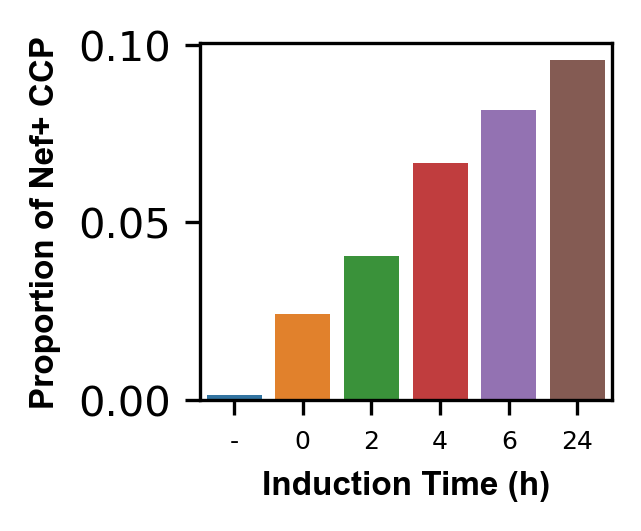

In [60]:
bx = plt.figure(figsize = (4.5/2.54,4/2.54), dpi=300)
bx = sns.barplot(data = df_master_nef_percentage, x = 'condition', y = 'nef_pos_fraction')

bx = plt.xlabel('Induction Time (h)', fontname = "Arial", fontsize = 8, fontweight = "bold")
bx = plt.ylabel('Proportion of Nef+ CCP', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2, 3, 4, 5]
catlabel = ['-', '0', '2', '4', '6', '24']
bx = plt.xticks(position, catlabel)
bx = plt.xticks(fontsize = 6)

# Analyzing Nef Positive Fraction, calculating fractions per cell

In [64]:
df_master_count = df_features_master.groupby(['cell_id', 'condition', 'nef_status']).agg(['count'])

In [66]:
df_master_count

lifetime max_ap2 max_dnm2 max_int_nef  \
                                      count   count    count       count   
cell_id       condition nef_status                                         
20210631-1-1  -1.0      0.0              17      17       17          17   
20210631-1-10 -1.0      0.0               9       9        9           9   
20210631-1-2  -1.0      0.0              12      12       12          12   
20210631-1-3  -1.0      0.0              25      25       25          25   
20210631-1-4  -1.0      0.0              20      20       20          20   
...                                     ...     ...      ...         ...   
20211015-9-6   2.0      1.0               1       1        1           1   
20211015-9-7   2.0      0.0              14      14       14          14   
20211015-9-8   2.0      0.0              25      25       25          25   
                        1.0               2       2        2           2   
20211015-9-9   2.0      0.0              34      34       34          34   

                                   dnm2_lifetime nef_lifetime exp_date  \
                                           count        count    count   
cell_id       condition nef_status                                       
20210631-1-1  -1.0      0.0                   17           17       17   
20210631-1-10 -1.0      0.0                    9            9        9   
20210631-1-2  -1.0      0.0                   12           12       12   
20210631-1-3  -1.0      0.0                   25           25       25   
20210631-1-4  -1.0      0.0                   20           20       20   
...                                          ...          ...      ...   
20211015-9-6   2.0      1.0                    1            1        1   
20211015-9-7   2.0      0.0                   14           14       14   
20211015-9-8   2.0      0.0                   25           25       25   
                        1.0                    2            2        2   
20211015-9-9   2.0      0.0                   34           34       34   

                                   dnm2_lifetime_gap nef_lifetime_gap  \
                                               count            count   
cell_id       condition nef_status                                      
20210631-1-1  -1.0      0.0                       17               17   
20210631-1-10 -1.0      0.0                        9                9   
20210631-1-2  -1.0      0.0                       12               12   
20210631-1-3  -1.0      0.0                       25               25   
20210631-1-4  -1.0      0.0                       20               20   
...                                              ...              ...   
20211015-9-6   2.0      1.0                        1                1   
20211015-9-7   2.0      0.0                       14               14   
20211015-9-8   2.0      0.0                       25               25   
                        1.0                        2                2   
20211015-9-9   2.0      0.0                       34               34   

                                   dnm2_first_detection nef_first_detection  
                                                  count               count  
cell_id       condition nef_status                                           
20210631-1-1  -1.0      0.0                          17                  11  
20210631-1-10 -1.0      0.0                           9                   4  
20210631-1-2  -1.0      0.0                          12                   5  
20210631-1-3  -1.0      0.0                          25                  14  
20210631-1-4  -1.0      0.0                          20                  13  
...                                                 ...                 ...  
20211015-9-6   2.0      1.0                           1                   1  
20211015-9-7   2.0      0.0                          14                  13  
20211015-9-8   2.0      0.0                         

In [67]:
percent_nef_positive_ctrl = []
percent_nef_positive_0h = []
percent_nef_positive_2h = []
percent_nef_positive_4h = []
percent_nef_positive_6h = []
percent_nef_positive_24h = []

cell_id = df_master_count.index.levels[0].tolist()

for row in range(len(cell_id)):
    
    condition = df_master_count.loc[(cell_id[row])].index.get_level_values(0)[0]
    
    if len(df_master_count.loc[(cell_id[row], slice(None))].iloc[:,0]) == 2:
        temp_nef_percentage = df_master_count.loc[(cell_id[row], slice(None))].iloc[:,0].tolist()
        temp_nef_percentage = (temp_nef_percentage[1]/(temp_nef_percentage[0] + temp_nef_percentage[1]))*100
        
    elif (df_master_count.loc[(cell_id[row])].index.get_level_values(1) == 0):
        temp_nef_percentage = 0
        
    else:
        temp_nef_percentage = 100
        
    if condition == -1:
        percent_nef_positive_ctrl.append(temp_nef_percentage)
        
    elif condition == 0:
        percent_nef_positive_0h.append(temp_nef_percentage)
        
    elif condition == 2:
        percent_nef_positive_2h.append(temp_nef_percentage)
        
    elif condition == 4:
        percent_nef_positive_4h.append(temp_nef_percentage)
        
    elif condition == 6:
        percent_nef_positive_6h.append(temp_nef_percentage)
        
    elif condition == 24:
        percent_nef_positive_24h.append(temp_nef_percentage)

In [69]:
df_percent_nef_positive_ctrl = pd.DataFrame({'Ctrl' : percent_nef_positive_ctrl})
df_percent_nef_positive_0h = pd.DataFrame({'0h' : percent_nef_positive_0h})
df_percent_nef_positive_2h = pd.DataFrame({'2h' : percent_nef_positive_2h})
df_percent_nef_positive_4h = pd.DataFrame({'4h' : percent_nef_positive_4h})
df_percent_nef_positive_6h = pd.DataFrame({'6h' : percent_nef_positive_6h})
df_percent_nef_positive_24h = pd.DataFrame({'24h' : percent_nef_positive_24h})

df_master_coloc = pd.concat([df_percent_nef_positive_ctrl, df_percent_nef_positive_0h, df_percent_nef_positive_2h, df_percent_nef_positive_4h, df_percent_nef_positive_6h, df_percent_nef_positive_24h], axis=1)

In [70]:
df_master_coloc

Ctrl         0h         2h         4h         6h        24h
0     0.0   0.000000  10.000000   0.000000   3.571429  30.303030
1     0.0   4.545455   5.882353   3.571429   5.000000   6.250000
2     0.0   7.407407   8.108108   7.692308   9.523810  10.526316
3     0.0   3.225806   3.225806   8.333333   0.000000   5.263158
4     0.0   4.166667  11.111111  10.714286  13.333333  13.636364
..    ...        ...        ...        ...        ...        ...
164   NaN   4.166667        NaN        NaN        NaN        NaN
165   NaN   0.000000        NaN        NaN        NaN        NaN
166   NaN   5.714286        NaN        NaN        NaN        NaN
167   NaN  11.111111        NaN        NaN        NaN        NaN
168   NaN   0.000000        NaN        NaN        NaN        NaN

[169 rows x 6 columns]

In [71]:
df_master_coloc.to_excel("output.xlsx") 

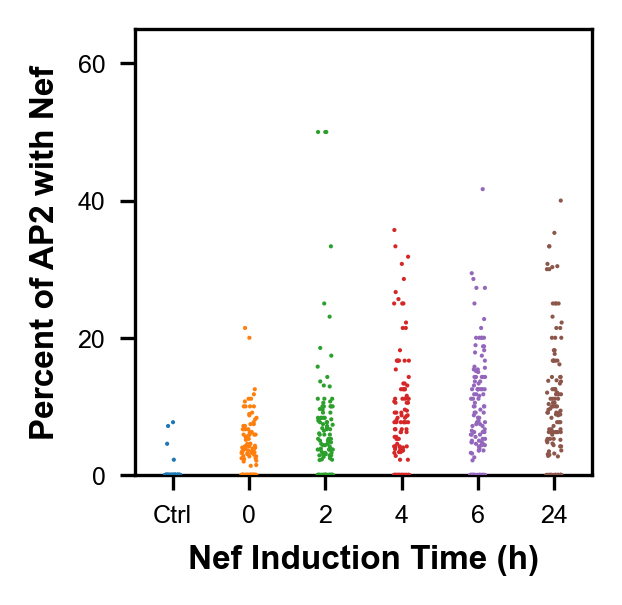

In [82]:
ax = plt.figure(figsize = (5/2.54 , 5/2.54), dpi=300)
ax = sns.stripplot(data = df_master_coloc, size = 1)
ax = plt.ylim(bottom= 0, top=65)
ax = plt.xlabel('Nef Induction Time (h)', fontname = "Arial", fontsize = 8, fontweight = "bold")
ax = plt.ylabel('Percent of AP2 with Nef', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2, 3, 4, 5]
catlabel = ['Ctrl', '0', '2', '4', '6', '24']
ax = plt.xticks(position, catlabel)
ax = plt.xticks(fontname = "Arial", fontsize = 6)
ax = plt.yticks(fontname = "Arial", fontsize = 6)



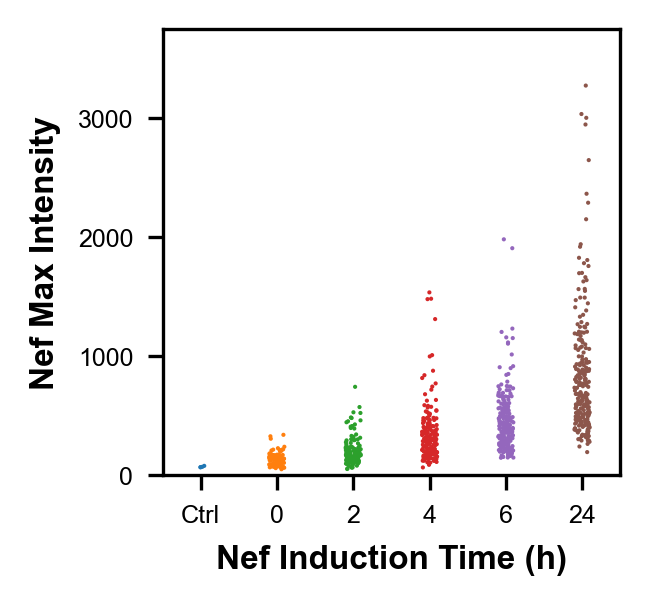

In [84]:
ax = plt.figure(figsize = (5/2.54 , 5/2.54), dpi=300)
ax = sns.stripplot(data = df_features_master[(df_features_master['nef_status'] == 1)], x = 'condition', y = 'max_int_nef', size = 1)
ax = plt.ylim(bottom= 0, top=3750)
ax = plt.xlabel('Nef Induction Time (h)', fontname = "Arial", fontsize = 8, fontweight = "bold")
ax = plt.ylabel('Nef Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2, 3, 4, 5]
catlabel = ['Ctrl', '0', '2', '4', '6', '24']
ax = plt.xticks(position, catlabel)
ax = plt.xticks(fontname = "Arial", fontsize = 6)
ax = plt.yticks(fontname = "Arial", fontsize = 6)

  

# Nef dynamics

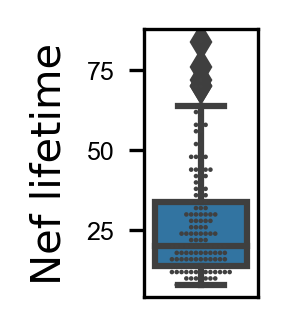

In [57]:
sub_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)].sample(n=150, random_state=1)
df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)]

ax = plt.figure(figsize = (1.25/2.54 , 3/2.54), dpi=300)
ax = sns.swarmplot(data=sub_df, y = 'nef_lifetime', size = 0.5, color = '0.8', edgecolor = '0.25', linewidth = 0.6)
ax = sns.boxplot(data=df, y = 'nef_lifetime')

ax.set(xlabel=None, ylabel='Nef lifetime') 
ax.tick_params(bottom=False)
ax = plt.yticks(fontname = "Arial", fontsize = 6)

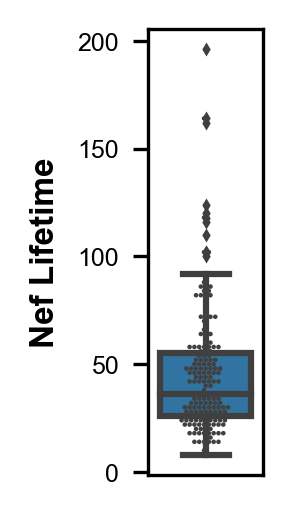

In [61]:
sub_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)].sample(n=150, random_state=1)
df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)]

ax = plt.figure(figsize = (1.25/2.54 , 5/2.54), dpi=300)
ax = sns.swarmplot(data=df, y = 'nef_lifetime_gap', size = 0.5, color = '0.8', edgecolor = '0.25', linewidth = 0.6)
ax = sns.boxplot(data=df, y = 'nef_lifetime_gap', fliersize = 1)

plt.yticks(fontname = "Arial", fontsize = 6)
plt.ylabel('Nef Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
ax.tick_params(bottom=False)

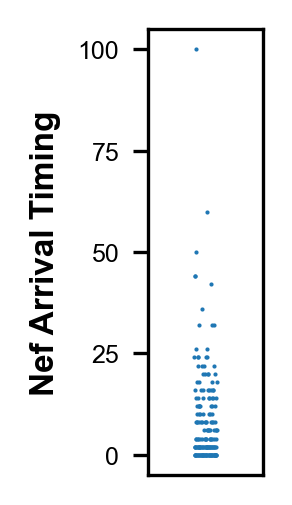

In [98]:
#sub_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)].sample(n=150, random_state=1)
df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)]

ax = plt.figure(figsize = (1.25/2.54 , 5/2.54), dpi=300)
#ax = sns.swarmplot(data=sub_df, y = 'nef_first_detection', size = 0.5, color = '0.8', edgecolor = '0.25', linewidth = 0.6)
ax = sns.stripplot(data=df, y = 'nef_first_detection', size = 1)

#ax.set(ylim = [0, 30])
plt.yticks(fontname = "Arial", fontsize = 6)
plt.ylabel('Nef Arrival Timing', fontname = "Arial", fontsize = 8, fontweight = "bold")
ax.set(xlabel=None, ylabel='Nef Arrival Timing') 
ax.tick_params(bottom=False)

In [99]:
nef_pos_4h_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)]
print(np.mean(nef_pos_4h_df['nef_first_detection'].values))
print(np.std(nef_pos_4h_df['nef_first_detection'].values))

8.994413407821229
12.539767894417096


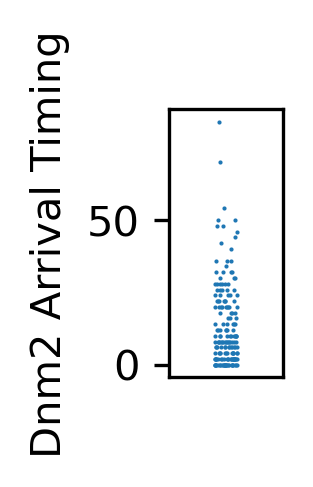

In [100]:
#sub_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)].sample(n=150, random_state=1)
df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)]

ax = plt.figure(figsize = (1.25/2.54 , 3/2.54), dpi=300)
#ax = sns.swarmplot(data=sub_df, y = 'nef_first_detection', size = 0.5, color = '0.8', edgecolor = '0.25', linewidth = 0.6)
ax = sns.stripplot(data=df, y = 'dnm2_first_detection', size = 1)

#ax.set(ylim = [0, 30])
ax.set(xlabel=None, ylabel='Dnm2 Arrival Timing') 
ax.tick_params(bottom=False)

In [101]:
nef_pos_4h_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)]
print(np.mean(nef_pos_4h_df['dnm2_first_detection'].values))
print(np.std(nef_pos_4h_df['dnm2_first_detection'].values))

13.374301675977653
14.341782103274976


In [129]:
nef_neg_4h_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==0)]
print(np.mean(nef_neg_4h_df['dnm2_first_detection'].values))
print(np.std(nef_neg_4h_df['dnm2_first_detection'].values))

10.197205588822355
12.018126370310108


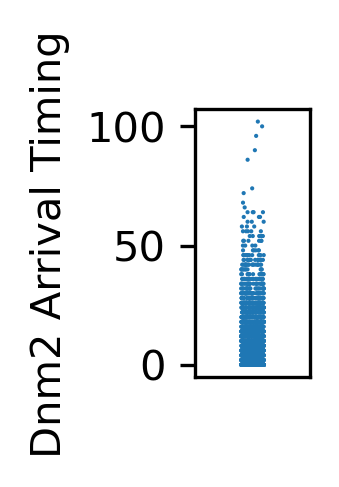

In [106]:
#sub_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)].sample(n=150, random_state=1)
df = df_features_master[(df_features_master['condition'] == -1)]

ax = plt.figure(figsize = (1.25/2.54 , 3/2.54), dpi=300)
#ax = sns.swarmplot(data=sub_df, y = 'nef_first_detection', size = 0.5, color = '0.8', edgecolor = '0.25', linewidth = 0.6)
ax = sns.stripplot(data=df, y = 'dnm2_first_detection', size = 1)

#ax.set(ylim = [0, 30])
ax.set(xlabel=None, ylabel='Dnm2 Arrival Timing') 
ax.tick_params(bottom=False)

In [130]:
ctrl_df = df_features_master[(df_features_master['condition'] == -1)]
print(np.mean(ctrl_df['dnm2_first_detection'].values))
print(np.std(ctrl_df['dnm2_first_detection'].values))

10.604651162790697
12.25893849609623


In [114]:
df2

Dnm2_Arrival  Dnm2 Arrival
0            NaN           0.0
1            NaN           8.0
2            NaN          22.0
3            NaN           2.0
4            NaN          10.0
..           ...           ...
174          NaN           4.0
175          NaN          28.0
176          NaN          24.0
177          NaN           2.0
178          NaN           2.0

[179 rows x 2 columns]

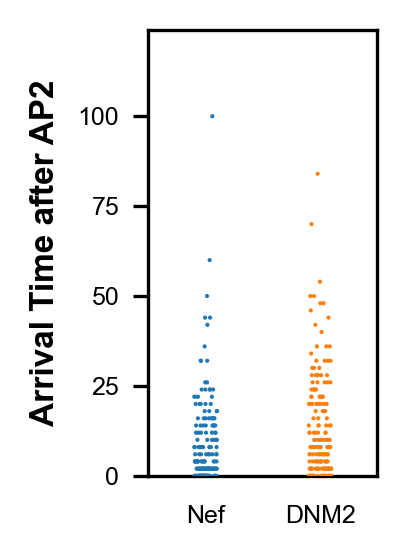

In [117]:
#sub_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status']==1)].sample(n=150, random_state=1)
df1 = pd.DataFrame(columns = ['Nef Arrival'])
df1['Nef Arrival'] = nef_pos_4h_df['nef_first_detection'].values
df2 = pd.DataFrame(columns = ['Dnm2 Arrival'])
df2['Dnm2 Arrival'] = nef_pos_4h_df['dnm2_first_detection'].values

df3 = pd.concat([df1, df2], axis = 1)

ax = plt.figure(figsize = (2.5/2.54 , 5/2.54), dpi=300)
ax = sns.stripplot(data=df3, size = 1)

ax.set(ylim = [0, 124])
position = [0, 1]
catlabel = ['Nef', 'DNM2']
plt.xticks(position, catlabel)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
plt.ylabel('Arrival Time after AP2', fontname = "Arial", fontsize = 8, fontweight = "bold")
ax.tick_params(bottom=False)

In [116]:
_, p_4h_pos_nef_dnm2 = stats.mannwhitneyu(x = nef_pos_4h_df['nef_first_detection'].values, y = nef_pos_4h_df['dnm2_first_detection'].values, use_continuity = False)

print("nef arrival vs dnm2 arrival")
print(p_4h_pos_nef_dnm2)


nef arrival vs dnm2 arrival
0.00022540527973725113


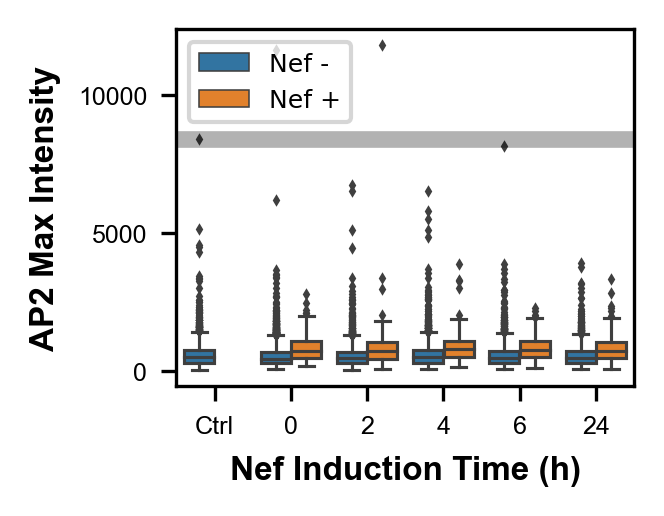

In [107]:
plt.figure(figsize = (5/2.54,4/2.54), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='max_ap2', dodge=True, hue = 'nef_status', linewidth = 0.75, fliersize = 0.75, whis = 1.5)
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Nef Induction Time (h)', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2, 3, 4, 5]
catlabel = ['Ctrl', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
plt.axhline(8400, linewidth = 4, color = (0,0,0,0.3))

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left', fontsize = 6)

#ax.set(ylim = [0,3000])

[(0.0, 3000.0)]

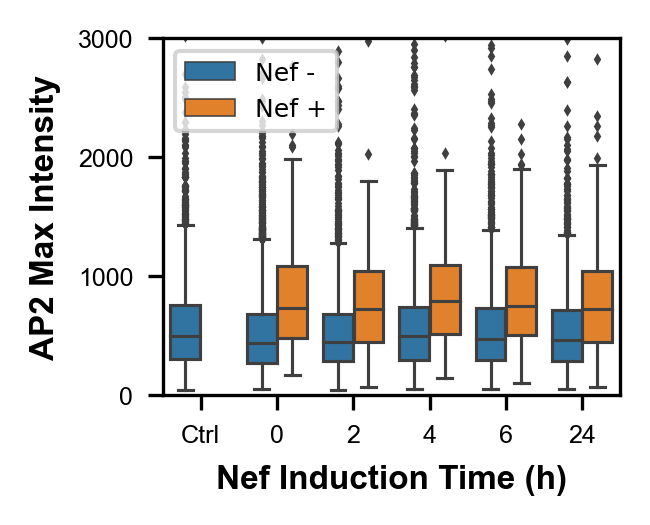

In [104]:
plt.figure(figsize = (5/2.54,4/2.54), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='max_ap2', dodge=True, hue = 'nef_status', linewidth = 0.75, fliersize = 0.75, whis = 1.5)
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Nef Induction Time (h)', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2, 3, 4, 5]
catlabel = ['Ctrl', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
plt.axhline(8400, linewidth = 4, color = (0,0,0,0.3))

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left', fontsize = 6)

ax.set(ylim = [0,3000])

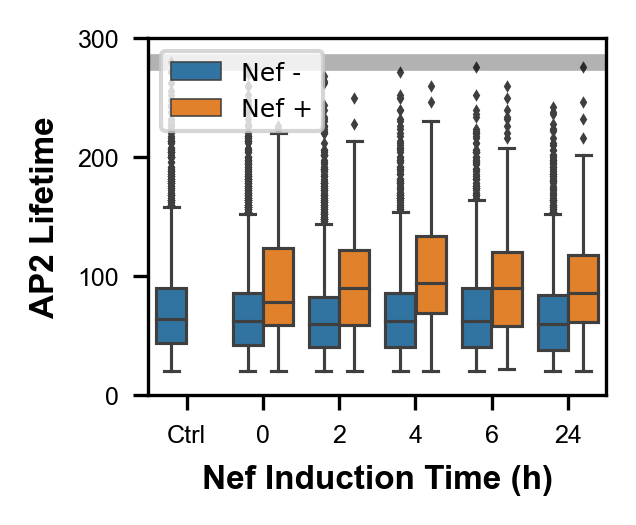

In [105]:
plt.figure(figsize = (5/2.54,4/2.54), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='lifetime', dodge=True, hue = 'nef_status', linewidth = 0.75, fliersize = 0.75)
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Nef Induction Time (h)', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2, 3, 4, 5]
catlabel = ['Ctrl', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
plt.axhline(280, linewidth = 4, color = (0,0,0,0.3))
ax.set(ylim = [0,300])

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left', fontsize = 6)


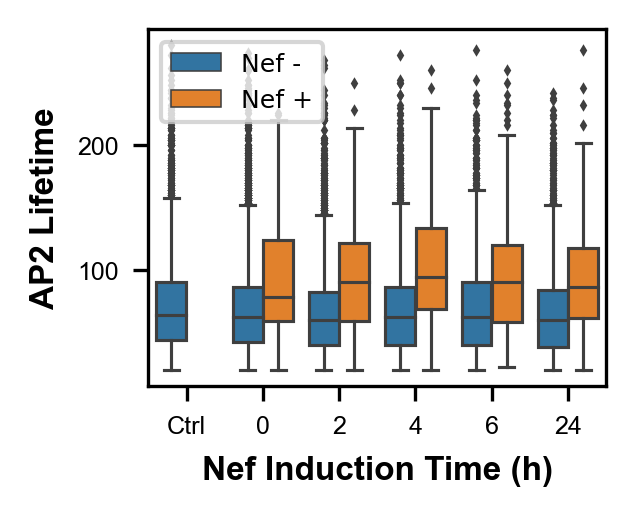

In [106]:
plt.figure(figsize = (5/2.54,4/2.54), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='lifetime', dodge=True, hue = 'nef_status', linewidth = 0.75, fliersize = 0.75)
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Nef Induction Time (h)', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2, 3, 4, 5]
catlabel = ['Ctrl', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#plt.axhline(280, linewidth = 4, color = (0,0,0,0.3))
#ax.set(ylim = [0,300])

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left', fontsize = 6)


# Analyzing AP2, DNM2, and Nef dynamics in Jurkat cells

Text(0, 0.5, 'Cumulative Distribution')

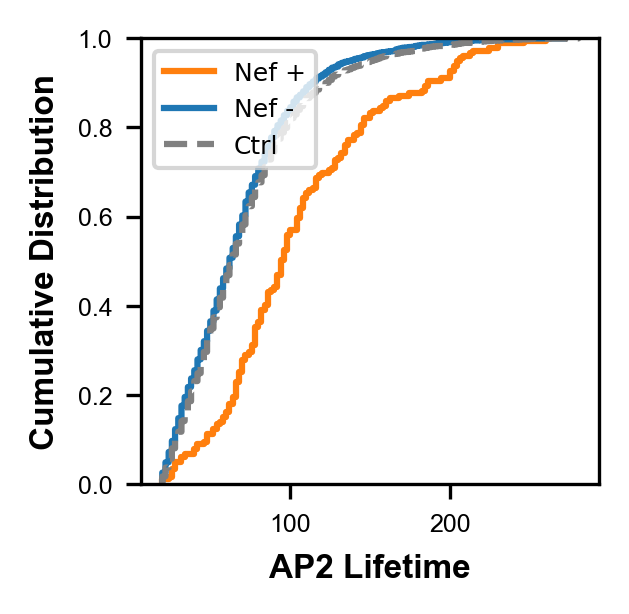

In [62]:
#Base code for CDF. 4 hour induction of Nef condition Specifically for AP2 lifetime
sub_df = df_features_master[df_features_master['condition'] == 4]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'lifetime', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'lifetime', color = '0.5', linestyle="dashed")

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Cumulative Distribution', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Cumulative Distribution')

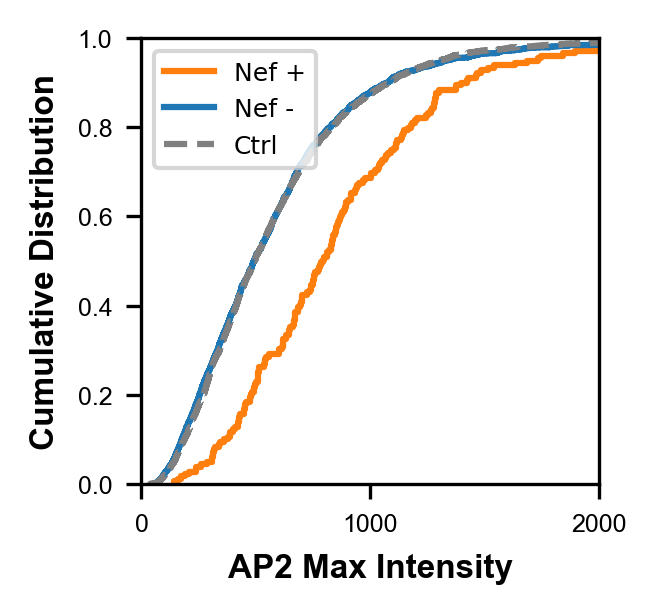

In [63]:
#Base code for CDF. 4 hour induction of Nef condition Specifically for AP2 Max Int
sub_df = df_features_master[df_features_master['condition'] == 4]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'max_ap2', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'max_ap2', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,2000])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Cumulative Distribution', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

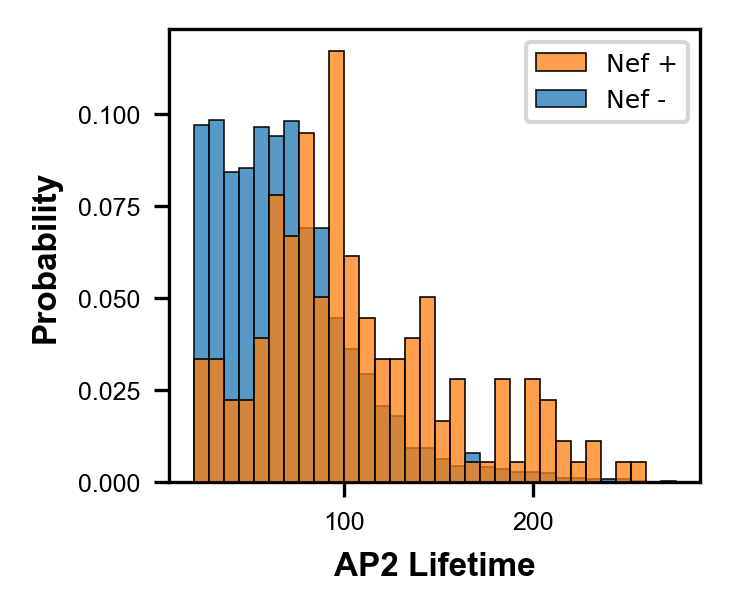

In [118]:
#Generating lifetime histogram for valid filtered set
ax = plt.figure(figsize = (5.8/2.54,5/2.5), dpi=300)
ax = sns.histplot(data=df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 4)], x = 'lifetime', stat = 'probability', color = 'C1', binwidth = 8, zorder = 10)
ax = sns.histplot(data=df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 4)], x = 'lifetime', stat = 'probability', binwidth = 8)


ax = plt.legend(title=None, loc='upper right', labels=['Nef +', 'Nef -'], fontsize = 6)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

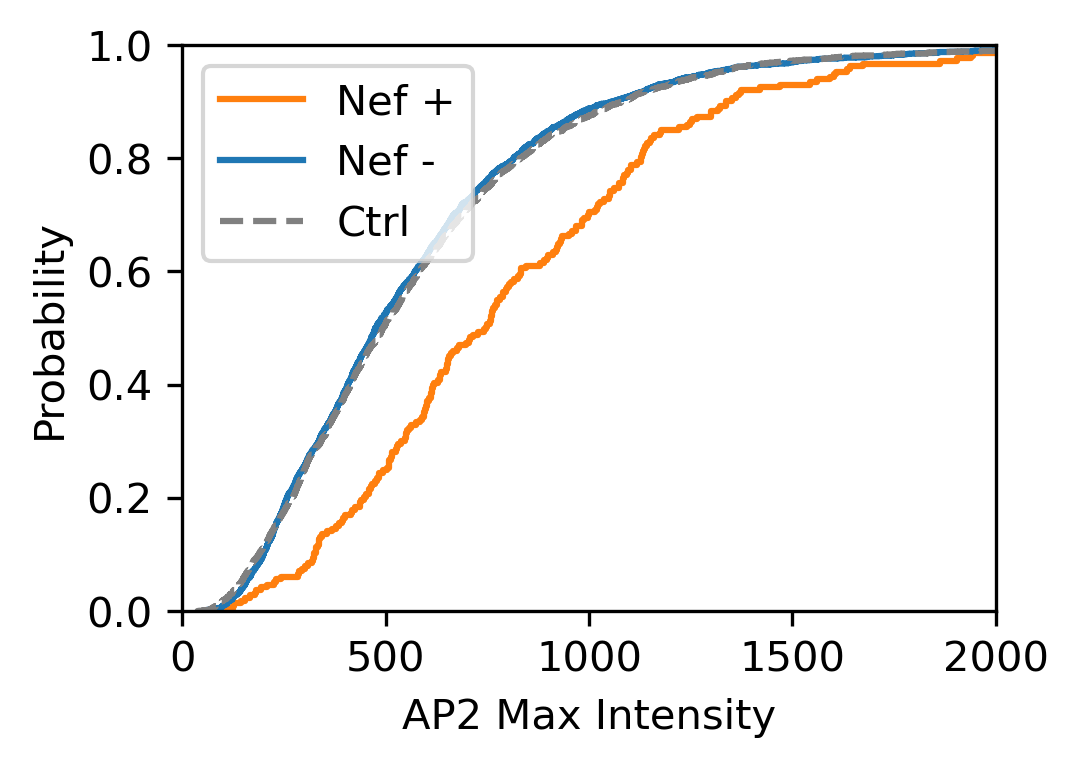

In [101]:
#Base code for CDF. 6 hour induction of Nef condition Specifically for AP2 max intensity
sub_df = df_features_master[df_features_master['condition'] == 6]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'max_ap2', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'max_ap2', color = '0.5', linestyle="dashed")

ax.set(xlabel='AP2 Max Intensity', ylabel='Probability') 
ax.set(xlim = [0,2000])
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'])

Text(0, 0.5, 'Cumulative Distribution')

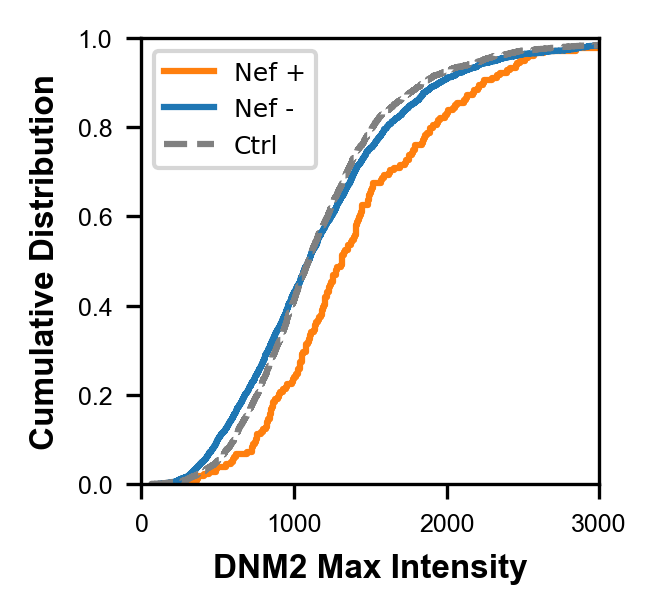

In [64]:
#Base code for CDF. 4 hour induction of Nef condition Specifically for DNM2 max intensity
sub_df = df_features_master[df_features_master['condition'] == 4]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'max_dnm2', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'max_dnm2', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,3000])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('DNM2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Cumulative Distribution', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Cumulative Distribution')

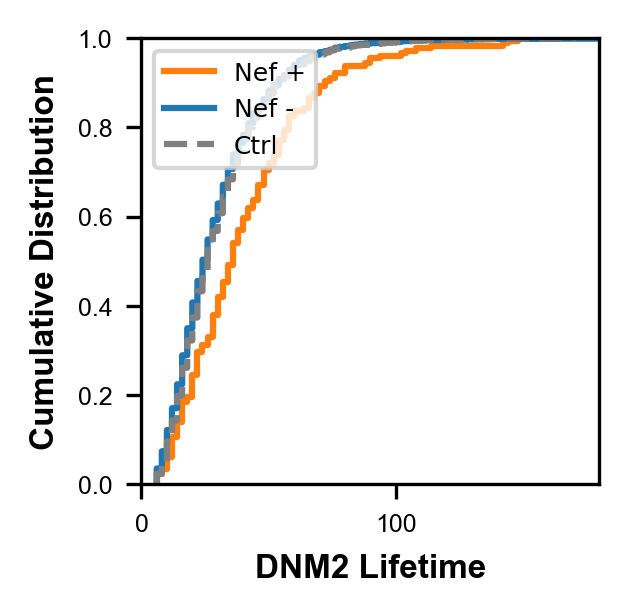

In [65]:
#Base code for CDF. 4 hour induction of Nef condition Specifically for DNM2 Lifetime
sub_df = df_features_master[df_features_master['condition'] == 4]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'dnm2_lifetime', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'dnm2_lifetime', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,180])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('DNM2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Cumulative Distribution', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

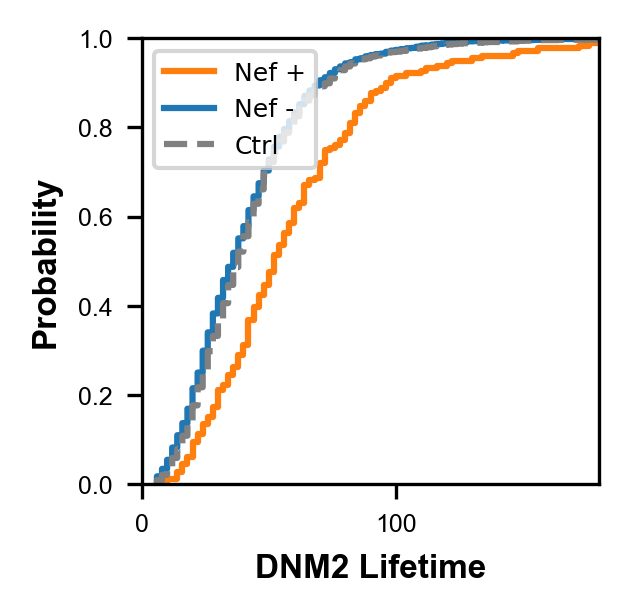

In [128]:
#Base code for CDF. 4 hour induction of Nef condition Specifically for DNM2 Lifetime
sub_df = df_features_master[df_features_master['condition'] == 4]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'dnm2_lifetime_gap', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'dnm2_lifetime_gap', color = '0.5', linestyle="dashed")
ax.set(xlim = [0,180])

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('DNM2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

In [69]:
#Base code for CDF. 6 hour induction of Nef condition Specifically for DNM2 lifetime
sub_df = df_features_master[df_features_master['condition'] == 4]
ref_df = df_features_master[df_features_master['condition'] == -1]

ax = plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'max_consecutive_ch2', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'max_consecutive_ch2', color = '0.5', linestyle="dashed")

ax.set(xlabel='DNM2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'])

ValueError: Could not interpret value `max_consecutive_ch2` for parameter `x`

<Figure size 1050x750 with 0 Axes>

Text(0, 0.5, 'AP2 Max Intensity')

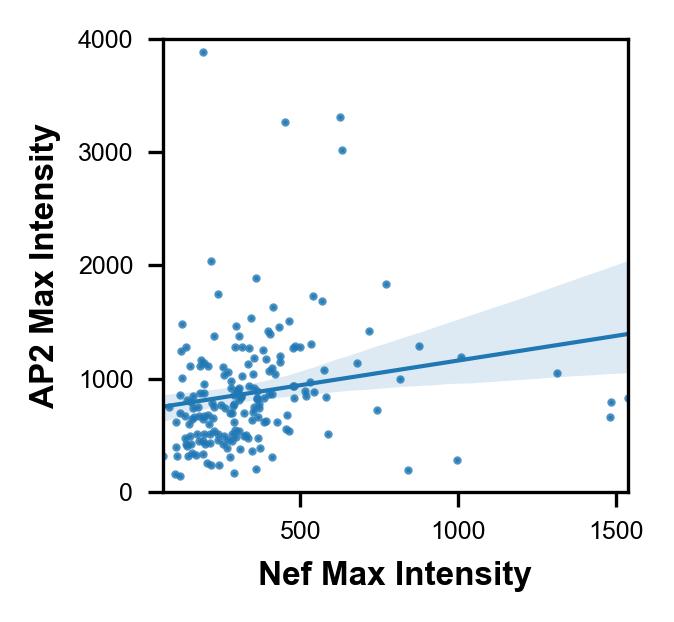

In [70]:
#Relating Nef amount to AP2 amount
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)
ax = sns.regplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)], x = 'max_int_nef', y = 'max_ap2', color = 'C0', line_kws={'linewidth':1}, scatter_kws={'s':1})
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
ax.set(ylim = [0, 4000])

plt.xlabel('Nef Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'AP2 Lifetime')

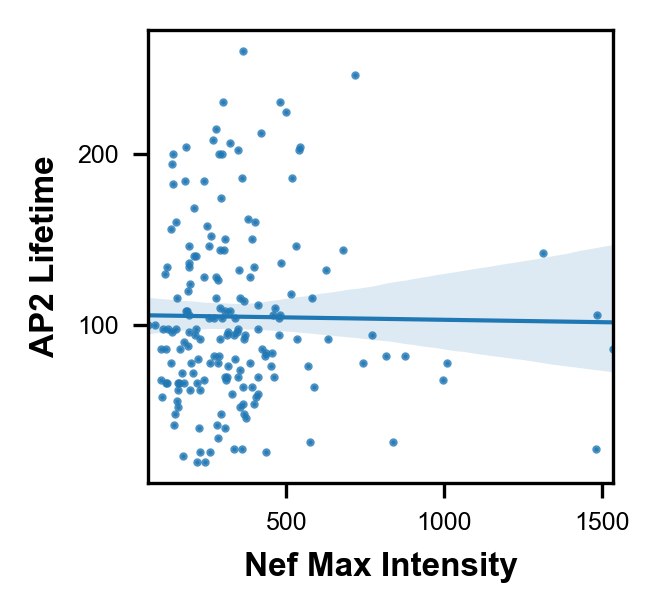

In [71]:
#Relating Nef amount to AP2 lifetime
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)
ax = sns.regplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)], x = 'max_int_nef', y = 'lifetime', color = 'C0', line_kws={'linewidth':1}, scatter_kws={'s':1})
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#ax.set(ylim = [0, 4000])

plt.xlabel('Nef Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")

In [61]:
nef_pos_4h_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)]
slope, intercept, r_value, p_value, std_err = stats.linregress(nef_pos_4h_df['max_ap2'].values, nef_pos_4h_df['max_int_nef'])

print('p_value')
print(p_value)
print('r_squared')
print(r_value**2)
print('slope')
print(slope)

p_value
0.009419625701758123
r_squared
0.03747465130375111
slope
0.0859681315068888


In [62]:
nef_pos_4h_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)]
slope, intercept, r_value, p_value, std_err = stats.linregress(nef_pos_4h_df['lifetime'].values, nef_pos_4h_df['max_int_nef'])

print('p_value')
print(p_value)
print('r_squared')
print(r_value**2)
print('slope')
print(slope)

p_value
0.8629739090234055
r_squared
0.0001687512059296583
slope
-0.06055275216031318


Text(0, 0.5, 'AP2 Lifetime')

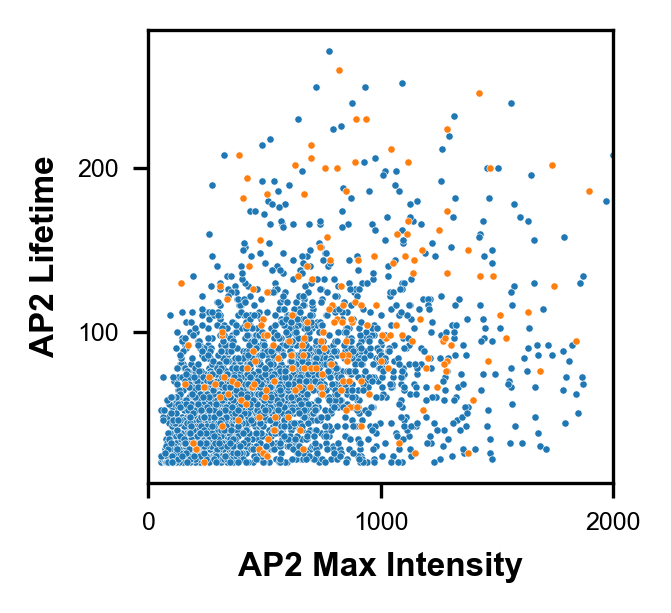

In [65]:
#Relating AP2 amount to AP2 lifetime
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)

#ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == -1)], x = 'max_ap2', y = 'lifetime', color = 'C2', s = 3, legend = False)
ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 0)], x = 'max_ap2', y = 'lifetime', color = 'C0', s = 3, legend = False)
ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)], x = 'max_ap2', y = 'lifetime', color = 'C1', s = 3, legend = False)
ax.set(xlim = [0, 2000])
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#ax.set(ylim = [0,2500])
plt.xlabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")

#plt.xscale("log")
#plt.yscale("log")

Text(0, 0.5, 'DNM2 Lifetime')

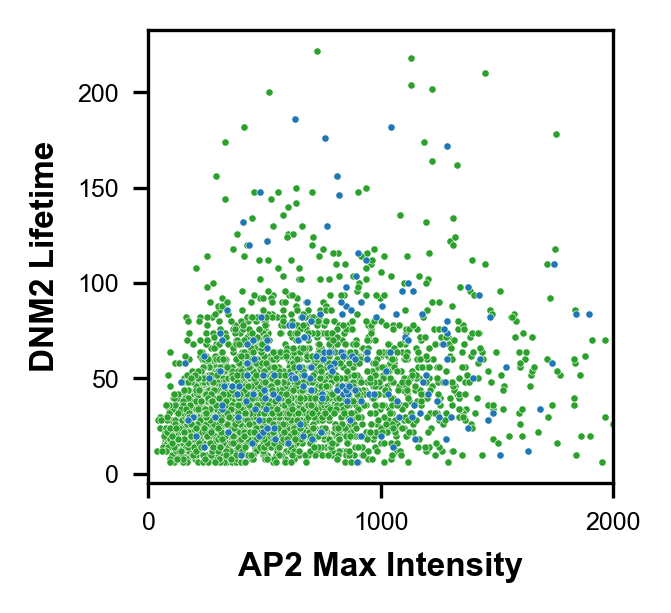

In [90]:
#Relating AP2 amount to AP2 lifetime
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)

ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == -1)], x = 'max_ap2', y = 'dnm2_lifetime_gap', color = 'C2', s = 3, legend = False)
#ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 0)], x = 'max_ap2', y = 'lifetime', color = 'C1', s = 3, legend = False)
ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)], x = 'max_ap2', y = 'dnm2_lifetime_gap', color = 'C0', s = 3, legend = False)
ax.set(xlim = [0, 2000])
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#ax.set(ylim = [0,2500])
plt.xlabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('DNM2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'DNM2 Max Intensity')

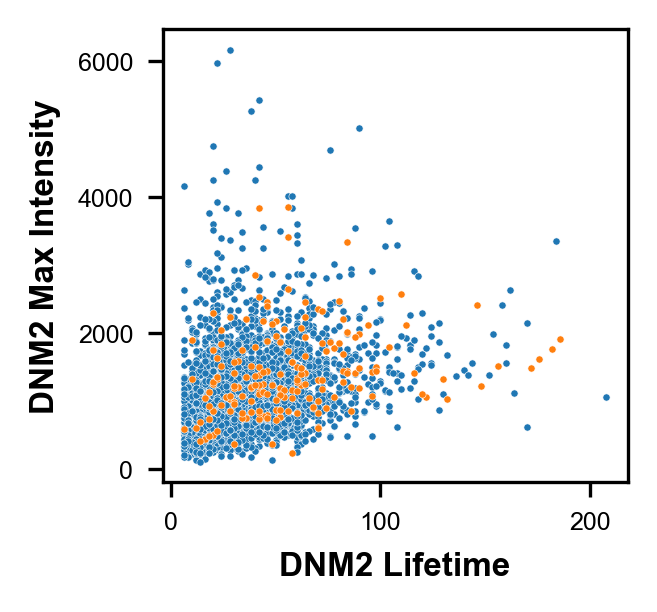

In [64]:
#Relating DNM2 lifetime to DNM2 Max Intensity
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)

#ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == -1)], x = 'dnm2_lifetime_gap', y = 'max_dnm2', color = 'C2', s = 3, legend = False)
ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 0)], x = 'dnm2_lifetime_gap', y = 'max_dnm2', color = 'C0', s = 3, legend = False)
ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)], x = 'dnm2_lifetime_gap', y = 'max_dnm2', color = 'C1', s = 3, legend = False)
#ax.set(xlim = [0, 2000])
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#ax.set(ylim = [0,2500])
plt.xlabel('DNM2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('DNM2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")


#plt.xscale("log")
#plt.yscale("log")

Text(0, 0.5, 'Nef Lifetime')

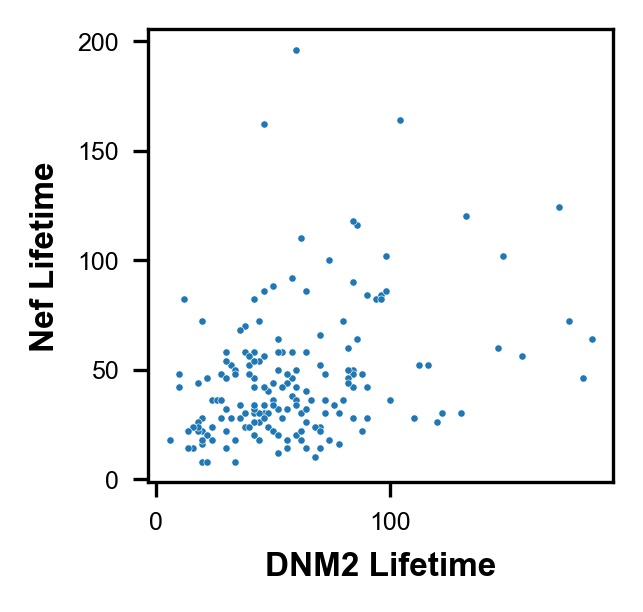

In [83]:
#Relating DNM2 lifetime to Nef lifetime
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)

#ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == -1)], x = 'dnm2_lifetime_gap', y = 'nef_lifetime_gap', color = 'C2', s = 3, legend = False)
#ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 0)], x = 'max_ap2', y = 'lifetime', color = 'C1', s = 3, legend = False)
ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)], x = 'dnm2_lifetime_gap', y = 'nef_lifetime_gap', color = 'C0', s = 3, legend = False)
#ax.set(xlim = [0, 2000])
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#ax.set(ylim = [0,2500])
plt.xlabel('DNM2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Nef Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")


#plt.xscale("log")
#plt.yscale("log")

Text(0, 0.5, 'AP2 Lifetime')

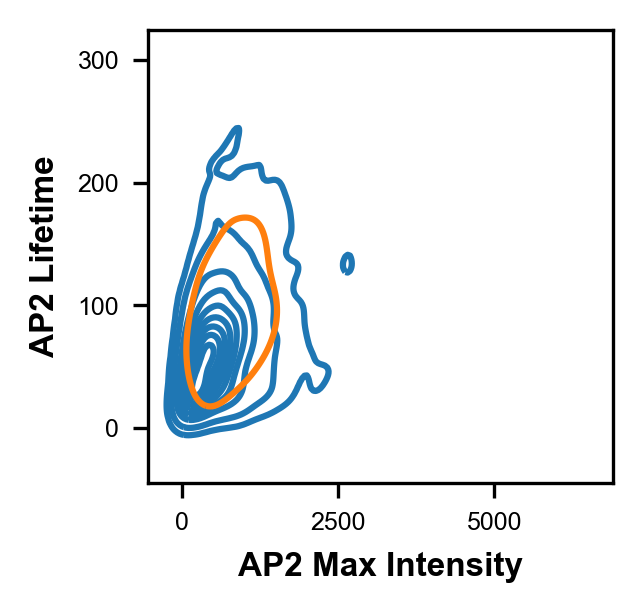

In [109]:
#Relating AP2 amount to AP2 lifetime
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)

ax = sns.kdeplot(data=df_features_master[(df_features_master['condition'] == 4)], x = 'max_ap2', y = 'lifetime', hue = 'nef_status', fill = False, legend = False)
#ax = sns.kdeplot(data=df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)], x = 'max_ap2', y = 'lifetime', color = 'C0', fill = True, legend = False)
#ax.set(xlim = [0, 2000])
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#ax.set(ylim = [0,2500])
plt.xlabel('AP2 Max Intensity', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")

# Scatterplot for ctrl cme parameter correlation

p_value
0.014227319028138386
r_squared
0.033475828017342106
slope
1.920469529740954


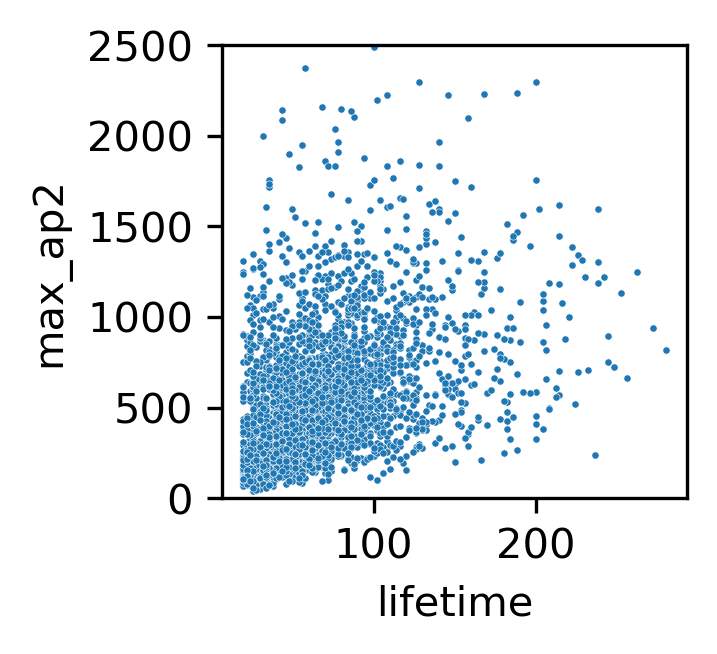

In [100]:
#Relating AP2 lifetime to AP2 max intensity
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)
ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == -1)], x = 'lifetime', y = 'max_ap2', color = 'C0', s = 3, legend = False)

ax.set(ylim = [0,2500])
#ax.set(xlim = [0, 2500])

ctrl_df = df_features_master[(df_features_master['condition'] == -1)]
slope, intercept, r_value, p_value, std_err = stats.linregress(nef_pos_4h_df['lifetime'].values, nef_pos_4h_df['max_ap2'])

print('p_value')
print(p_value)
print('r_squared')
print(r_value**2)
print('slope')
print(slope)

p_value
3.4489938515513595e-25
r_squared
0.45610994053703435
slope
0.4486035711981033


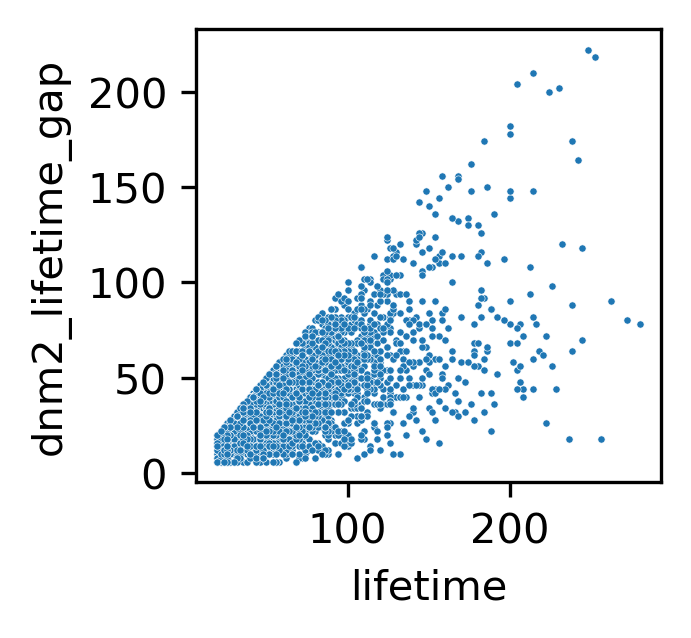

In [97]:
#Relating AP2 lifetime to DNM2 lifetime
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)
ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == -1)], x = 'lifetime', y = 'dnm2_lifetime_gap', color = 'C0', s = 3, legend = False)

#ax.set(ylim = [0,200])
#ax.set(xlim = [0, 2500])

ctrl_df = df_features_master[(df_features_master['condition'] == -1)]
slope, intercept, r_value, p_value, std_err = stats.linregress(nef_pos_4h_df['lifetime'].values, nef_pos_4h_df['dnm2_lifetime_gap'])

print('p_value')
print(p_value)
print('r_squared')
print(r_value**2)
print('slope')
print(slope)

p_value
0.0014836255227854214
r_squared
0.05561015878518336
slope
2.8970616778538436


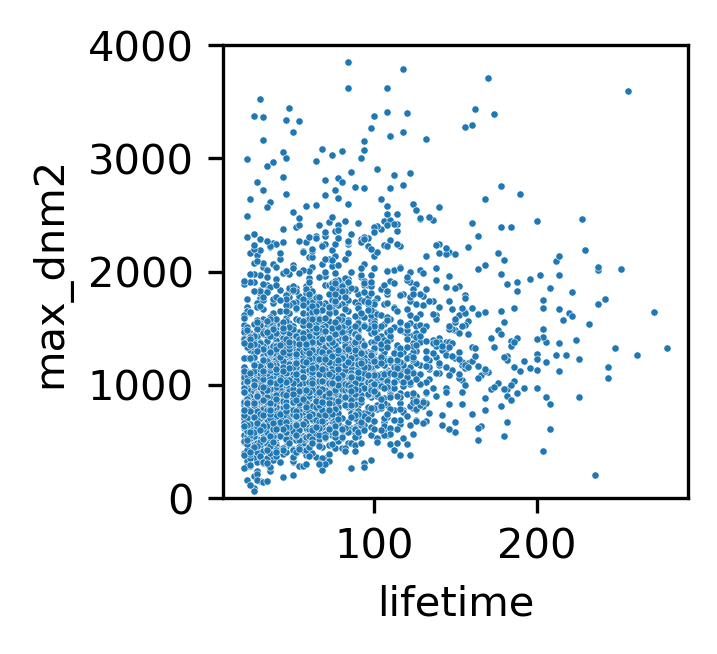

In [95]:
#Relating AP2 lifetime to DNM2 max intensity
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)
ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == -1)], x = 'lifetime', y = 'max_dnm2', color = 'C0', s = 3, legend = False)

ax.set(ylim = [0,4000])
#ax.set(xlim = [0, 2500])

ctrl_df = df_features_master[(df_features_master['condition'] == -1)]
slope, intercept, r_value, p_value, std_err = stats.linregress(nef_pos_4h_df['lifetime'].values, nef_pos_4h_df['max_dnm2'])

print('p_value')
print(p_value)
print('r_squared')
print(r_value**2)
print('slope')
print(slope)

p_value
0.0018878786419388536
r_squared
0.053234959913554585
slope
4.26728040638735


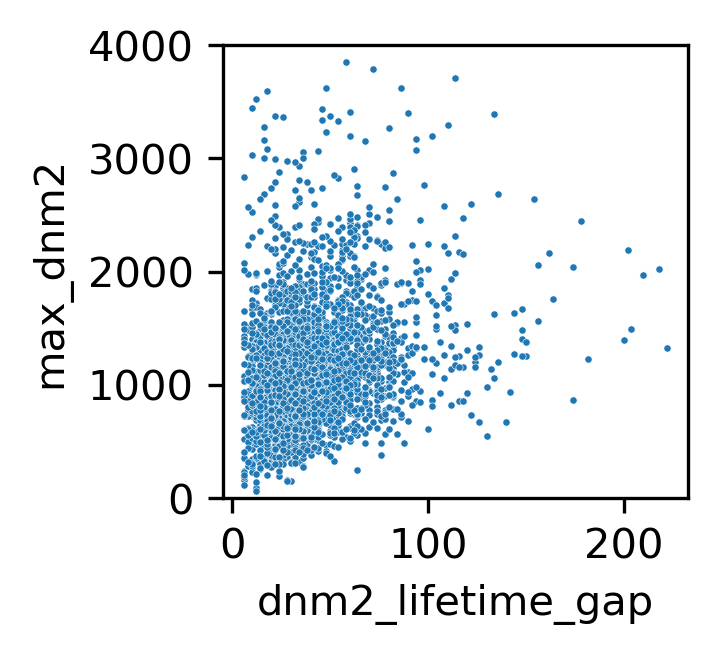

In [93]:
#Relating DNM2 lifetime to DNM2 max intensity
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)
ax = sns.scatterplot(data=df_features_master[(df_features_master['condition'] == -1)], x = 'dnm2_lifetime_gap', y = 'max_dnm2', color = 'C0', s = 3, legend = False)

ax.set(ylim = [0,4000])
#ax.set(xlim = [0, 2500])

ctrl_df = df_features_master[(df_features_master['condition'] == -1)]
slope, intercept, r_value, p_value, std_err = stats.linregress(nef_pos_4h_df['dnm2_lifetime_gap'].values, nef_pos_4h_df['max_dnm2'])

print('p_value')
print(p_value)
print('r_squared')
print(r_value**2)
print('slope')
print(slope)

# Evaluating Productivity of Nef+ spots

Text(0, 0.5, 'Probability')

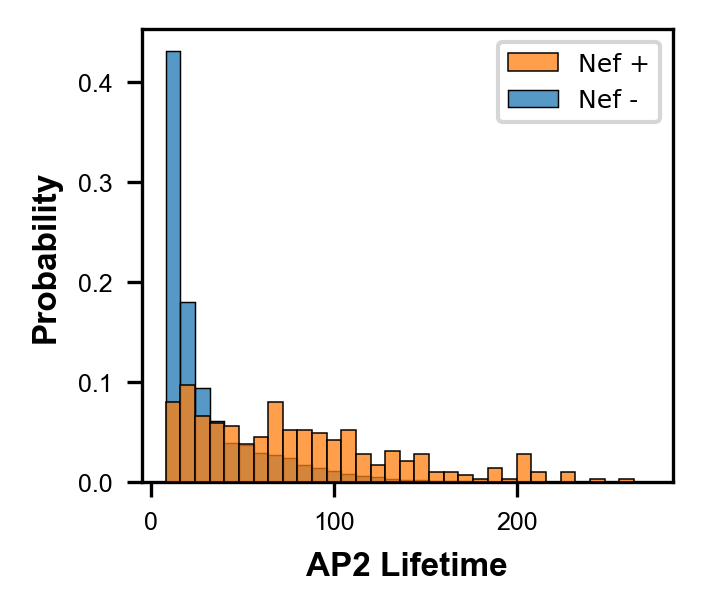

In [79]:
#Generating lifetime histogram for valid set (The graphs below do are not filtered using AP2 displacement, lifetime restrictions, etc.)
ax = plt.figure(figsize = (5.8/2.54,5/2.5), dpi=300)
ax = sns.histplot(data=nodnm2_df_features_master[(nodnm2_df_features_master['nef_status'] == 1) & (nodnm2_df_features_master['condition'] == 4)], x = 'lifetime', stat = 'probability', color = 'C1', binwidth = 8, zorder = 10)
ax = sns.histplot(data=nodnm2_df_features_master[(nodnm2_df_features_master['nef_status'] == 0) & (nodnm2_df_features_master['condition'] == 4) & (nodnm2_df_features_master['lifetime'] >= 8)], x = 'lifetime', stat = 'probability', binwidth = 8)


ax = plt.legend(title=None, loc='upper right', labels=['Nef +', 'Nef -'], fontsize = 6)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Cumulative Distribution')

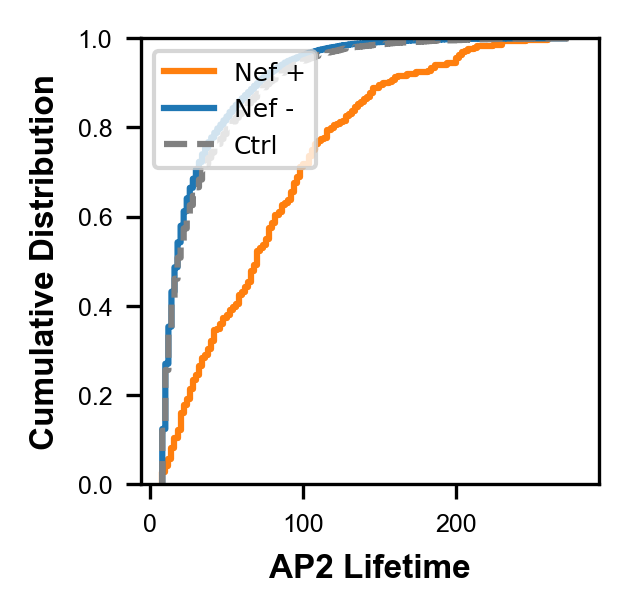

In [118]:
#Base code for CDF. 4 hour induction of Nef condition Specifically for AP2 lifetime
sub_df = nodnm2_df_features_master[(nodnm2_df_features_master['condition'] == 4) & (nodnm2_df_features_master['lifetime'] >= 8)]
ref_df = nodnm2_df_features_master[(nodnm2_df_features_master['condition'] == -1) & (nodnm2_df_features_master['lifetime'] >= 8)]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'lifetime', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'lifetime', color = '0.5', linestyle="dashed")

#ax.set(xlabel='AP2 Lifetime', ylabel='Probability') 
ax = plt.legend(title=None, loc='upper left', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Cumulative Distribution', fontname = "Arial", fontsize = 8, fontweight = "bold")

In [181]:
dnm2_neg_4h_pos = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] <= 6) & (nodnm2_df_features_master['condition'] == 4) & (nodnm2_df_features_master['nef_status'] == 1) & (nodnm2_df_features_master['lifetime'] >= 8)]
dnm2_pos_4h_pos = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] > 6) & (nodnm2_df_features_master['condition'] == 4) & (nodnm2_df_features_master['nef_status'] == 1) & (nodnm2_df_features_master['lifetime'] >= 8)]
dnm2_neg_4h_neg = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] <= 6) & (nodnm2_df_features_master['condition'] == 4) & (nodnm2_df_features_master['nef_status'] == 0) & (nodnm2_df_features_master['lifetime'] >= 8)]
dnm2_pos_4h_neg = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] > 6) & (nodnm2_df_features_master['condition'] == 4) & (nodnm2_df_features_master['nef_status'] == 0) & (nodnm2_df_features_master['lifetime'] >= 8)]
dnm2_neg_ctrl = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] <= 6) & (nodnm2_df_features_master['condition'] == -1) & (nodnm2_df_features_master['lifetime'] >= 8)]
dnm2_pos_ctrl = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] > 6) & (nodnm2_df_features_master['condition'] == -1) & (nodnm2_df_features_master['lifetime'] >= 8)]

In [190]:
dnm2_pos_ratio_4h_pos = len(dnm2_pos_4h_pos)/(len(dnm2_pos_4h_pos) + len(dnm2_neg_4h_pos))
dnm2_pos_ratio_4h_neg = len(dnm2_pos_4h_neg)/(len(dnm2_pos_4h_neg) + len(dnm2_neg_4h_neg))
dnm2_pos_ratio_ctrl = len(dnm2_pos_ctrl)/(len(dnm2_pos_ctrl) + len(dnm2_neg_ctrl))

ratio = [dnm2_pos_ratio_ctrl, dnm2_pos_ratio_4h_neg, dnm2_pos_ratio_4h_pos]
dnm2_labels = ['Ctrl', 'Nef-', 'Nef+']

In [191]:
dnm2_coloc_df = pd.DataFrame(columns=['dnm2_pos_fraction', 'condition'])

dnm2_coloc_df['dnm2_pos_fraction'] = ratio
dnm2_coloc_df['condition'] = dnm2_labels

In [192]:
dnm2_coloc_df

dnm2_pos_fraction condition
0           0.437129      Ctrl
1           0.397318      Nef-
2           0.721254      Nef+

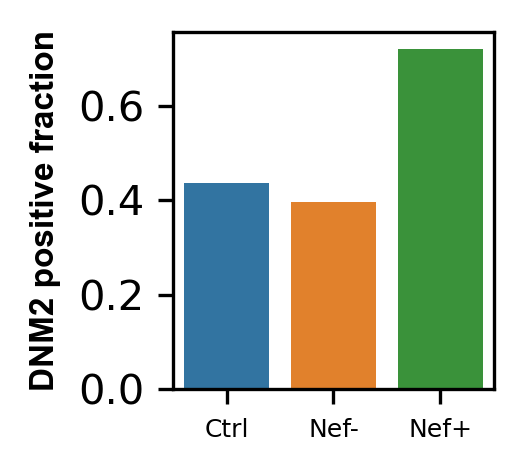

In [193]:
bx = plt.figure(figsize = (3.5/2.54,4/2.54), dpi=300)
bx = sns.barplot(data = dnm2_coloc_df, x = 'condition', y = 'dnm2_pos_fraction')

bx = plt.xlabel('', fontname = "Arial", fontsize = 8, fontweight = "bold")
bx = plt.ylabel('DNM2 positive fraction', fontname = "Arial", fontsize = 8, fontweight = "bold")
bx = plt.xticks(fontsize = 6)

In [54]:
df_no_dnm2_master_4h_nef_pos = nodnm2_df_features_master[(nodnm2_df_features_master['nef_status'] == 1) & (nodnm2_df_features_master['condition'] == 4)]
df_no_dnm2_master_4h_nef_neg = nodnm2_df_features_master[(nodnm2_df_features_master['nef_status'] == 0) & (nodnm2_df_features_master['condition'] == 4) & (nodnm2_df_features_master['lifetime'] >= 8)]
df_no_dnm2_master_ctrl = nodnm2_df_features_master[(nodnm2_df_features_master['condition'] == -1) & (nodnm2_df_features_master['lifetime'] >= 8)]

In [55]:
df_no_dnm2_master_4h_nef_pos_count = df_no_dnm2_master_4h_nef_pos.groupby(['cell_id','dnm2_status']).agg('count')
df_no_dnm2_master_4h_nef_neg_count = df_no_dnm2_master_4h_nef_neg.groupby(['cell_id','dnm2_status']).agg('count')
df_no_dnm2_master_ctrl_count = df_no_dnm2_master_ctrl.groupby(['cell_id','dnm2_status']).agg('count')

In [56]:
percent_dnm2_4h_nef_pos = []

cell_id = df_no_dnm2_master_4h_nef_pos_count.index.levels[0].tolist()

for row in range(len(cell_id)):
    
    condition = df_no_dnm2_master_4h_nef_pos_count.loc[(cell_id[row])].index.get_level_values(0)[0]
    
    if len(df_no_dnm2_master_4h_nef_pos_count.loc[(cell_id[row])].iloc[:,0]) == 2:
        temp_dnm2_percentage = df_no_dnm2_master_4h_nef_pos_count.loc[(cell_id[row])].iloc[:,0].tolist()
        temp_dnm2_percentage = (temp_dnm2_percentage[1]/(temp_dnm2_percentage[0] + temp_dnm2_percentage[1]))*100
        
    elif (df_no_dnm2_master_4h_nef_pos_count.loc[(cell_id[row])].index.get_level_values(0) == 0):
        temp_dnm2_percentage = 0
        
    else:
        temp_dnm2_percentage = 100
        
    percent_dnm2_4h_nef_pos.append(temp_dnm2_percentage)

In [57]:
percent_dnm2_4h_nef_neg = []

cell_id = df_no_dnm2_master_4h_nef_neg_count.index.levels[0].tolist()

for row in range(len(cell_id)):
    
    condition = df_no_dnm2_master_4h_nef_neg_count.loc[(cell_id[row])].index.get_level_values(0)[0]
    
    if len(df_no_dnm2_master_4h_nef_neg_count.loc[(cell_id[row])].iloc[:,0]) == 2:
        temp_dnm2_percentage = df_no_dnm2_master_4h_nef_neg_count.loc[(cell_id[row])].iloc[:,0].tolist()
        temp_dnm2_percentage = (temp_dnm2_percentage[1]/(temp_dnm2_percentage[0] + temp_dnm2_percentage[1]))*100
        
    elif (df_no_dnm2_master_4h_nef_neg_count.loc[(cell_id[row])].index.get_level_values(0) == 0):
        temp_dnm2_percentage = 0
        
    else:
        temp_dnm2_percentage = 100
        
    percent_dnm2_4h_nef_neg.append(temp_dnm2_percentage)

In [58]:
percent_dnm2_ctrl = []

cell_id = df_no_dnm2_master_ctrl_count.index.levels[0].tolist()

for row in range(len(cell_id)):
    
    condition = df_no_dnm2_master_ctrl_count.loc[(cell_id[row])].index.get_level_values(0)[0]
    
    if len(df_no_dnm2_master_ctrl_count.loc[(cell_id[row])].iloc[:,0]) == 2:
        temp_dnm2_percentage = df_no_dnm2_master_ctrl_count.loc[(cell_id[row])].iloc[:,0].tolist()
        temp_dnm2_percentage = (temp_dnm2_percentage[1]/(temp_dnm2_percentage[0] + temp_dnm2_percentage[1]))*100
        
    elif (df_no_dnm2_master_ctrl_count.loc[(cell_id[row])].index.get_level_values(0) == 0):
        temp_dnm2_percentage = 0
        
    else:
        temp_dnm2_percentage = 100
        
    percent_dnm2_ctrl.append(temp_dnm2_percentage)

In [59]:
df_percent_dnm2_4h_nef_pos = pd.DataFrame({'Nef+' : percent_dnm2_4h_nef_pos})
df_percent_dnm2_4h_nef_neg = pd.DataFrame({'Nef-' : percent_dnm2_4h_nef_neg})
df_percent_dnm2_ctrl = pd.DataFrame({'Ctrl' : percent_dnm2_ctrl})

df_master_dnm2_coloc = pd.concat([df_percent_dnm2_ctrl, df_percent_dnm2_4h_nef_neg, df_percent_dnm2_4h_nef_pos], axis=1)

In [60]:
df_master_dnm2_coloc

Ctrl       Nef-   Nef+
0    50.000000  60.194175  100.0
1    52.272727  61.855670  100.0
2    32.812500  60.273973  100.0
3    71.428571  74.074074  100.0
4    38.345865  84.745763  100.0
..         ...        ...    ...
136  65.517241  65.909091    NaN
137  64.245810  35.000000    NaN
138  58.730159  50.980392    NaN
139  62.500000  72.727273    NaN
140        NaN  49.333333    NaN

[141 rows x 3 columns]

In [61]:
df_master_coloc.to_excel("output.xlsx") 

NameError: name 'df_master_coloc' is not defined

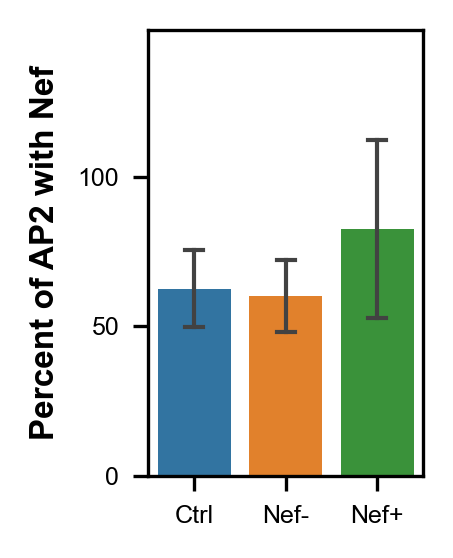

In [62]:
ax = plt.figure(figsize = (3/2.54 , 5/2.54), dpi=300)
sns.barplot(data = df_master_dnm2_coloc, errorbar = 'sd', errwidth = 1, capsize = 0.2)
ax = plt.ylim(bottom= 0, top=149)
#ax = plt.xlabel('Nef Induction Time (h)', fontname = "Arial", fontsize = 8, fontweight = "bold")
ax = plt.ylabel('Percent of AP2 with Nef', fontname = "Arial", fontsize = 8, fontweight = "bold")
position = [0, 1, 2]
catlabel = ['Ctrl', 'Nef-', 'Nef+']
ax = plt.xticks(position, catlabel)
ax = plt.xticks(fontname = "Arial", fontsize = 6)
ax = plt.yticks(fontname = "Arial", fontsize = 6)



In [65]:
#DNM2 pos fraction
#ctrl vs 4h pos
_, p_4h_pos_ctrl = stats.mannwhitneyu(x = df_master_dnm2_coloc['Ctrl'].values, y = df_master_dnm2_coloc['Nef+'].values, use_continuity = False)
#ctrl vs 4h neg
_, p_4h_neg_ctrl = stats.mannwhitneyu(x = df_master_dnm2_coloc['Nef-'].values, y = df_master_dnm2_coloc['Nef+'].values, use_continuity = False)

print("ctrl mean, stdev")
print(np.mean(df_percent_dnm2_ctrl['Ctrl'].values))
print(np.std(df_percent_dnm2_ctrl['Ctrl'].values))
print("nef neg mean, stdev")
print(np.mean(df_master_dnm2_coloc['Nef-'].values))
print(np.std(df_master_dnm2_coloc['Nef-'].values))
print("nef pos mean, stdev")
print(np.mean(df_percent_dnm2_4h_nef_pos['Nef+'].values))
print(np.std(df_percent_dnm2_4h_nef_pos['Nef+'].values))

print("ctrl vs 4h nef pos")
print(p_4h_pos_ctrl)
print("ctrl vs 4h nef neg")
print(p_4h_neg_ctrl)

ctrl mean, stdev
62.50244166318669
12.823967753642602
nef neg mean, stdev
60.097959807989334
11.867941865139514
nef pos mean, stdev
82.35989278752436
29.6115957828627
ctrl vs 4h nef pos
2.7263114333732524e-21
ctrl vs 4h nef neg
1.1152906558199368e-22


In [125]:
#Quant/statistics
#For Nef 4h dataset
ctrl_df = nodnm2_df_features_master[(nodnm2_df_features_master['condition'] == -1) & (nodnm2_df_features_master['lifetime'] >= 8)]
nef_pos_4h_df = nodnm2_df_features_master[(nodnm2_df_features_master['condition'] == 4) & (nodnm2_df_features_master['lifetime'] >= 8) & (nodnm2_df_features_master['nef_status'] == 1)]
nef_neg_4h_df = nodnm2_df_features_master[(nodnm2_df_features_master['condition'] == 4) & (nodnm2_df_features_master['lifetime'] >= 8) & (nodnm2_df_features_master['nef_status'] == 0)]

#AP2 lifetime
#ctrl vs 4h pos
_, p_4h_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['lifetime'].values, y = nef_pos_4h_df['lifetime'].values, use_continuity = False)
#ctrl vs 4h neg
_, p_4h_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['lifetime'].values, y = nef_neg_4h_df['lifetime'].values, use_continuity = False)
#WT pos vs 4h neg
_, p_4h_neg_4h_pos = stats.mannwhitneyu(x = nef_pos_4h_df['lifetime'].values, y = nef_neg_4h_df['lifetime'].values, use_continuity = False)
print("ctrl mean, stdev")
print(np.mean(ctrl_df['lifetime'].values))
print(np.std(ctrl_df['lifetime'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_4h_df['lifetime'].values))
print(np.std(nef_pos_4h_df['lifetime'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_4h_df['lifetime'].values))
print(np.std(nef_neg_4h_df['lifetime'].values))

print("ctrl vs 4h nef pos")
print(p_4h_pos_ctrl)
print("ctrl vs 4h nef neg")
print(p_4h_neg_ctrl)
print("4h nef pos vs 4h nef neg")
print(p_4h_neg_4h_pos)

ctrl mean, stdev
32.92431698625488
33.586184275719546
nef pos mean, stdev
78.21602787456446
55.2999614478943
nef neg mean, stdev
29.844117647058823
29.93579504973128
ctrl vs 4h nef pos
1.6227088074571423e-61
ctrl vs 4h nef neg
6.587902794452602e-09
4h nef pos vs 4h nef neg
2.0400867121528976e-70


# Measuring AP2 rate of change after a certain frame

In [88]:
intensity = [3,4,5,7,8,3,6,8,0,5]
intensity2 = [5,7,9,3,7,9,3,0]

intensity3 = [1, 2, 3, 4, float("NaN")]
intensity3_nonan = [item for item in intensity3 if not(pd.isnull(item)) == True]

In [89]:
intensity3_nonan

[1, 2, 3, 4]

In [109]:
intensity4 = [[3,4,5,7,3,6,8,5],[3,4,5,7,3,6,8],[3,5,7,8,3,6,8,5],[3,4,5, 3,6,8]]

transposed_intensity4 = list(map(list, itertools.zip_longest(*intensity4, fillvalue=None)))

In [110]:
intensity4

[[3, 4, 5, 7, 3, 6, 8, 5],
 [3, 4, 5, 7, 3, 6, 8],
 [3, 5, 7, 8, 3, 6, 8, 5],
 [3, 4, 5, 3, 6, 8]]

In [113]:
transposed_intensity4

[[3, 3, 3, 3],
 [4, 4, 5, 4],
 [5, 5, 7, 5],
 [7, 7, 8, 3],
 [3, 3, 3, 6],
 [6, 6, 6, 8],
 [8, 8, 8, None],
 [5, None, 5, None]]

In [123]:
sum(item for item in transposed_intensity4[6] if item != None)/len([item for item in transposed_intensity4[6] if item != None])

8.0

In [126]:
ave_int_list

[3.0, 4.25, 5.5, 6.25, 3.75, 6.5, 8.0, 5.0]

In [127]:
ave_int_difference = [j-i for i, j in zip(ave_int_list[:-1], ave_int_list[1:])]

In [128]:
ave_int_difference

[1.25, 1.25, 0.75, -2.5, 2.75, 1.5, -3.0]

In [131]:
ave_int_section = ave_int_difference[1:20]

In [132]:
ave_int_section

[1.25, 0.75, -2.5, 2.75, 1.5, -3.0]

In [133]:
#Creating list of lists with channel intensities for a designated condition/track
track_set_1 = valid_tracks_nef_negative_master
track_set_2 = valid_tracks_nef_negative_displacement_master
condition = -1
channel = 0

indices_condition = np.where(np.array(cell_condition_master)==condition)[0]
tracks_condition_1 = np.array(track_set_1, dtype='object')[indices_condition]
tracks_condition_2 = np.array(track_set_2, dtype='object')[indices_condition]

tracks_compiled = []

for tracks in tracks_condition_1:

    for track in tracks:

        tracks_compiled.append(track)
        
for tracks in tracks_condition_2:

    for track in tracks:

        tracks_compiled.append(track)
        
channel_amps = []
#     print(len(tracks_compiled))
for i in range(len(tracks_compiled)):
#         print(i)
    ch0 = return_track_attributes.return_track_amplitude_no_buffer_channel(tracks_compiled, i, channel)
    channel_amps.append(ch0)

In [153]:
#Code for taking a list of lists, channel intensities for all tracks, and then calculating the average values at each time point. (This is aligned to initial AP2 detection)
input_list = channel_amps
transposed_input_list = list(map(list, itertools.zip_longest(*input_list, fillvalue=None)))

ave_int_list = []
for i in range(len(transposed_input_list)):
    ave_intensity = sum(item for item in transposed_input_list[i] if item != None)/len([item for item in transposed_input_list[i] if item != None])
    ave_int_list.append(ave_intensity)

#Code for getting difference between consecutive measurements. Should spit out list that is one shorter. 
#Using this list, stepwise differences between desired timeframes can be calculated. For example from t = 0 - 20 would be the average of the 0th to 19th item on the list.
ave_int_difference = []
ave_int_difference = [j-i for i, j in zip(ave_int_list[:-1], ave_int_list[1:])]

#Code for calculating average rate of change over next 10 frames
ave_rate_change_list = []
for i in range(len(ave_int_difference)):
    ave_rate_change = sum(ave_int_difference[i:i+8])/len(ave_int_difference[i:i+8])
    ave_rate_change_list.append(ave_rate_change)
    

In [154]:
ave_rate_change_list

[10.23019693612451,
 13.382647574437676,
 12.898100299678877,
 12.432547874462873,
 12.408305228335053,
 11.880563718458664,
 12.522341754529275,
 12.546743956906354,
 12.658539092126663,
 12.418426068609968,
 12.222663357262704,
 11.673376730056276,
 11.334519491959128,
 10.655848859744061,
 9.555644334779423,
 8.950989753385556,
 7.297270960964056,
 6.585362483270536,
 6.742385304873757,
 5.849192427571943,
 5.676883698927654,
 5.490636915025078,
 5.062487075486132,
 4.4229526488377715,
 4.750844822969086,
 3.6597325769153954,
 2.648658582894427,
 3.322393237036742,
 2.2668089278207617,
 2.1907292770749365,
 2.2181939930618384,
 1.9710325699174405,
 1.386340085714842,
 0.67569768337097,
 0.9325982642475523,
 0.9703099766683536,
 1.4034349626674825,
 1.3507612599964673,
 1.3264445819091932,
 0.9258069578175565,
 2.1823497046112195,
 3.417397474133786,
 4.229017116835223,
 0.6974047731799331,
 0.6024161545282496,
 0.8554143961088627,
 0.6952187810490074,
 1.7497592206030461,
 1.2530483

In [178]:
#Code for calculating average rate of change from first frame of Nef detection
first_detection_nef_master = []
first_detection_nef_master_1d = []
nef_pos_rate_change_master = []
channel = 0

for tracks in valid_tracks_nef_positive_master:

    first_detection_nef = first_detection_time (tracks, 
                                                sig_pval_cutoff=0.01,
                                                channel = 2,
                                                framerate = 1)
    
    first_detection_nef_master.append(first_detection_nef)
    first_detection_nef_master_1d.extend(first_detection_nef)
    
for count, tracks in enumerate(valid_tracks_nef_positive_master):
    for i in range(len(tracks)):
        temp_amplitude = return_track_attributes.return_track_amplitude_no_buffer_channel(tracks, i, 0)
        temp_difference = [j-i for i, j in zip(temp_amplitude[:-1], temp_amplitude[1:])]
        first_frame = first_detection_nef_master[count][i]
        temp_rate_change = sum(temp_difference[first_frame:first_frame+8])/len(temp_difference[first_frame:first_frame+8])
        nef_pos_rate_change_master.append(temp_rate_change)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 666.16it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 677.62it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.60it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1176.03it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████

In [179]:
nef_ave_rate_diff = []
for i in range(len(nef_pos_rate_change_master)):
    nef_ave_diff = nef_pos_rate_change_master[i] - ave_rate_change_list[first_detection_nef_master_1d[i]]
    nef_ave_rate_diff.append(nef_ave_diff)

In [180]:
ref_rate_df = pd.DataFrame(columns=['ref_frame', 'ref_rate'])

ref_rate_df['ref_rate'] = ave_rate_change_list
ref_rate_df['ref_frame'] = list(range(len(ave_rate_change_list)))

nef_rate_df = pd.DataFrame(columns=['nef_frame', 'nef_rate', 'nef_ave_diff'])
nef_rate_df['nef_rate'] = nef_pos_rate_change_master
nef_rate_df['nef_frame'] = first_detection_nef_master_1d
nef_rate_df['nef_ave_diff'] = nef_ave_rate_diff

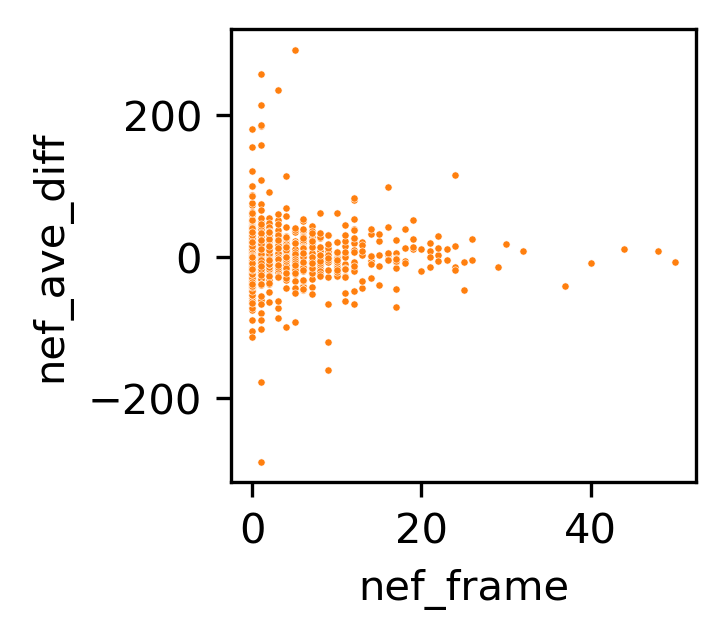

In [181]:
ax = plt.figure(figsize = (5/2.5,5/2.5), dpi=300)
#ax = sns.scatterplot(data=ref_rate_df, x = 'ref_frame', y = 'ref_rate', color = 'C0', s = 3, legend = False)
ax = sns.scatterplot(data=nef_rate_df, x = 'nef_frame', y = 'nef_ave_diff', color = 'C1', s = 3, legend = False)

# Comparing dynamics across induction

In [85]:
#generating sampled dataframe for swarmplot use
df_sample = pd.DataFrame()
df_AP2_DNM2 = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == -1)].sample(n=50, random_state=1)
df_1h_neg = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 0)].sample(n=50, random_state=1)
df_1h_pos = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 0)].sample(n=50, random_state=1)
df_2h_neg = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 2)].sample(n=50, random_state=1)
df_2h_pos = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 2)].sample(n=50, random_state=1)
df_4h_neg = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 4)].sample(n=50, random_state=1)
df_4h_pos = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 4)].sample(n=50, random_state=1)
df_6h_neg = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 6)].sample(n=50, random_state=1)
df_6h_pos = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 6)].sample(n=50, random_state=1)
df_24h_neg = df_features_master[(df_features_master['nef_status'] == 0) & (df_features_master['condition'] == 24)].sample(n=50, random_state=1)
df_24h_pos = df_features_master[(df_features_master['nef_status'] == 1) & (df_features_master['condition'] == 24)].sample(n=50, random_state=1)

df_sample = df_sample.append([df_AP2_DNM2, df_1h_neg, df_1h_pos, df_2h_neg, df_2h_pos, df_4h_neg, df_4h_pos, df_6h_neg, df_6h_pos, df_24h_neg, df_24h_pos])

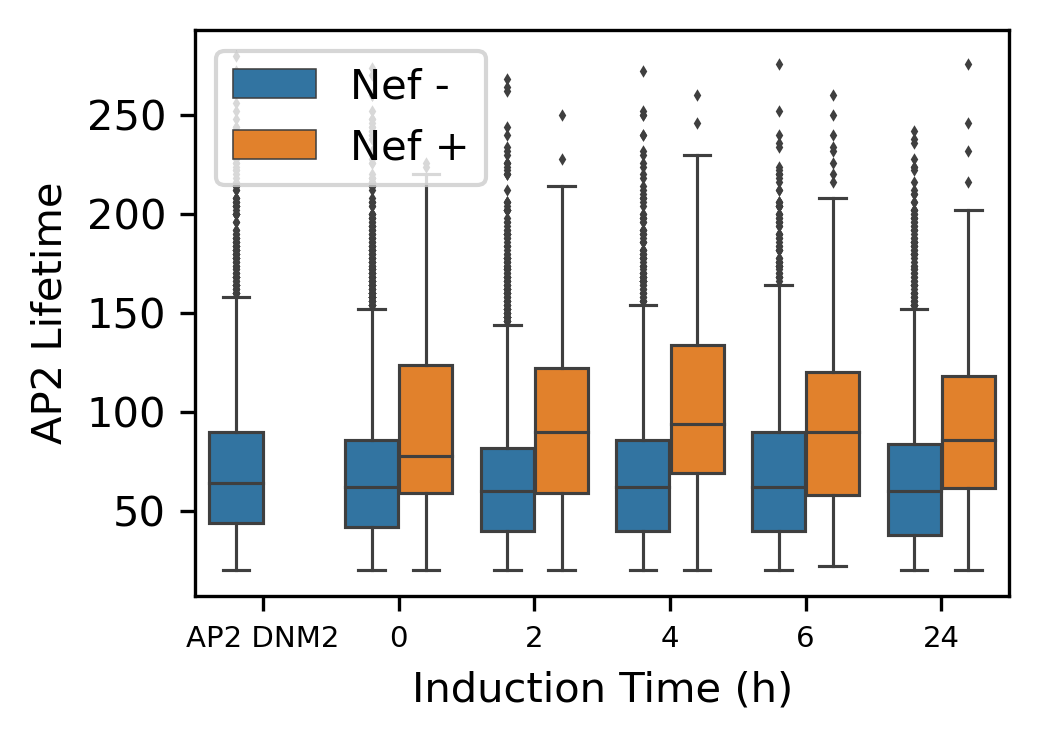

In [98]:
plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='lifetime', dodge=True, hue = 'nef_status', linewidth = 0.75, fliersize = 0.75)
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Induction Time (h)')
plt.ylabel('AP2 Lifetime')
position = [0, 1, 2, 3, 4, 5]
catlabel = ['AP2 DNM2', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontsize = 7)

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left')

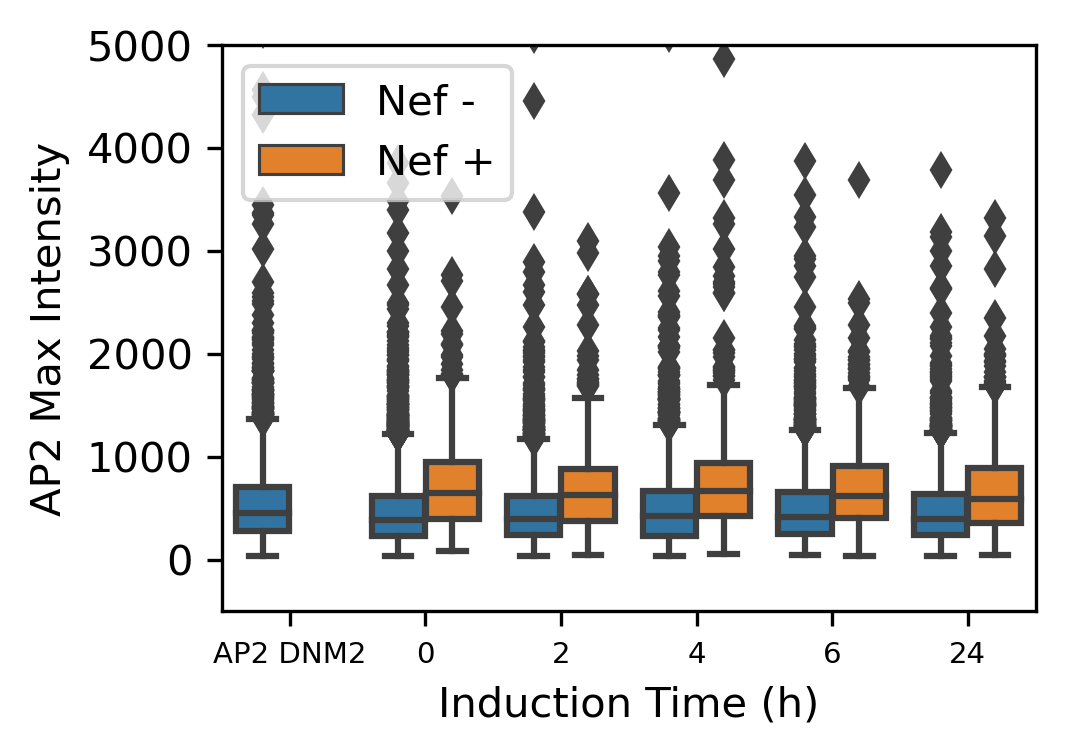

In [87]:
plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='max_ap2', dodge=True, hue = 'nef_status')
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Induction Time (h)')
plt.ylabel('AP2 Max Intensity')
position = [0, 1, 2, 3, 4, 5]
catlabel = ['AP2 DNM2', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontsize = 7)

ax.set(ylim = [-500,5000])
ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left')

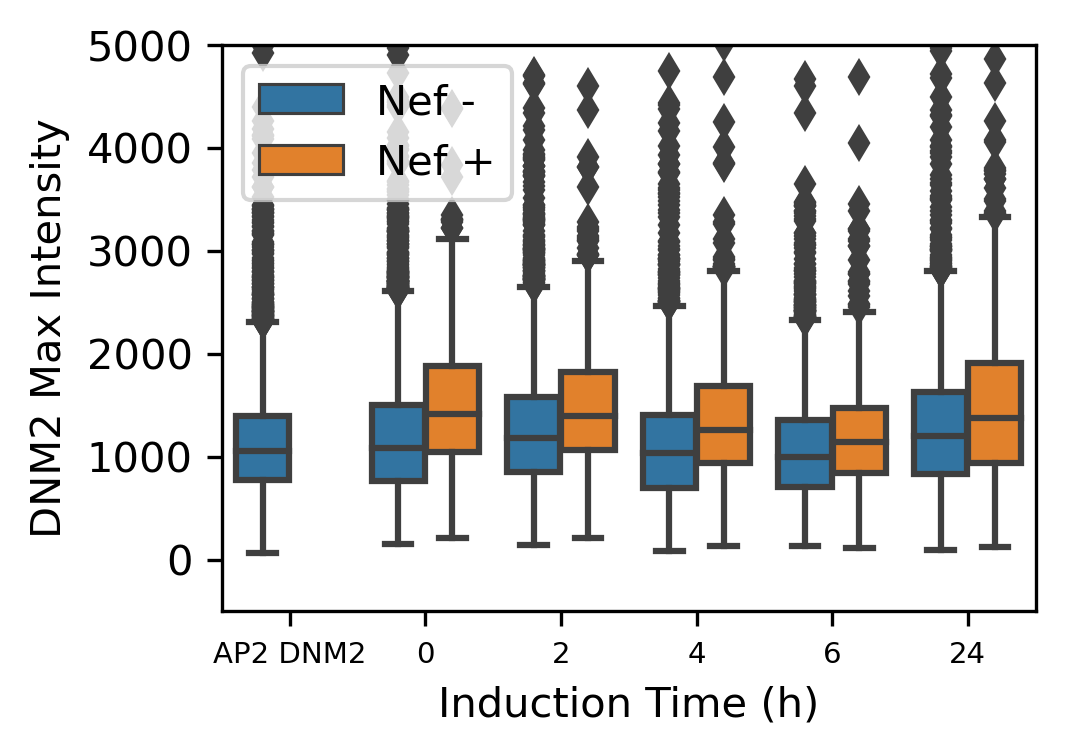

In [88]:
plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='max_dnm2', dodge=True, hue = 'nef_status')
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Induction Time (h)')
plt.ylabel('DNM2 Max Intensity')
position = [0, 1, 2, 3, 4, 5]
catlabel = ['AP2 DNM2', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontsize = 7)

ax.set(ylim = [-500,5000])
ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left')

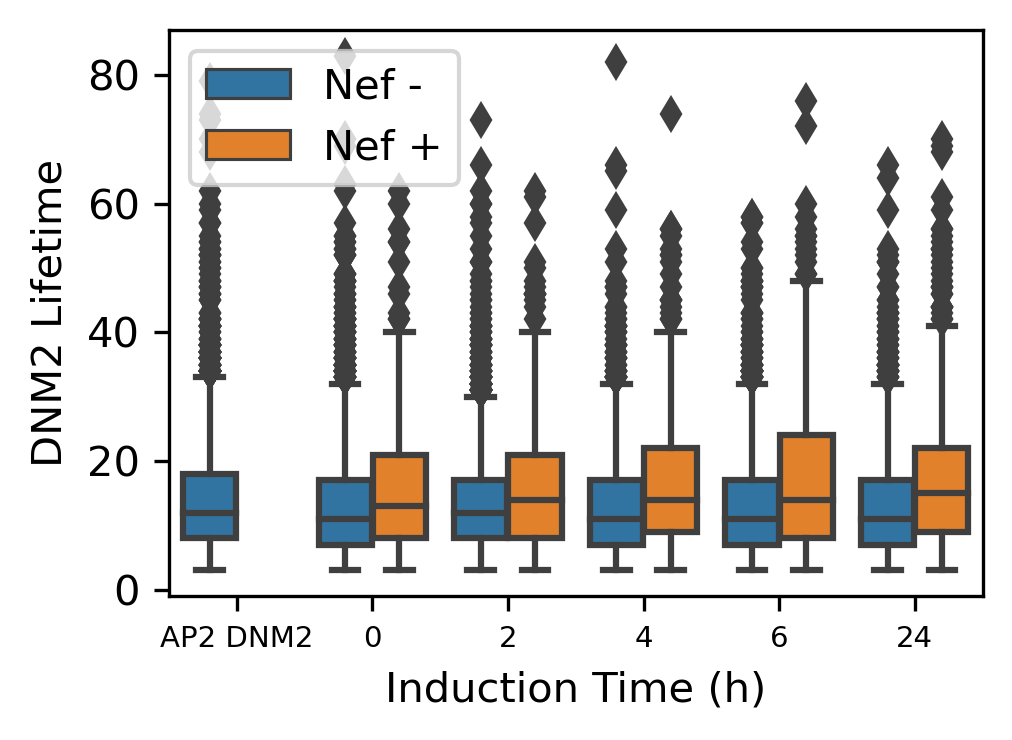

In [89]:
plt.figure(figsize = (3.5,2.5), dpi=300)
ax = sns.boxplot(data=df_features_master[~((df_features_master['nef_status'] == 1) & (df_features_master['condition'] == -1))], x='condition', y='max_consecutive_dnm2', dodge=True, hue = 'nef_status')
#ax = sns.swarmplot(data=df_sample, x='condition', y = 'lifetime', dodge = True, hue = 'nef_status', size = 2, color = '0.8', edgecolor = '0.25', linewidth = 0.6)

plt.xlabel('Induction Time (h)')
plt.ylabel('DNM2 Lifetime')
position = [0, 1, 2, 3, 4, 5]
catlabel = ['AP2 DNM2', '0', '2', '4', '6', '24']
plt.xticks(position, catlabel)
plt.xticks(fontsize = 7)

ax.legend(handles=ax.legend_.legendHandles, labels=['Nef -', 'Nef +'], loc = 'upper left')

## Analysis for no dnm2 filtered tracks

In [53]:
nodnm2_df_features_master = nodnm2_df_features_master[(nodnm2_df_features_master['lifetime'] > 20)]

In [54]:
len(nodnm2_df_features_master)

33737

Text(0, 0.5, 'Probability')

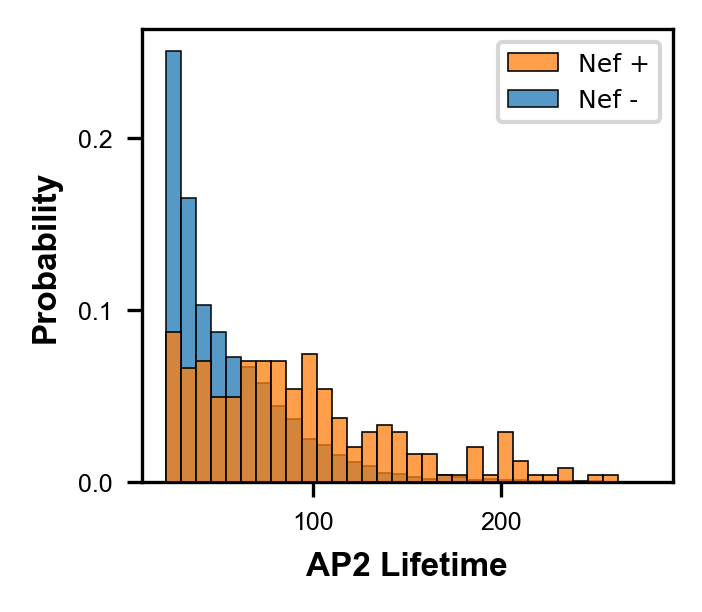

In [55]:
#Generating lifetime histogram for valid set
ax = plt.figure(figsize = (5.8/2.54,5/2.5), dpi=300)
ax = sns.histplot(data=nodnm2_df_features_master[(nodnm2_df_features_master['nef_status'] == 1) & (nodnm2_df_features_master['condition'] == 4)], x = 'lifetime', stat = 'probability', color = 'C1', binwidth = 8, zorder = 10)
ax = sns.histplot(data=nodnm2_df_features_master[(nodnm2_df_features_master['nef_status'] == 0) & (nodnm2_df_features_master['condition'] == 4)], x = 'lifetime', stat = 'probability', binwidth = 8)


ax = plt.legend(title=None, loc='upper right', labels=['Nef +', 'Nef -'], fontsize = 6)
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)

plt.xlabel('AP2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

Text(0, 0.5, 'Probability')

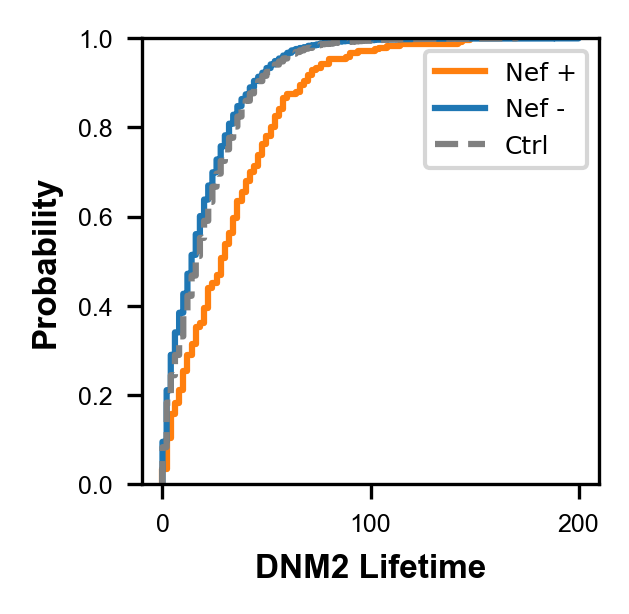

In [73]:
#Base code for CDF. 4 hour induction of Nef condition Specifically for AP2 max intensity
sub_df = nodnm2_df_features_master[nodnm2_df_features_master['condition'] == 4]
ref_df = nodnm2_df_features_master[nodnm2_df_features_master['condition'] == -1]

ax = plt.figure(figsize = (5/2.54,5/2.54), dpi=300)
ax = sns.ecdfplot(data=sub_df, x = 'dnm2_lifetime', hue = 'nef_status')
ax = sns.ecdfplot(data=ref_df, x = 'dnm2_lifetime', color = '0.5', linestyle="dashed")

plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
#ax.set(xlim = [0,2000])
ax = plt.legend(title=None, loc='upper right', labels=['Nef +', 'Nef -', 'Ctrl'], fontsize = 6)
plt.xlabel('DNM2 Lifetime', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('Probability', fontname = "Arial", fontsize = 8, fontweight = "bold")

In [58]:
dnm2_neg_4h = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] <= 6) & (nodnm2_df_features_master['condition'] == 4)]
dnm2_pos_4h = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] > 6) & (nodnm2_df_features_master['condition'] == 4)]
dnm2_neg_ctrl = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] <= 6) & (nodnm2_df_features_master['condition'] == -1)]
dnm2_pos_ctrl = nodnm2_df_features_master[(nodnm2_df_features_master['dnm2_lifetime'] > 6) & (nodnm2_df_features_master['condition'] == -1)]

In [67]:
dnm2_pos_ratio_4h = len(dnm2_pos_4h)/(len(dnm2_pos_4h) + len(dnm2_neg_4h))
dnm2_pos_ratio_ctrl = len(dnm2_pos_ctrl)/(len(dnm2_pos_ctrl) + len(dnm2_neg_ctrl))

ratio = [dnm2_pos_ratio_ctrl, dnm2_pos_ratio_4h]
dnm2_labels = ['-', '4']

In [68]:
dnm2_coloc_df = pd.DataFrame(columns=['dnm2_pos_fraction', 'condition'])

dnm2_coloc_df['dnm2_pos_fraction'] = ratio
dnm2_coloc_df['condition'] = dnm2_labels

In [69]:
dnm2_coloc_df

dnm2_pos_fraction condition
0           0.710209         -
1           0.666993         4

In [64]:
ax = plt.figure(figsize = (4.5/2.54 , 2/2.54), dpi=300)
ax = sns.barplot(data = dnm2_coloc_df, x = 'condition', y = 'dnm2_pos_fraction', size = 2)
#ax = plt.ylim(bottom= 0, top=5000)
ax = plt.xlabel('% DNM2 positive', fontname = "Arial", fontsize = 8, fontweight = "bold")
ax = plt.xticks(fontname = "Arial", fontsize = 6)
ax = plt.yticks(fontname = "Arial", fontsize = 6)


TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 531.496x236.22 with 0 Axes>

# Lifetime with gaplength

In [44]:
len(pass_nef_positive_filtered_valid_tracks_1[50][0])

38

In [55]:
#Code for tolerating gaps in calculating DNM2 and Nef lifetimes. 
gap = 2
sig_pval_cutoff = 0.01

pvals = pass_nef_positive_filtered_valid_tracks_1[50][2][12][2]
significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
#print(repeated_indices)

#code for detecting which tuple has highest # of consecutive detections. 
#If there are multiple tuples with the highest number, the tuple that appears latest on the list is selected
nef_frame = max([x for x, y in enumerate(repeated_indices) if
                 (repeated_indices[x][1] == max(repeated_indices)[1] and
                  repeated_indices[x][0] == 1)])

start = 0
end = 0
for k in range(nef_frame):
    start += repeated_indices[k][1]

end = start + repeated_indices[nef_frame][1]


In [56]:
repeated_indices

[(0, 1), (1, 1), (0, 1), (1, 4), (0, 1), (1, 5)]

In [57]:
gap_tolerated_repeated_indices = []
gap = 2

for item in range(len((repeated_indices))):
    if ((item != 0) & (repeated_indices[item][0] == 0) & (repeated_indices[item][1] <= gap)):
        gap_tolerated_repeated_indices.append((1, repeated_indices[item][1]))
    else:
        gap_tolerated_repeated_indices.append(repeated_indices[item])
        


In [58]:
gap_tolerated_repeated_indices

[(0, 1), (1, 1), (1, 1), (1, 4), (1, 1), (1, 5)]

In [59]:
gap_tolerated_max_consecutive = 0
temp_consecutive = 0

for item in range(len((gap_tolerated_repeated_indices))):
    if (gap_tolerated_repeated_indices[item][0] == 0):
        temp_consecutive = 0
    else:
        temp_consecutive += gap_tolerated_repeated_indices[item][1]
        
    gap_tolerated_max_consecutive = max(temp_consecutive, gap_tolerated_max_consecutive)

In [60]:
gap_tolerated_max_consecutive

12

In [61]:
# Function form of max_consecutive calculation with tolerance. This should calculate lifetimes with gap lengths just like for the coat channel. 
def max_consecutive_with_gap (tracks_to_check, 
                              sig_pval_cutoff=0.01,
                              channel = 1,
                              gap = 2):
    
    gap_tolerated_lifetime = []
    
    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:
        # and make sure track is category 1 (valids with good gaps)
        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][channel]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        
        gap_tolerated_repeated_indices = []
        
        for ii in range(len((repeated_indices))):
            if ((ii != 0) & (repeated_indices[ii][0] == 0) & (repeated_indices[ii][1] <= gap)):
                gap_tolerated_repeated_indices.append((1, repeated_indices[ii][1]))
            else:
                gap_tolerated_repeated_indices.append(repeated_indices[ii])
        
        gap_tolerated_max_consecutive = 0
        temp_consecutive = 0
        
        print(repeated_indices)
        print(gap_tolerated_repeated_indices)
        
        for ii in range(len((gap_tolerated_repeated_indices))):
            if (gap_tolerated_repeated_indices[ii][0] == 0):
                temp_consecutive = 0
            else:
                temp_consecutive += gap_tolerated_repeated_indices[ii][1]

            gap_tolerated_max_consecutive = max(temp_consecutive, gap_tolerated_max_consecutive)
        gap_tolerated_lifetime.append(gap_tolerated_max_consecutive)
        
    return gap_tolerated_lifetime

In [62]:
test = max_consecutive_with_gap (pass_nef_positive_filtered_valid_tracks_1[50],
                                 0.01,
                                 2,
                                 2)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1497.97it/s]

[(0, 11), (1, 1), (0, 2), (1, 9), (0, 1), (1, 1), (0, 3), (1, 1), (0, 2), (1, 1), (0, 16), (1, 1), (0, 3), (1, 1), (0, 8), (1, 1), (0, 3), (1, 1), (0, 1)]
[(0, 11), (1, 1), (1, 2), (1, 9), (1, 1), (1, 1), (0, 3), (1, 1), (1, 2), (1, 1), (0, 16), (1, 1), (0, 3), (1, 1), (0, 8), (1, 1), (0, 3), (1, 1), (1, 1)]
[(0, 12), (1, 1), (0, 4), (1, 1), (0, 2), (1, 10), (0, 2), (1, 2), (0, 1), (1, 3), (0, 1), (1, 4), (0, 3), (1, 2), (0, 1), (1, 1), (0, 1), (1, 2), (0, 1)]
[(0, 12), (1, 1), (0, 4), (1, 1), (1, 2), (1, 10), (1, 2), (1, 2), (1, 1), (1, 3), (1, 1), (1, 4), (0, 3), (1, 2), (1, 1), (1, 1), (1, 1), (1, 2), (1, 1)]
[(0, 1), (1, 1), (0, 1), (1, 4), (0, 1), (1, 5)]
[(0, 1), (1, 1), (1, 1), (1, 4), (1, 1), (1, 5)]


In [63]:
test

[14, 26, 12]

In [164]:
gap_tolerated_repeated_indices[0][1]

2

In [157]:
range(len((gap_tolerated_repeated_indices)))

range(0, 5)

In [158]:
gap_tolerated_repeated_indices

[(1, 2), (1, 1), (1, 4), (1, 1), (1, 5)]

In [88]:
test_nef_lifetime = []

for tracks in filtered_valid_tracks_nef_positive_master:
    
    nef_lifetime = max_consecutive_with_gap (tracks,
                                             0.01,
                                             2,
                                             2)
    
    test_nef_lifetime.append(nef_lifetime)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 425.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.49it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.56it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.09it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 137.34it/s]
0

In [89]:
len(test_nef_lifetime)

902

In [90]:
nef_lifetime_list = []

for i in range(len(test_nef_lifetime)):
    for ii in range(len(test_nef_lifetime[i])):
        nef_lifetime_list.append(test_nef_lifetime[i][ii])

In [91]:
sum(nef_lifetime_list)/len(nef_lifetime_list)

21.939909297052154

In [94]:
#Parameter Sweep
pvals = [0.05, 0.01, 0.001, 0.0001]
avg_lifetime = []

for i in range(len(gaps)):
    test_nef_lifetime = []

    for tracks in filtered_valid_tracks_nef_positive_master:

        nef_lifetime = max_consecutive_with_gap (tracks,
                                                 pvals[i],
                                                 2,
                                                 2)

        test_nef_lifetime.append(nef_lifetime)
    
    nef_lifetime_list = []

    for i in range(len(test_nef_lifetime)):
        for ii in range(len(test_nef_lifetime[i])):
            nef_lifetime_list.append(test_nef_lifetime[i][ii])
            
    avg_lifetime.append(sum(nef_lifetime_list)/len(nef_lifetime_list))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.52it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1249.42it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.54it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 173.76it/s]
0

IndexError: list index out of range

In [93]:
#sweeping gaps
avg_lifetime

[12.434240362811792,
 18.09750566893424,
 21.939909297052154,
 25.282312925170068,
 27.665532879818596,
 29.53174603174603]

In [95]:
#sweeping pvals
avg_lifetime

[22.165532879818596,
 21.939909297052154,
 21.660997732426303,
 21.448979591836736]

# Cohort Plot (normalized)

In [130]:
cell_condition_master[2]

-1

In [66]:
#Extracting intensity over time (Amplitude) from Nef positive tracks, separated by condition
condition = 4


indices_condition = np.where(np.array(cell_condition_master)==condition)[0]
tracks_condition = np.array(filtered_valid_tracks_nef_positive_master, dtype='object')[indices_condition]

tracks_compiled = []
    
for tracks in tracks_condition:

    for track in tracks:

        tracks_compiled.append(track)

channel_amps = []
#     print(len(tracks_compiled))
for i in range(len(tracks_compiled)):
#         print(i)
    ch0 = return_track_attributes.return_track_amplitude_no_buffer_channel(tracks_compiled, i, 0)
    ch1 = return_track_attributes.return_track_amplitude_no_buffer_channel(tracks_compiled, i, 1)
    ch2 = return_track_attributes.return_track_amplitude_no_buffer_channel(tracks_compiled, i, 2)
    channel_amps.append(list([ch0, ch1, ch2]))


[0]


Text(0, 0.5, 'a.u. fluorescence')

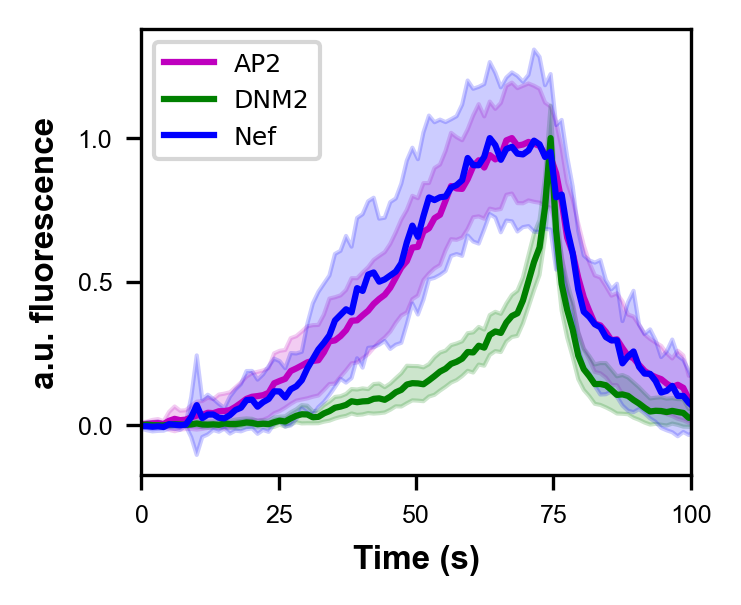

In [67]:
fig, axes_0 = plt.subplots(1, 1, dpi=300, figsize=(6/2.54,5/2.54))

#cohorts = [[0,100],[100,200],[200,300]]
cohorts = [[0,150]]

offsets, num_in_cohort, max_dnm2_cohort_indices_0 = display_tracks.plot_separated_cohorts([axes_0], 
                                                                                          channel_amps, 
                                                                                          1, 
                                                                                          cohorts, 
                                                                                          [0, 1, 2], 
                                                                                          [], 
                                                                                          ['AP2', 'DNM2', 'Nef'],
                                                                                          ['m', 'g', 'b'],
                                                                                          line_cutoff_index=[],
                                                                                          line_cutoff_regions=[[], [], []],
                                                                                          horizontal_shift_index=[0, 1, 2], 
                                                                                          horizontal_shift=[0, 0, 0],
                                                                                          line_removal_index=[],
                                                                                          line_kept_regions=[],
                                                                                          framerate=2,
                                                                                          norm_intensity=True)


                                                                        


lines_0, labels_0 = axes_0.get_legend_handles_labels()

axes_0.legend(lines_0, labels_0, loc='upper left', fontsize = 6)
axes_0.set_xlim([0, 100]) 
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
plt.xlabel('Time (s)', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('a.u. fluorescence', fontname = "Arial", fontsize = 8, fontweight = "bold")

[0]


Text(0, 0.5, 'a.u. fluorescence')

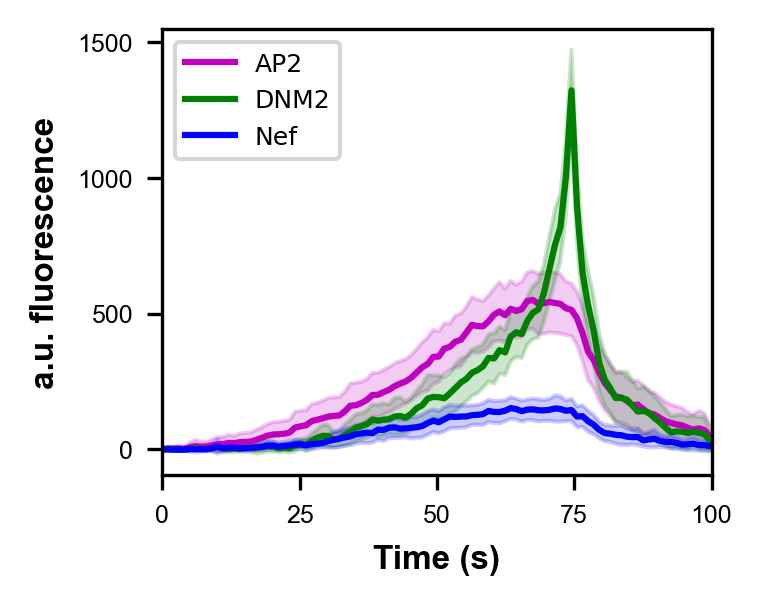

In [199]:
fig, axes_0 = plt.subplots(1, 1, dpi=300, figsize=(6/2.54,5/2.54))

#cohorts = [[0,100],[100,200],[200,300]]
cohorts = [[0,150]]

offsets, num_in_cohort, max_dnm2_cohort_indices_0 = display_tracks.plot_separated_cohorts([axes_0], 
                                                                                          channel_amps, 
                                                                                          1, 
                                                                                          cohorts, 
                                                                                          [0, 1, 2], 
                                                                                          [], 
                                                                                          ['AP2', 'DNM2', 'Nef'],
                                                                                          ['m', 'g', 'b'],
                                                                                          line_cutoff_index=[],
                                                                                          line_cutoff_regions=[[], [], []],
                                                                                          horizontal_shift_index=[0, 1, 2], 
                                                                                          horizontal_shift=[0, 0, 0],
                                                                                          line_removal_index=[],
                                                                                          line_kept_regions=[],
                                                                                          framerate=2,
                                                                                          norm_intensity=False)


                                                                        


lines_0, labels_0 = axes_0.get_legend_handles_labels()

axes_0.legend(lines_0, labels_0, loc='upper left', fontsize = 6)
axes_0.set_xlim([0, 100]) 
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
plt.xlabel('Time (s)', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('a.u. fluorescence', fontname = "Arial", fontsize = 8, fontweight = "bold")

In [200]:
#Extracting intensity over time (Amplitude) from Nef positive tracks, separated by condition
condition = -1


indices_condition = np.where(np.array(cell_condition_master)==condition)[0]
tracks_condition = np.array(filtered_valid_tracks_nef_negative_master, dtype='object')[indices_condition]

tracks_compiled = []
    
for tracks in tracks_condition:

    for track in tracks:

        tracks_compiled.append(track)

channel_amps = []
#     print(len(tracks_compiled))
for i in range(len(tracks_compiled)):
#         print(i)
    ch0 = return_track_attributes.return_track_amplitude_no_buffer_channel(tracks_compiled, i, 0)
    ch1 = return_track_attributes.return_track_amplitude_no_buffer_channel(tracks_compiled, i, 1)
    ch2 = return_track_attributes.return_track_amplitude_no_buffer_channel(tracks_compiled, i, 2)
    channel_amps.append(list([ch0, ch1, ch2]))


[0]


Text(0, 0.5, 'a.u. fluorescence')

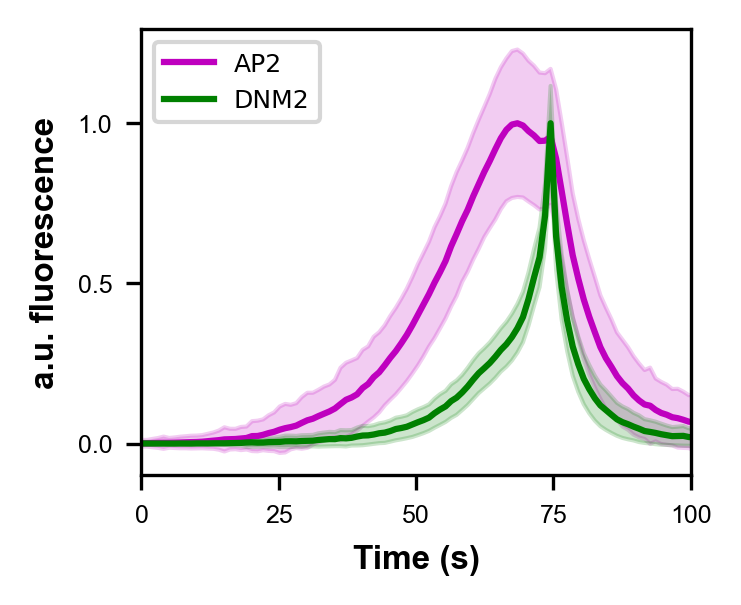

In [204]:
fig, axes_0 = plt.subplots(1, 1, dpi=300, figsize=(6/2.54,5/2.54))

#cohorts = [[0,100],[100,200],[200,300]]
cohorts = [[0,150]]

offsets, num_in_cohort, max_dnm2_cohort_indices_0 = display_tracks.plot_separated_cohorts([axes_0], 
                                                                                          channel_amps, 
                                                                                          1, 
                                                                                          cohorts, 
                                                                                          [0, 1], 
                                                                                          [], 
                                                                                          ['AP2', 'DNM2'],
                                                                                          ['m', 'g'],
                                                                                          line_cutoff_index=[],
                                                                                          line_cutoff_regions=[[], [], []],
                                                                                          horizontal_shift_index=[0, 1], 
                                                                                          horizontal_shift=[0, 0],
                                                                                          line_removal_index=[],
                                                                                          line_kept_regions=[],
                                                                                          framerate=2,
                                                                                          norm_intensity=True)


                                                                        


lines_0, labels_0 = axes_0.get_legend_handles_labels()

axes_0.legend(lines_0, labels_0, loc='upper left', fontsize = 6)
axes_0.set_xlim([0, 100]) 
plt.xticks(fontname = "Arial", fontsize = 6)
plt.yticks(fontname = "Arial", fontsize = 6)
plt.xlabel('Time (s)', fontname = "Arial", fontsize = 8, fontweight = "bold")
plt.ylabel('a.u. fluorescence', fontname = "Arial", fontsize = 8, fontweight = "bold")

# Values and Statistics

In [54]:
#For Nef 4h dataset
ctrl_df = df_features_master[df_features_master['condition'] == -1]
nef_pos_4h_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 1)]
nef_neg_4h_df = df_features_master[(df_features_master['condition'] == 4) & (df_features_master['nef_status'] == 0)]

#AP2 lifetime
#ctrl vs WT pos
_, p_4h_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['lifetime'].values, y = nef_pos_4h_df['lifetime'].values, use_continuity = False)
#ctrl vs WT neg
_, p_4h_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['lifetime'].values, y = nef_neg_4h_df['lifetime'].values, use_continuity = False)
#WT pos vs WT neg
_, p_4h_neg_4h_pos = stats.mannwhitneyu(x = nef_pos_4h_df['lifetime'].values, y = nef_neg_4h_df['lifetime'].values, use_continuity = False)
print("ctrl mean, stdev")
print(np.mean(ctrl_df['lifetime'].values))
print(np.std(ctrl_df['lifetime'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_4h_df['lifetime'].values))
print(np.std(nef_pos_4h_df['lifetime'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_4h_df['lifetime'].values))
print(np.std(nef_neg_4h_df['lifetime'].values))

print("ctrl vs 4h nef pos")
print(p_4h_pos_ctrl)
print("ctrl vs 4h nef neg")
print(p_4h_neg_ctrl)
print("4h nef pos vs 4h nef neg")
print(p_4h_neg_4h_pos)

ctrl mean, stdev
71.62458471760797
39.98097463130103
nef pos mean, stdev
104.90502793296089
51.10452567583709
nef neg mean, stdev
68.02794411177645
37.15298277805239
ctrl vs 4h nef pos
1.6508845219299916e-21
ctrl vs 4h nef neg
0.0019003700183132842
4h nef pos vs 4h nef neg
2.883417625469886e-25


In [55]:
#AP2 max intensity
#ctrl vs WT pos
_, p_4h_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['max_ap2'].values, y = nef_pos_4h_df['max_ap2'].values, use_continuity = False)
#ctrl vs WT neg
_, p_4h_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['max_ap2'].values, y = nef_neg_4h_df['max_ap2'].values, use_continuity = False)
#WT pos vs WT neg
_, p_4h_neg_4h_pos = stats.mannwhitneyu(x = nef_pos_4h_df['max_ap2'].values, y = nef_neg_4h_df['max_ap2'].values, use_continuity = False)
print("ctrl mean, stdev")
print(np.mean(ctrl_df['max_ap2'].values))
print(np.std(ctrl_df['max_ap2'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_4h_df['max_ap2'].values))
print(np.std(nef_pos_4h_df['max_ap2'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_4h_df['max_ap2'].values))
print(np.std(nef_neg_4h_df['max_ap2'].values))

print("ctrl vs 4h nef pos")
print(p_4h_pos_ctrl)
print("ctrl vs 4h nef neg")
print(p_4h_neg_ctrl)
print("4h nef pos vs 4h nef neg")
print(p_4h_neg_4h_pos)

ctrl mean, stdev
586.7189232041442
439.0826382427708
nef pos mean, stdev
877.17009738755
536.4152532907219
nef neg mean, stdev
588.6520373453409
470.4385108005001
ctrl vs 4h nef pos
1.6684701234351452e-20
ctrl vs 4h nef neg
0.2057694060478461
4h nef pos vs 4h nef neg
6.7068845789968295e-21


In [56]:
#DNM2 Lifetime
#ctrl vs WT pos
_, p_4h_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['dnm2_lifetime_gap'].values, y = nef_pos_4h_df['dnm2_lifetime_gap'].values, use_continuity = False)
#ctrl vs WT neg
_, p_4h_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['dnm2_lifetime_gap'].values, y = nef_neg_4h_df['dnm2_lifetime_gap'].values, use_continuity = False)
#WT pos vs WT neg
_, p_4h_neg_4h_pos = stats.mannwhitneyu(x = nef_pos_4h_df['dnm2_lifetime_gap'].values, y = nef_neg_4h_df['dnm2_lifetime_gap'].values, use_continuity = False)
print("ctrl mean, stdev")
print(np.mean(ctrl_df['dnm2_lifetime_gap'].values))
print(np.std(ctrl_df['dnm2_lifetime_gap'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_4h_df['dnm2_lifetime_gap'].values))
print(np.std(nef_pos_4h_df['dnm2_lifetime_gap'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_4h_df['dnm2_lifetime_gap'].values))
print(np.std(nef_neg_4h_df['dnm2_lifetime_gap'].values))

print("ctrl vs 4h nef pos")
print(p_4h_pos_ctrl)
print("ctrl vs 4h nef neg")
print(p_4h_neg_ctrl)
print("4h nef pos vs 4h nef neg")
print(p_4h_neg_4h_pos)

ctrl mean, stdev
41.776079734219266
25.2535651095934
nef pos mean, stdev
58.435754189944134
33.94589938072628
nef neg mean, stdev
39.81317365269461
24.399081862159317
ctrl vs 4h nef pos
1.3143670521781025e-13
ctrl vs 4h nef neg
0.0006339126872512322
4h nef pos vs 4h nef neg
2.9444273243094145e-16


In [57]:
#DNM2 max intensity
#ctrl vs WT pos
_, p_4h_pos_ctrl = stats.mannwhitneyu(x = ctrl_df['max_dnm2'].values, y = nef_pos_4h_df['max_dnm2'].values, use_continuity = False)
#ctrl vs WT neg
_, p_4h_neg_ctrl = stats.mannwhitneyu(x = ctrl_df['max_dnm2'].values, y = nef_neg_4h_df['max_dnm2'].values, use_continuity = False)
#WT pos vs WT neg
_, p_4h_neg_4h_pos = stats.mannwhitneyu(x = nef_pos_4h_df['max_dnm2'].values, y = nef_neg_4h_df['max_dnm2'].values, use_continuity = False)
print("ctrl mean, stdev")
print(np.mean(ctrl_df['max_dnm2'].values))
print(np.std(ctrl_df['max_dnm2'].values))
print("nef pos mean, stdev")
print(np.mean(nef_pos_4h_df['max_dnm2'].values))
print(np.std(nef_pos_4h_df['max_dnm2'].values))
print("nef neg mean, stdev")
print(np.mean(nef_neg_4h_df['max_dnm2'].values))
print(np.std(nef_neg_4h_df['max_dnm2'].values))

print("ctrl vs 4h nef pos")
print(p_4h_pos_ctrl)
print("ctrl vs 4h nef neg")
print(p_4h_neg_ctrl)
print("4h nef pos vs 4h nef neg")
print(p_4h_neg_4h_pos)

ctrl mean, stdev
1191.2404150727916
590.9377870089108
nef pos mean, stdev
1425.8887289206884
627.8270675535058
nef neg mean, stdev
1200.161251678824
648.7217722244657
ctrl vs 4h nef pos
1.0982663315022209e-08
ctrl vs 4h nef neg
0.2812709455087955
4h nef pos vs 4h nef neg
5.2651475116395696e-08


In [59]:
#Nef lifetime
print("nef pos mean, stdev")
print(np.mean(nef_pos_4h_df['nef_lifetime_gap'].values))
print(np.std(nef_pos_4h_df['nef_lifetime_gap'].values))

#Nef max intensity
print("nef pos mean, stdev")
print(np.mean(nef_pos_4h_df['max_int_nef'].values))
print(np.std(nef_pos_4h_df['max_int_nef'].values))

nef pos mean, stdev
45.31843575418994
29.47746503753619
nef pos mean, stdev
349.23573387142505
238.21538467197837
